# Scale effects

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from sklearn.metrics import mean_squared_error
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
import vessel_manoeuvring_models.symbols as symbols
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify, get_function_subs
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect
from phd.visualization.plot_prediction import plot_total_force, plot_force_components
from vessel_manoeuvring_models.models.modular_simulator import ModularVesselSimulator, function_eq, subs_simpler
from scipy.optimize import least_squares
from vessel_manoeuvring_models.models.diff_eq_to_matrix import DiffEqToMatrix
from vessel_manoeuvring_models.prime_system import PrimeSystem, df_prime
import statsmodels.api as sm
import zigzag
import logging
log = logging.getLogger(__name__)
import paper
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [10]:
columns = df_prime.columns[pd.notnull(df_prime.loc['SI unit'])]
df_prime=df_prime[columns].copy()

In [11]:
table_scaling = pd.DataFrame()
denominators = df_prime.loc['denominator']
table_scaling['SI unit'] = df_prime.loc['SI unit'].apply(lambda x:"$"+x.replace('*',' \cdot ')+"$")
table_scaling['Prime system'] = denominators.apply(lambda x:f"${sp.latex(x)}$")
table_scaling.drop(index='-', inplace=True)

In [12]:
lambda_ = sp.symbols(r'lambda') 
scaled = denominators.apply(lambda x:x.subs([(L,L*lambda_),(U,U*sp.sqrt(lambda_),)]))
scale_factors = scaled/denominators
table_scaling['Froude scaling'] = scale_factors.apply(lambda x:f"${sp.latex(x)}$")

In [13]:
table_scaling.index.name="Physical quantity"
table = table_scaling.reset_index()
table["Physical quantity"] = table["Physical quantity"].apply(lambda x:x.replace('_',' '))
table.sort_values(by="Physical quantity")

Physical quantity         SI unit                  Prime system              Froude scaling
8                  angle           $rad$                           $1$                         $1$
12  angular acceleration       $rad/s^2$         $\frac{U^{2}}{L^{2}}$         $\frac{1}{\lambda}$
10      angular velocity         $rad/s$                 $\frac{U}{L}$  $\frac{1}{\sqrt{\lambda}}$
7                   area           $m^2$                       $L^{2}$               $\lambda^{2}$
3                density        $kg/m^3$              $\frac{\rho}{2}$                         $1$
13                 force             $N$  $\frac{L^{2} U^{2} \rho}{2}$               $\lambda^{3}$
6              frequency           $1/s$                 $\frac{U}{L}$  $\frac{1}{\sqrt{\lambda}}$
4         inertia moment  $kg \cdot m^2$        $\frac{L^{5} \rho}{2}$               $\lambda^{5}$
0                 length             $m$                           $L$                   $\lambda$
11   linear acceleration         $m/s^2$             $\frac{U^{2}}{L}$                         $1$
9        linear velocity           $m/s$                           $U$            $\sqrt{\lambda}$
2                   mass            $kg$        $\frac{L^{3} \rho}{2}$               $\lambda^{3}$
14                moment            $Nm$  $\frac{L^{3} U^{2} \rho}{2}$               $\lambda^{4}$
5                   time             $s$                 $\frac{L}{U}$            $\sqrt{\lambda}$
1                 volume           $m^3$                       $L^{3}$               $\lambda^{3}$

In [14]:
table.to_csv(paper.file_path_with_nb_ref("scalings.csv", directory='tables'), index=False)

In [15]:
%reload_kedro
ship='7m'
model_loaders = catalog.load(f"{ship}.models")
time_series = catalog.load(f"{ship}.tests")
#time_series = catalog.load(f"{ship}.tests_ek_smooth")
time_series_meta_data = catalog.load(f"{ ship }.test_meta_data")
time_series_meta_data['date'] = pd.to_datetime(time_series_meta_data['date'])
time_series_meta_data.sort_values(by='date', inplace=True)
time_series_meta_data.index = time_series_meta_data.index.astype(str)
ship_data = catalog.load(f"{ship}.ship_data")
units = catalog.load(f"{ship}.units")

[01/10/24 08:25:16] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=821066;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=332192;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[01/10/24 08:25:24] INFO     Kedro project phd                                                      ]8;id=261076;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=869507;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=822209;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=590499;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=549913;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=817234;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#115\115]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataset)...              ]8;id=159841;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=932827;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataset)...               ]8;id=242936;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=165667;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=253017;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=363622;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=97984;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=56043;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from '7m.units' (YAMLDataSet)...                      ]8;id=117447;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=54832;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [16]:
%reload_kedro
ship='wPCC'
time_series_wPCC = catalog.load(f"{ship}.time_series_preprocessed.ek_smooth")
time_series_meta_data_wPCC = catalog.load(f"{ ship }.time_series_meta_data")
ship_data_wPCC = catalog.load(f"{ship}.ship_data")
model_loaders_MDL = catalog.load(f"{ship}.models")

                    INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=589903;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=900964;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#139\139]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[01/10/24 08:25:32] INFO     Kedro project phd                                                      ]8;id=872447;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=383214;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#108\108]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=651079;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=938127;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#109\109]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=589454;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=15804;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#115\115]8;;\

                    INFO     Loading data from 'wPCC.time_series_preprocessed.ek_smooth'        ]8;id=414094;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=403881;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (PartitionedDataset)...                                                               

                    INFO     Loading data from 'wPCC.time_series_meta_data' (CSVDataSet)...     ]8;id=336544;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=75841;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.ship_data' (YAMLDataSet)...                ]8;id=862562;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=445438;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

                    INFO     Loading data from 'wPCC.models' (PartitionedDataset)...            ]8;id=545223;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=305803;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [17]:
def preprocess(data):
    data['-delta_deg'] = -np.rad2deg(data['delta'])
    psi0 = data.iloc[0]['psi'].copy()
    data['psi']-=psi0
    data['x0']-=data['x0'].iloc[0]
    data['y0']-=data['y0'].iloc[0]
    x0 = data['x0'].copy()
    y0 = data['y0'].copy()
    data['x0'] = x0*np.cos(psi0) + y0*np.sin(psi0)
    data['y0'] = -x0*np.sin(psi0) + y0*np.cos(psi0)
    data['psi_deg'] = np.rad2deg(smallest_signed_angle(data['psi']))

## Field study data

In [18]:
field_data = {}

id=6
data = time_series[str(id)]().loc[0:40].copy()
preprocess(data)
field_data[f"Field test {id}"]=data

id=8
data = time_series[str(id)]().loc[0:40].copy()
preprocess(data)
field_data[f"Field test {id}"]=data



## Model test data

In [19]:
id = 22764
data_wPCC = time_series_wPCC[f'wpcc.updated.{id}.ek_smooth']()
i = np.argmax(np.abs(np.gradient(data_wPCC['delta'],data_wPCC.index)) > np.deg2rad(2.32)*np.sqrt(ship_data_wPCC['scale_factor']))
data_wPCC=data_wPCC.iloc[i:].copy()
data_wPCC['x0']-=data_wPCC.iloc[0]['x0']
data_wPCC['y0']-=data_wPCC.iloc[0]['y0']
data_wPCC.index-=data_wPCC.index[0]

data_wPCC['V'] = data_wPCC['U'] = np.sqrt(data_wPCC['u']**2 + data_wPCC['v']**2)
data_wPCC['-delta_deg'] = -np.rad2deg(data_wPCC['delta'])
data_wPCC['psi']-=data_wPCC.iloc[0]['psi']
data_wPCC['psi_deg'] = np.rad2deg(data_wPCC['psi'])
data_wPCC["rev"] = data_wPCC[["Prop/SB/Rpm", "Prop/PS/Rpm"]].mean(axis=1)

In [20]:
model_MDL = model_loaders_MDL['vmm_martins_simple_thrust.MDL_inverse_dynamics']()
model = model_loaders['vmm_martins_simple_thrust.MDL_inverse_dynamics']()

## Scaling model test data to 7m

In [21]:
scaling=model_MDL.ship_parameters['scale_factor']/model.ship_parameters['scale_factor']
scaling

1.3733333333333335

In [22]:
data_wPCC_prime = model_MDL.prime_system.prime(data_wPCC[model_MDL.states_str + model_MDL.control_keys + ['V']], U=data_wPCC['V'])
data_wPCC_7m = model.prime_system.unprime(data_wPCC_prime, U=data_wPCC['V']*np.sqrt(scaling))
data_wPCC_7m.index*=np.sqrt(scaling)

In [23]:
symbols_dict = {key:symbol for key,symbol in symbols.__dict__.items() if isinstance(symbol, sp.Symbol)}

<Axes: title={'center': 'Track plot'}, xlabel='$y_0$ $[m]$', ylabel='$x_0$ $[m]$'>

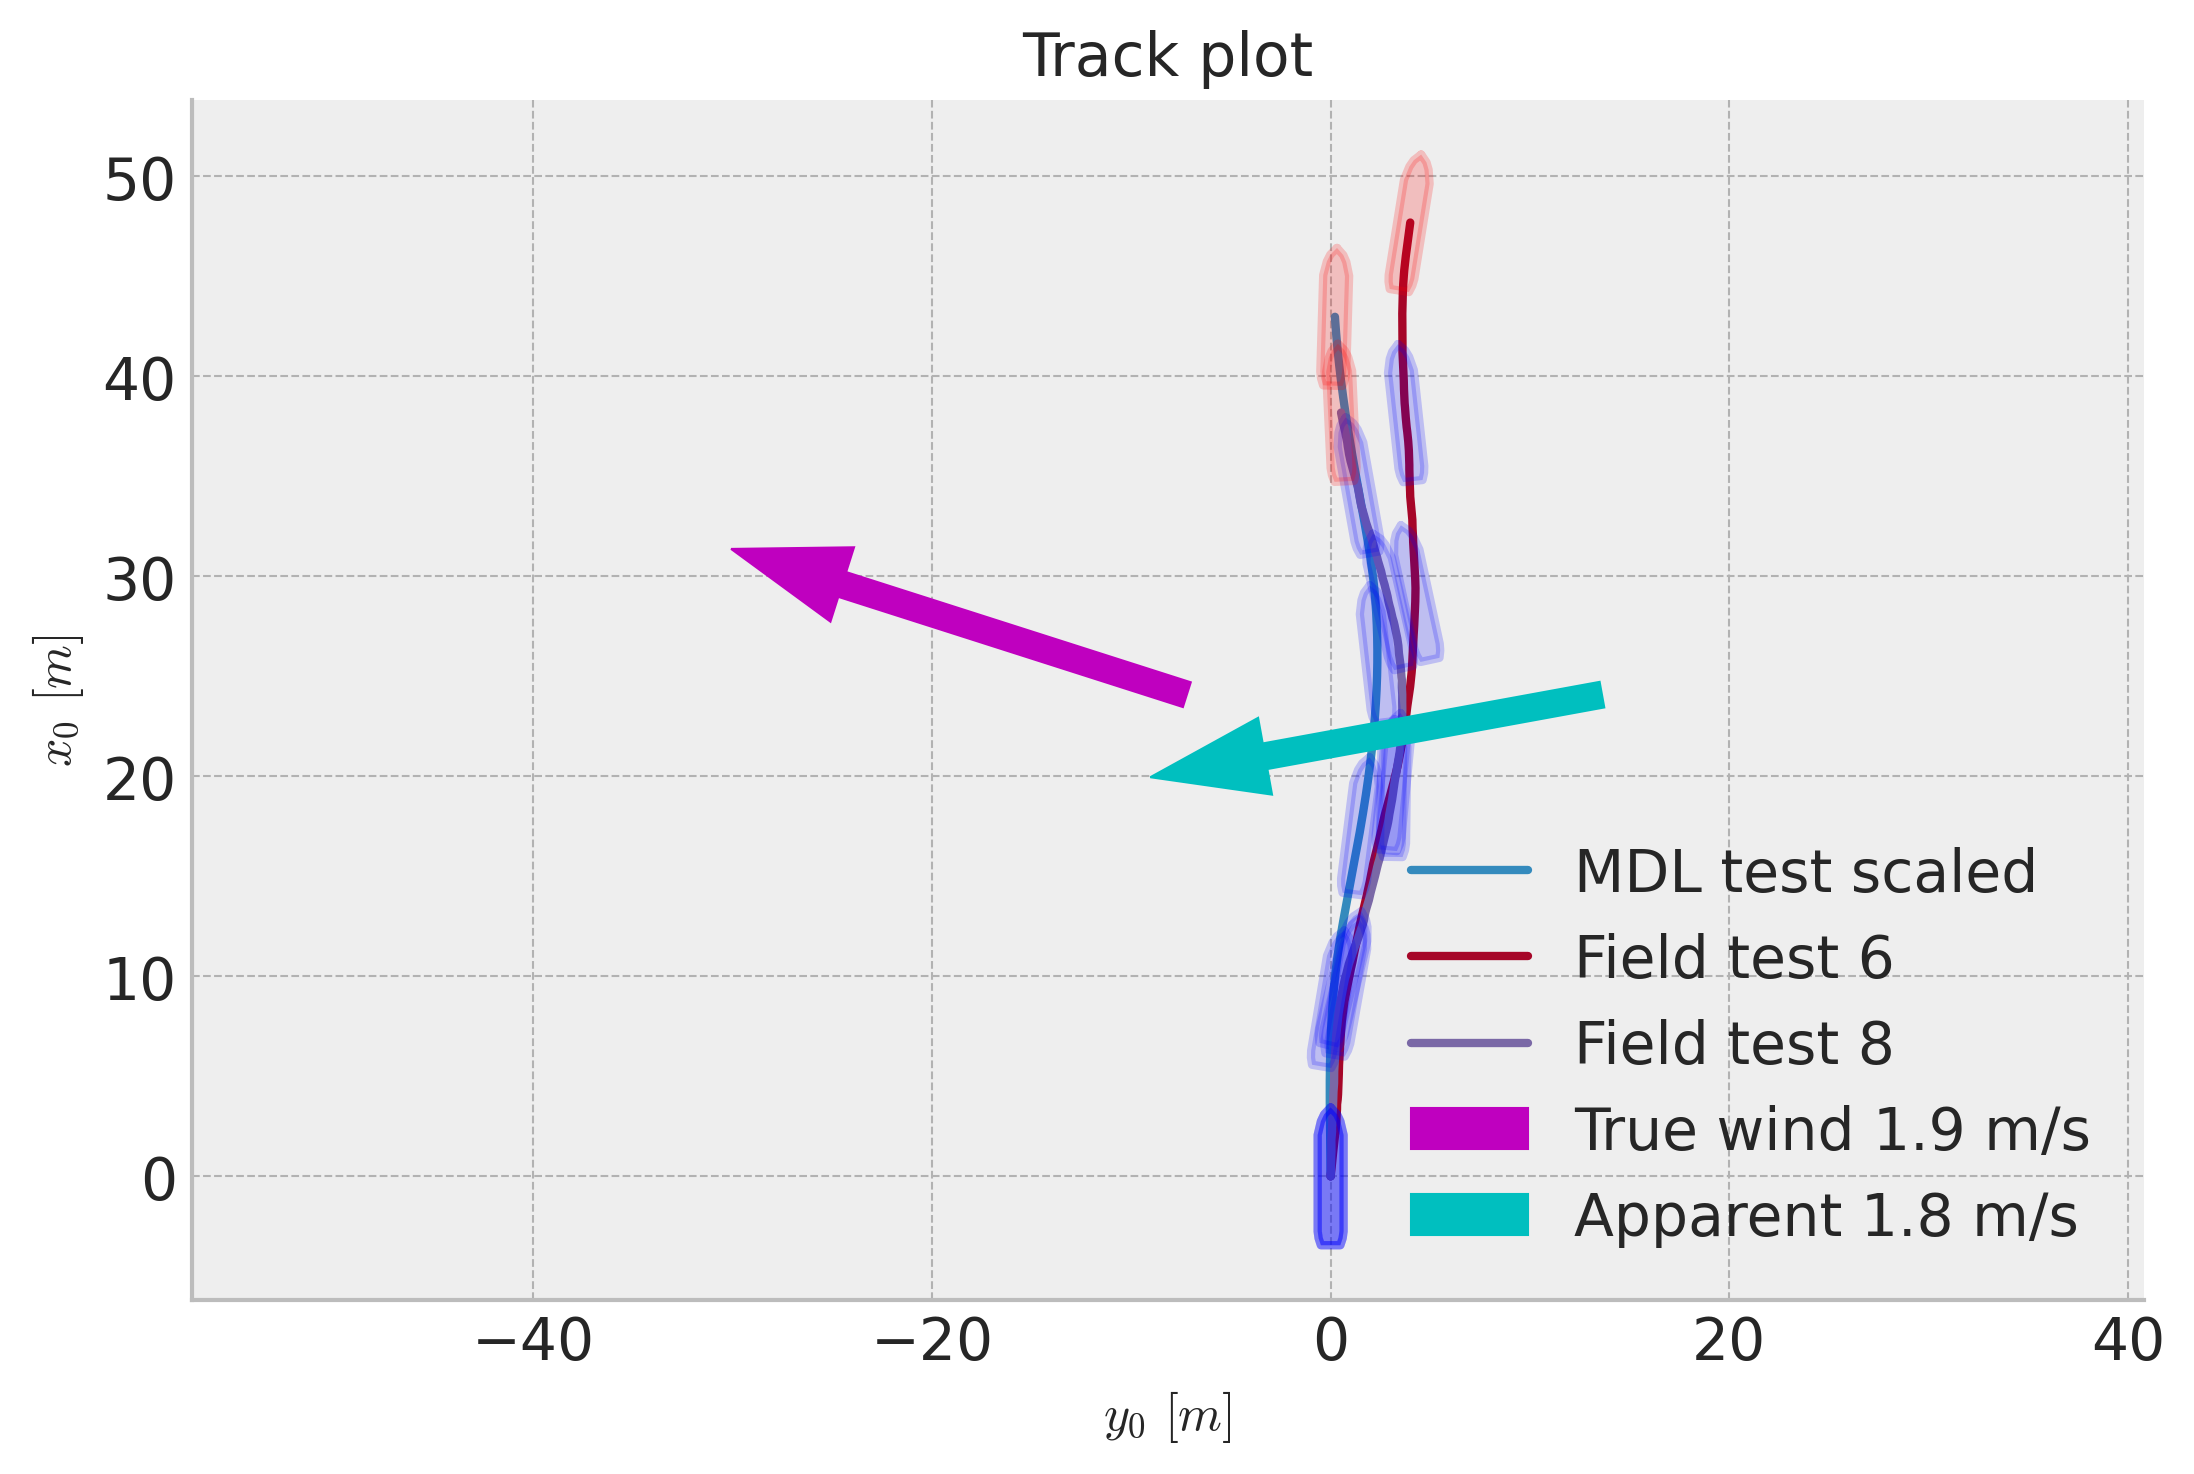

In [24]:
dataframes = {
    'MDL test scaled':data_wPCC_7m.loc[0:data.index[-1]],
}
dataframes.update(field_data)
track_plots(dataframes, lpp=ship_data['L'], beam=ship_data['B'])

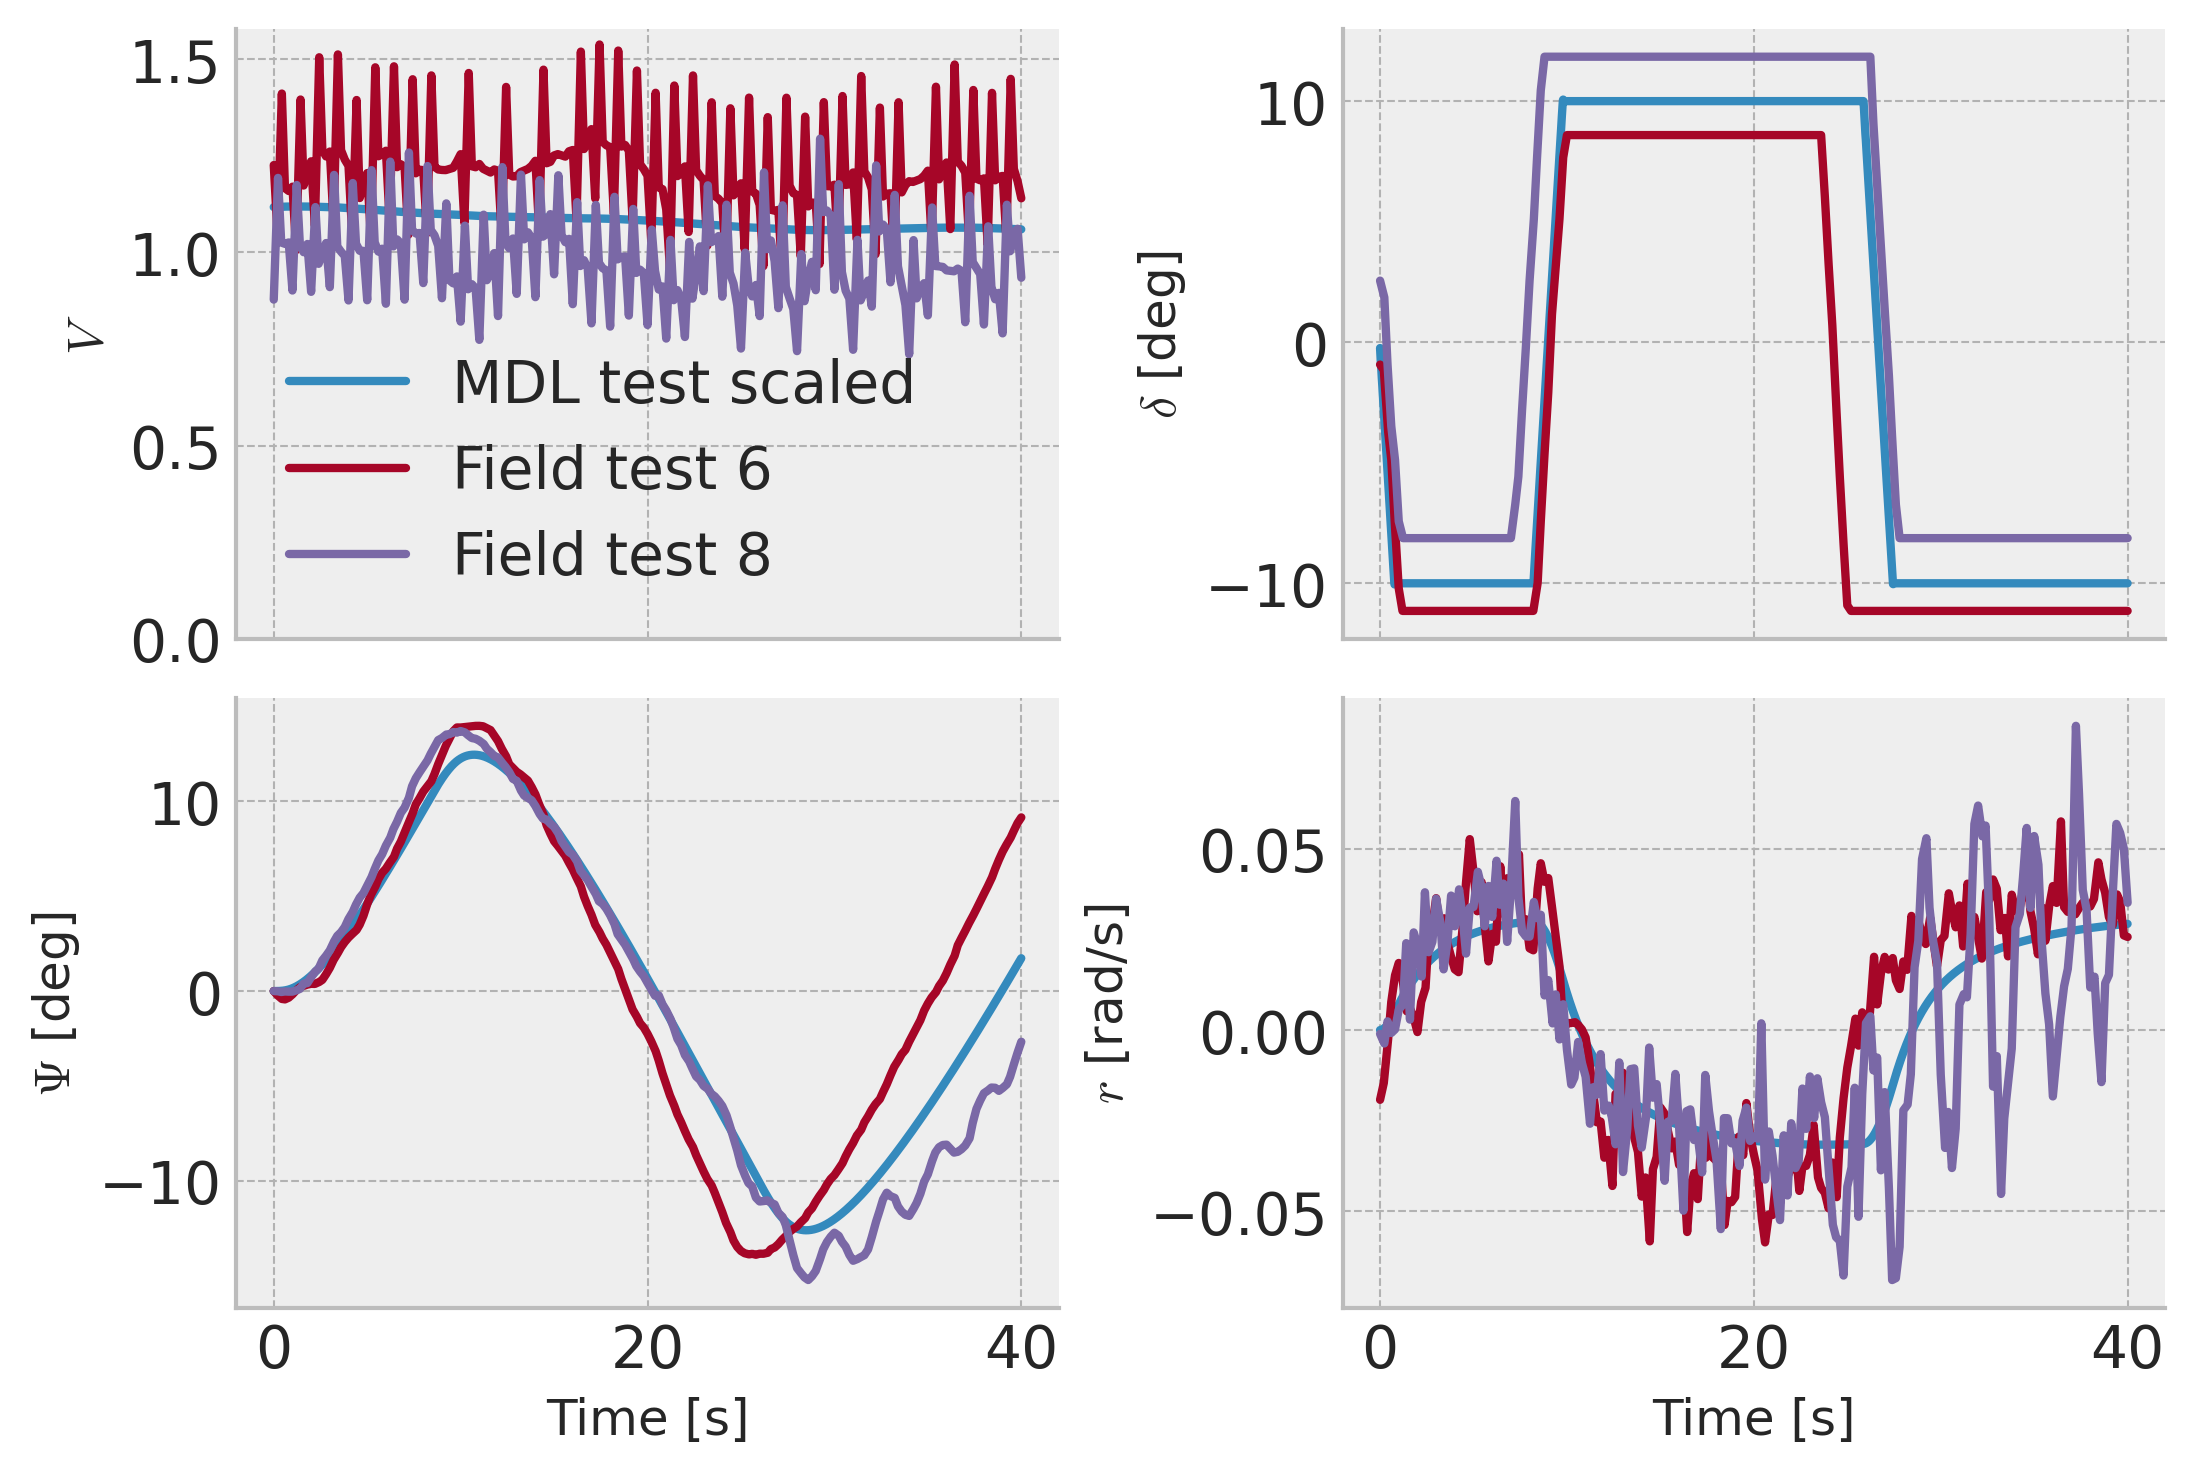

In [25]:
fig = plot(dataframes, keys=['psi','V','r','delta'], units=units, symbols=symbols_dict);
fig.savefig(paper.file_path_with_nb_ref("MDL_test_scaled.pdf"))

<Axes: >

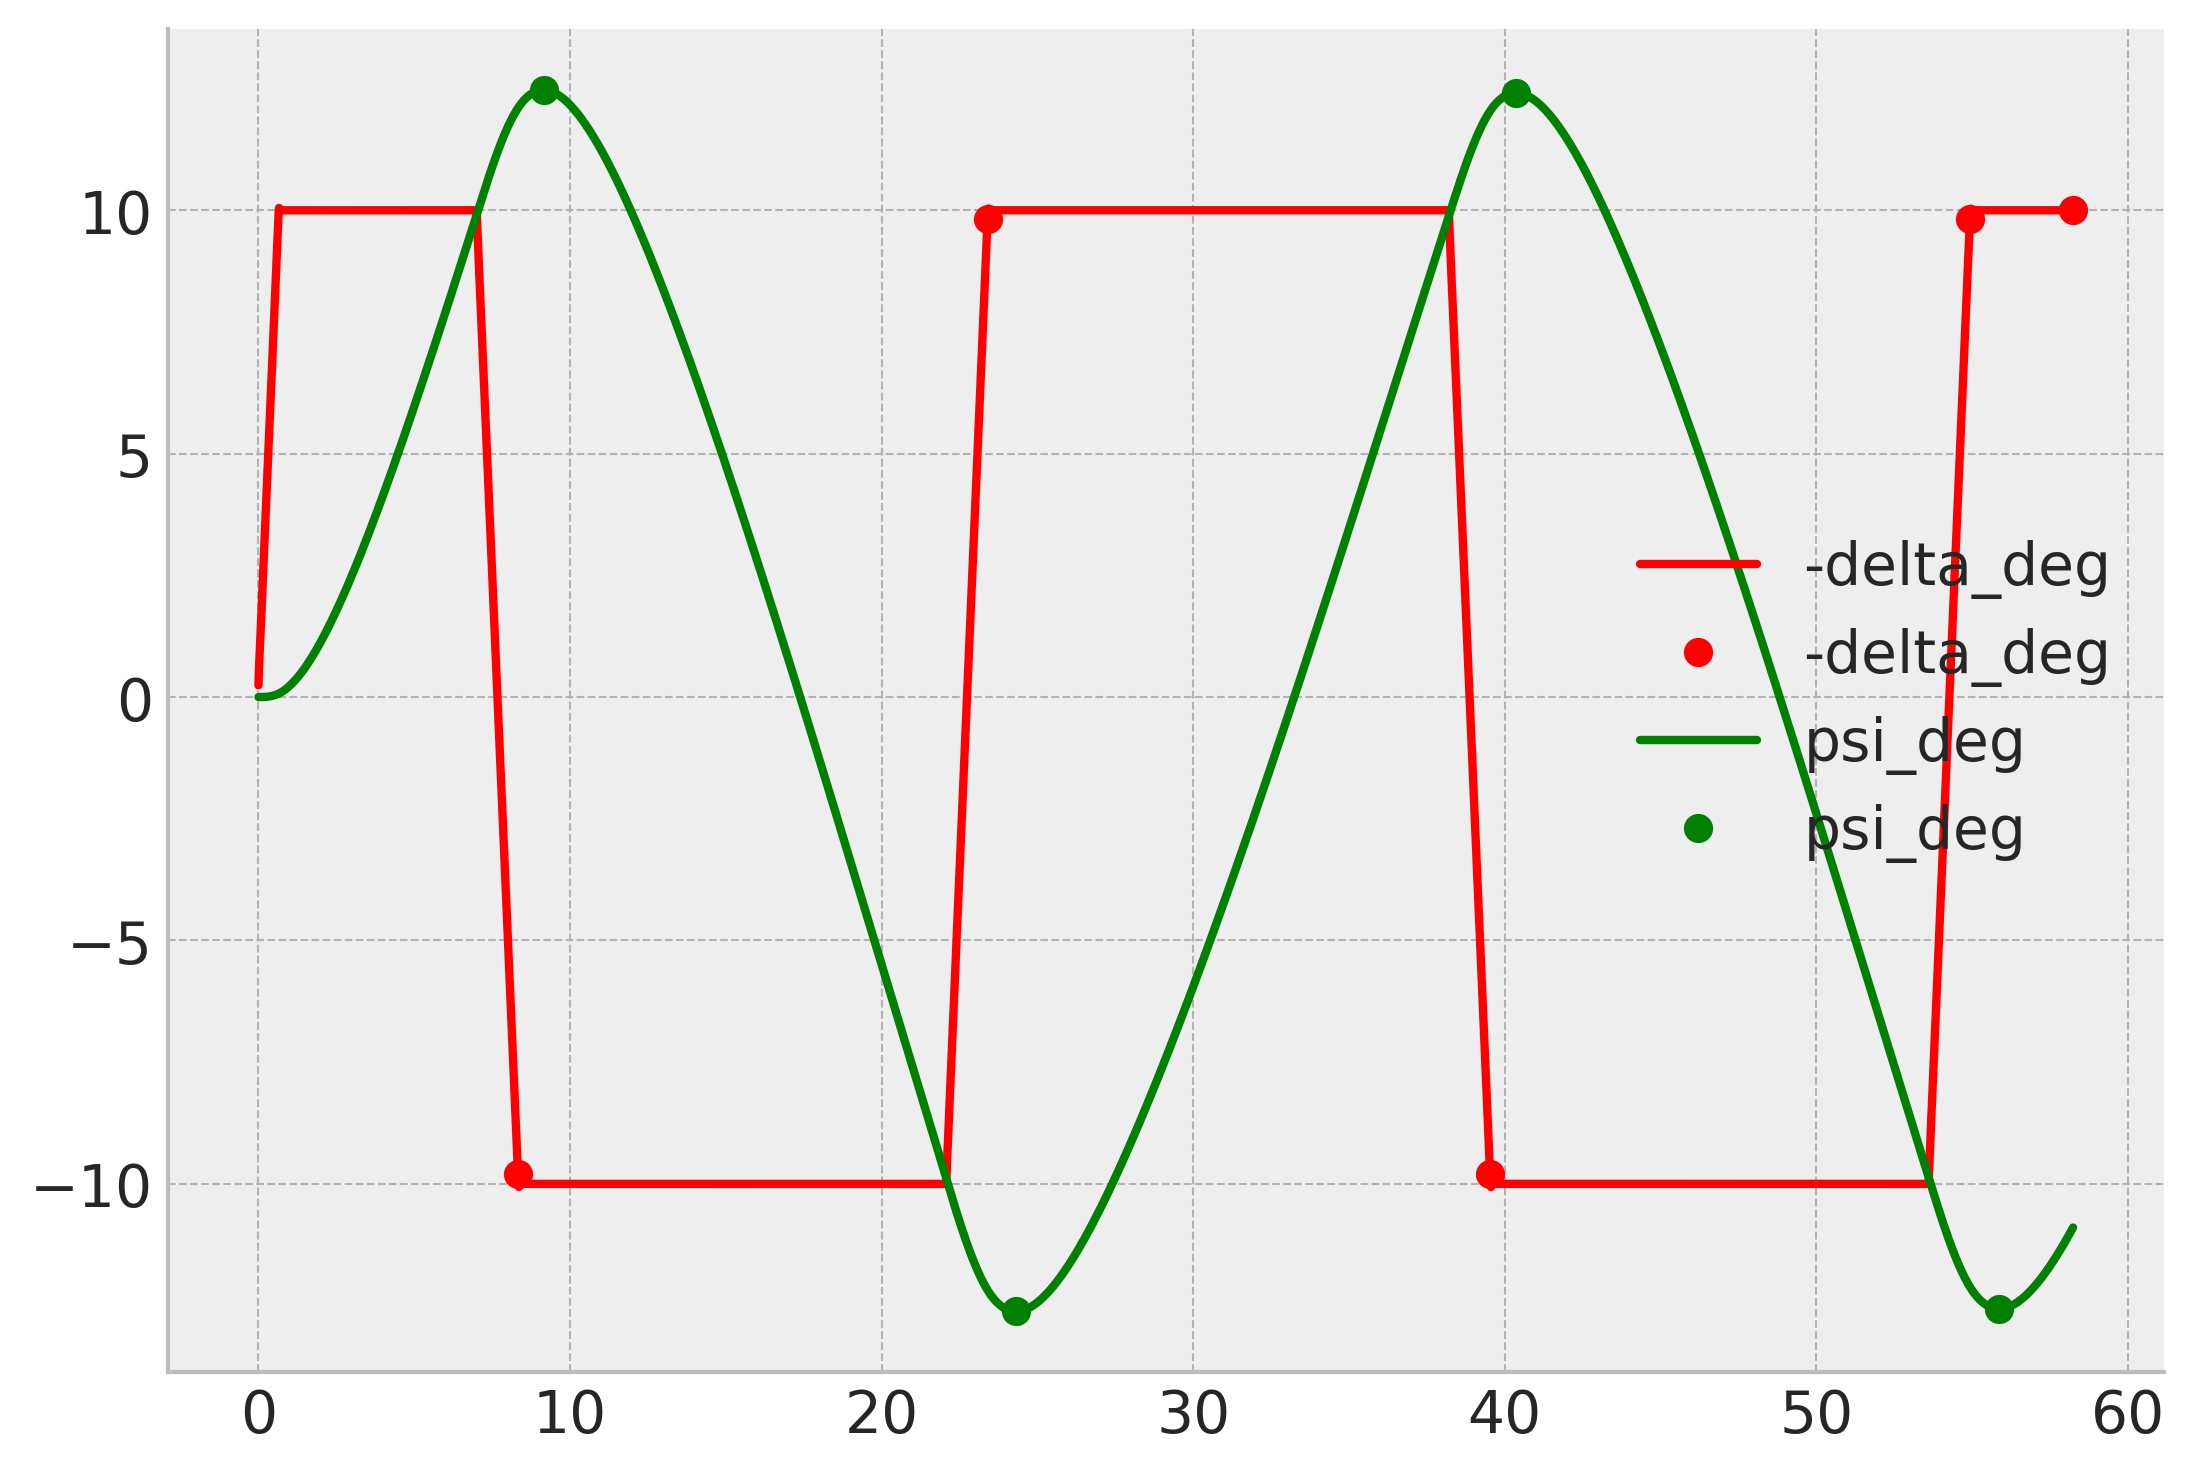

In [26]:
corners = zigzag._get_corners(angle=np.deg2rad(10), df=data_wPCC)
maximums = zigzag._get_maximums(df=data_wPCC, corners=corners)

fig,ax=plt.subplots()
data_wPCC.plot(y='-delta_deg', style='r-', ax=ax)
corners.plot(y='-delta_deg', style='ro', ax=ax)

data_wPCC.plot(y='psi_deg', style='g-', ax=ax)
maximums.plot(y='psi_deg', style='go', ax=ax)

In [27]:
zigzag.get_overshoots(angle=np.deg2rad(10), df=data_wPCC_7m)

10.722821    2.468470
28.488720    2.618598
47.297604    2.407741
65.473665    2.564913
Name: psi, dtype: float64

<Axes: xlabel='time'>

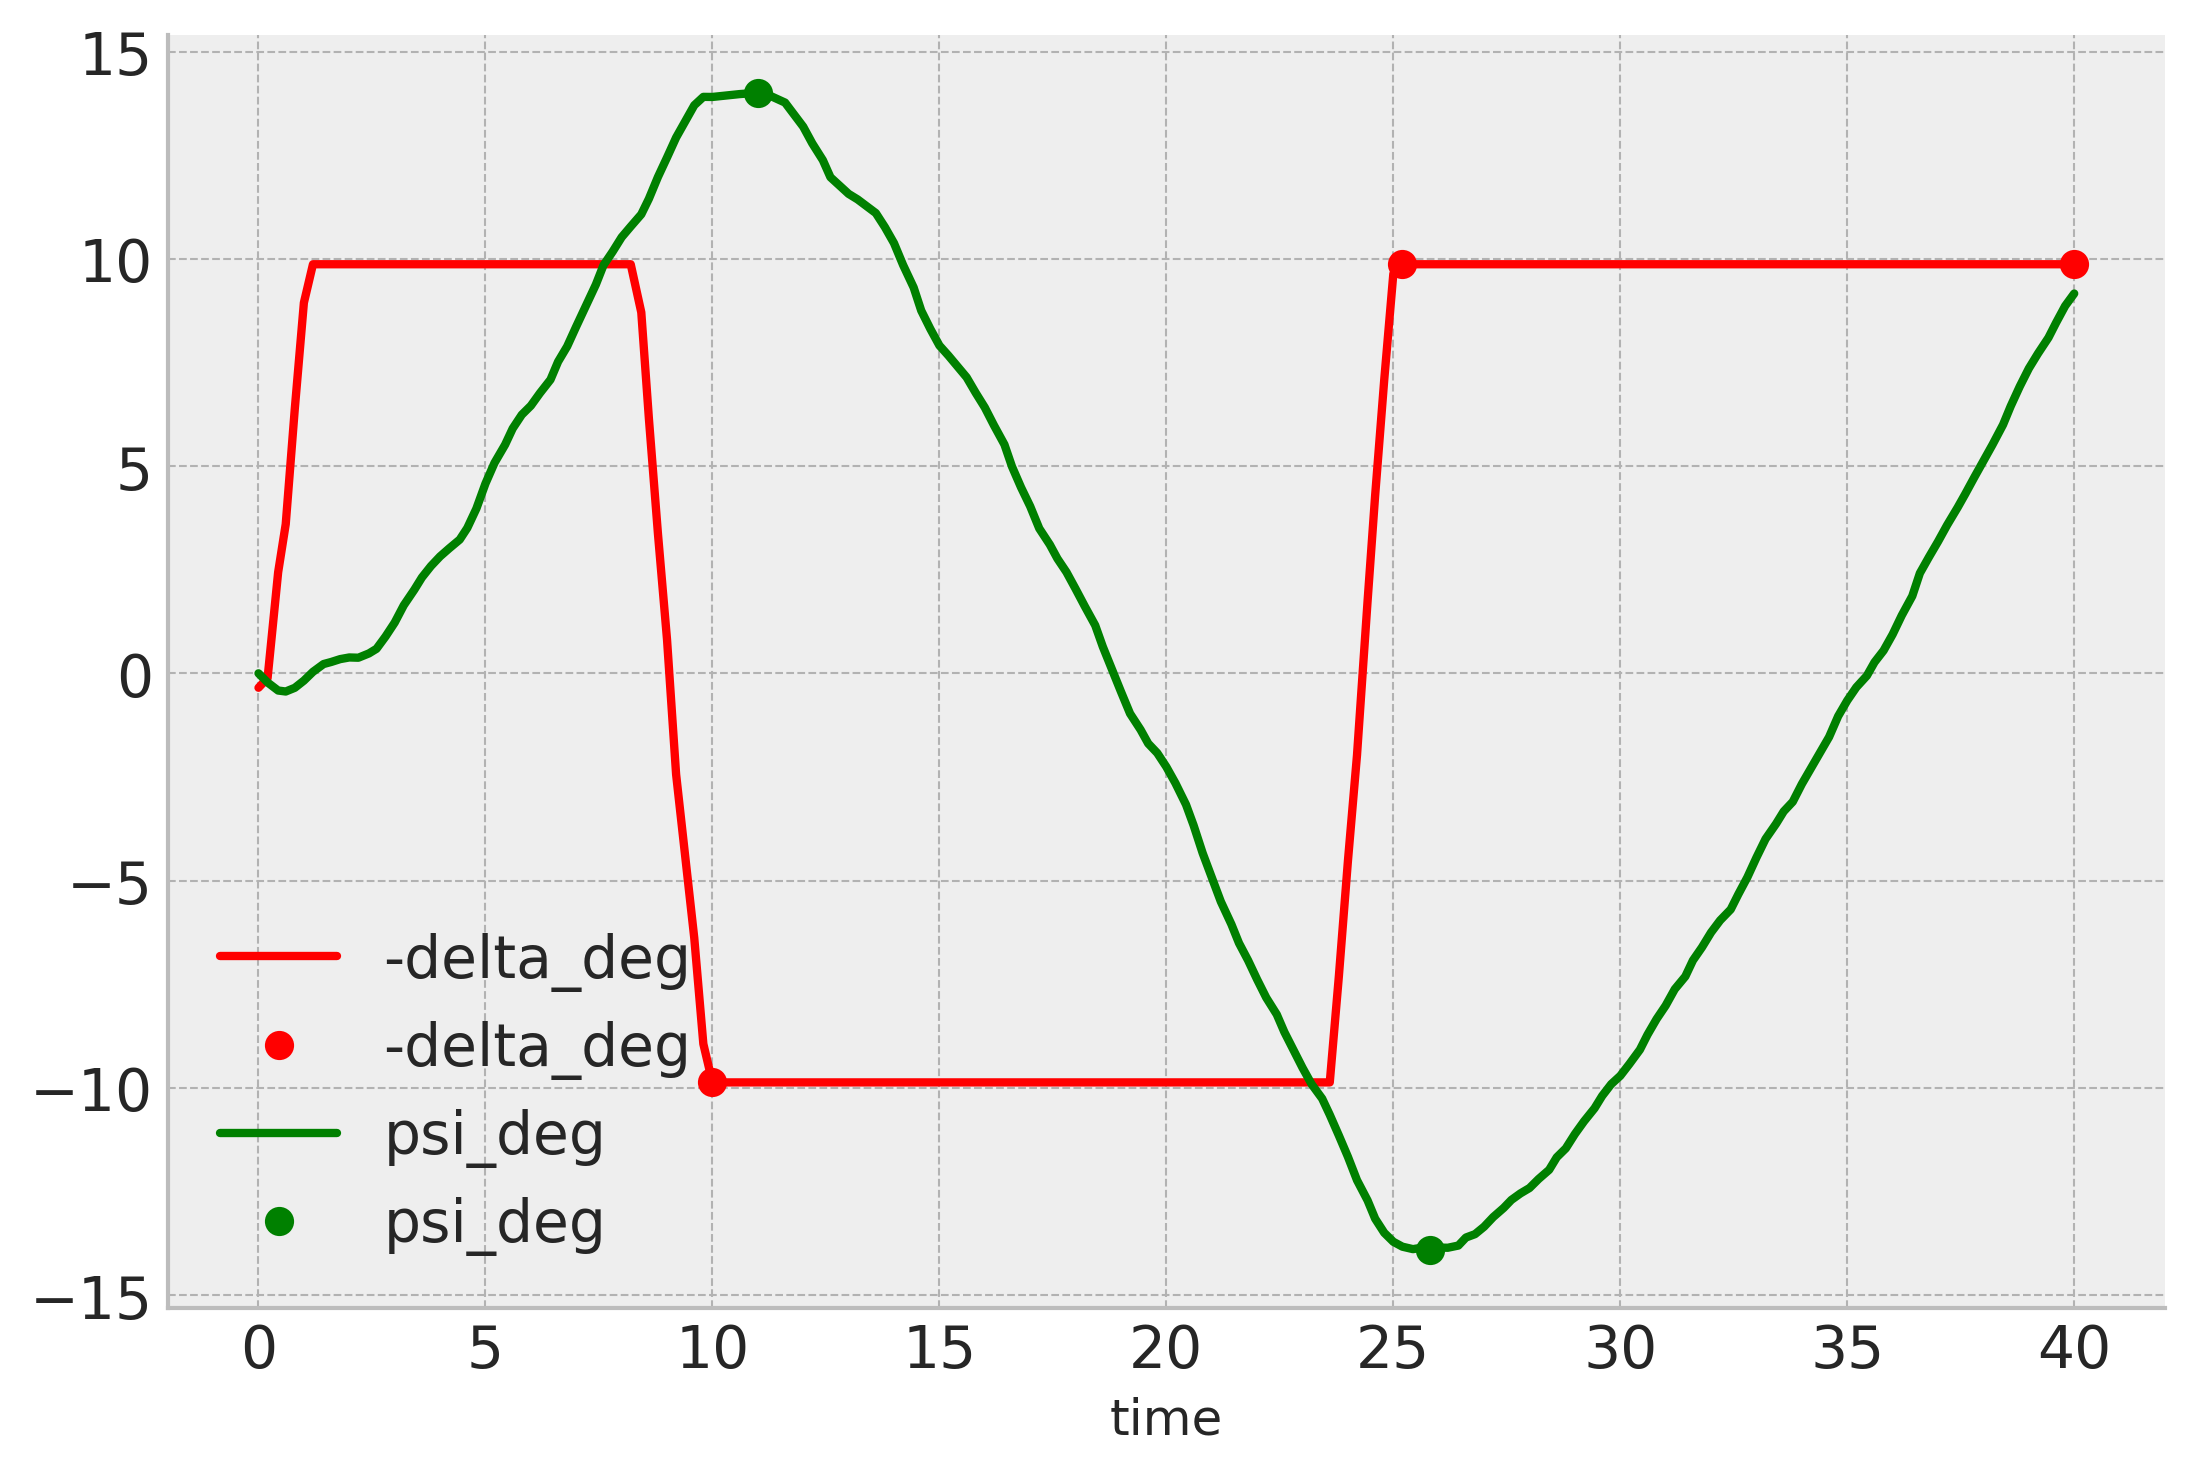

In [28]:
id = "Field test 6"

df = field_data[id].copy()
df['psi_deg'] = np.rad2deg(df['psi'])
df['delta']-=(df['delta'].max() + df['delta'].min())/2
df['-delta_deg']=-np.rad2deg(df['delta'])

corners = zigzag._get_corners(angle=np.deg2rad(10), df=df)
maximums = zigzag._get_maximums(df=df, corners=corners)

fig,ax=plt.subplots()
df.plot(y='-delta_deg', style='r-', ax=ax)
corners.plot(y='-delta_deg', style='ro', ax=ax)

field_data[id].plot(y='psi_deg', style='g-', ax=ax)
maximums.plot(y='psi_deg', style='go', ax=ax)

In [29]:
zigzag.get_overshoots(angle=np.deg2rad(10), df=df)

time
10.999860    3.991059
25.799617    3.909216
Name: psi, dtype: float64

In [30]:
def load_MDL(id):
    data_wPCC = time_series_wPCC[f'wpcc.updated.{id}.ek_smooth']()
    #i = np.argmax(np.abs(np.gradient(data_wPCC['delta'],data_wPCC.index)) > np.deg2rad(2.32)*np.sqrt(ship_data_wPCC['scale_factor']))
    #data_wPCC=data_wPCC.iloc[i:].copy()
    data_wPCC['x0']-=data_wPCC.iloc[0]['x0']
    data_wPCC['y0']-=data_wPCC.iloc[0]['y0']
    data_wPCC.index-=data_wPCC.index[0]
    
    data_wPCC['V'] = data_wPCC['U'] = np.sqrt(data_wPCC['u']**2 + data_wPCC['v']**2)
    
    data_wPCC['psi']-=data_wPCC.iloc[0]['psi']
    
    ## scaling:
    data_wPCC_prime = model_MDL.prime_system.prime(data_wPCC[model_MDL.states_str + model_MDL.control_keys + ['V']], U=data_wPCC['V'])
    data_wPCC_7m = model.prime_system.unprime(data_wPCC_prime, U=data_wPCC['V']*np.sqrt(scaling))
    data_wPCC_7m.index*=np.sqrt(scaling)
    
    data_wPCC_7m['psi_deg'] = np.rad2deg(data_wPCC_7m['psi'])
    data_wPCC_7m['-delta_deg'] = -np.rad2deg(data_wPCC_7m['delta'])
    
    
    return data_wPCC_7m

In [31]:
def evaluate(df,angle):
    overshoots = zigzag.get_overshoots(angle=np.deg2rad(angle), df=df)
    
    results = pd.Series(name=id)
    for i, overshoot in enumerate(overshoots.values):
        results[f"overshoot_{i+1}"] = overshoot
        
    for n in range(i-1):
        results[f"period_{n+1}"] = overshoots.index[n+1] - overshoots.index[n]
        
    results['V'] = df['V'].iloc[0:10].mean()
    
    return results
    

In [32]:
_ = []
mask = time_series_meta_data_wPCC['test_type'] == 'zigzag'
time_series_selection = time_series_meta_data_wPCC.loc[mask].copy()
time_series_selection.drop(index=[22764], inplace=True)
for id, meta_data in time_series_selection.iterrows():
    
    try:
        df = load_MDL(id)
    except:
        continue
        
    angle = meta_data['angle1']
    results = evaluate(df=df, angle=angle)   
    _.append(results)
    
evaluations_MDL = pd.DataFrame(_)
evaluations_MDL = pd.merge(left=evaluations_MDL, right=time_series_meta_data_wPCC, left_index=True, right_index=True, how='left')

In [33]:
evaluations_MDL

overshoot_1  overshoot_2  overshoot_3   period_1         V  overshoot_4   period_2  overshoot_5  period_3        A0  ABULB  AI  AIX  AR  ARH  ASKEG  BKB  BKL  BKX  BR  BRA  BTT1  BWL  CFP  CP  CW   D  DCLR  HSKEG  IRUD       KXX       KZZ  Körfallstyp  LOA  LSKEG  NDES  PD  PDTDES  PROT  PTYPE  RH  RHBL  RR  RSKEG  RTYPE  SFP        TA        TF  TWIN  VDES    Volume  XRUD  XSKEG  angle1  angle2  ascii_name      beam     comment        date facility  file_path_ascii  file_path_ascii_temp                                     file_path_hdf5  file_path_log        gm        kg      lcg  loading_condition_id       lpp model_number    name  project_number  run_number  scale_factor  series_number   ship_name  ship_speed  ship_type_id  test_number test_type   xm   ym     zm
22769     2.535368     2.467289    -1.253929  17.695577  1.110152          NaN        NaN          NaN       NaN  0.722775    NaN NaN  NaN NaN  NaN    NaN  NaN  NaN  NaN NaN  NaN   NaN  NaN  NaN NaN NaN NaN   NaN    NaN   NaN  0.331311  1.253641          NaN  NaN    NaN   NaN NaN     NaN   NaN    NaN NaN   NaN NaN    NaN    NaN  NaN  0.206311  0.206311   NaN   NaN  0.441027   NaN    NaN    10.0    10.0         NaN  0.946602  ZZ 10/10PS  2020-09-24      MDL              NaN                   NaN  \\sspa.local\lab\MeasuredataMDL\40199079\005\0...            NaN  0.136092  0.438908 -0.24432                 167.0  5.014563   M5139-02-A  Design      40199079.0         5.0          41.2            5.0  M5139-02-A     0.96177           NaN          2.0    zigzag  0.0  0.0 -0.214
22770     2.513903     2.446363     2.447115  17.625274  1.106733     2.288891  18.000280          NaN       NaN  0.722775    NaN NaN  NaN NaN  NaN    NaN  NaN  NaN  NaN NaN  NaN   NaN  NaN  NaN NaN NaN NaN   NaN    NaN   NaN  0.331311  1.253641          NaN  NaN    NaN   NaN NaN     NaN   NaN    NaN NaN   NaN NaN    NaN    NaN  NaN  0.206311  0.206311   NaN   NaN  0.441027   NaN    NaN    10.0    10.0         NaN  0.946602  ZZ 10/10PS  2020-09-24      MDL              NaN                   NaN  \\sspa.local\lab\MeasuredataMDL\40199079\005\0...            NaN  0.136092  0.438908 -0.24432                 167.0  5.014563   M5139-02-A  Design      40199079.0         6.0          41.2            5.0  M5139-02-A     0.96177           NaN          2.0    zigzag  0.0  0.0 -0.214
22771     7.263554     5.621849     6.071580  20.097969  1.113647    -3.090032  21.586273     4.941169  6.996203  0.722775    NaN NaN  NaN NaN  NaN    NaN  NaN  NaN  NaN NaN  NaN   NaN  NaN  NaN NaN NaN NaN   NaN    NaN   NaN  0.331311  1.253641          NaN  NaN    NaN   NaN NaN     NaN   NaN    NaN NaN   NaN NaN    NaN    NaN  NaN  0.206311  0.206311   NaN   NaN  0.441027   NaN    NaN    20.0    20.0         NaN  0.946602  ZZ 20/20SB  2020-09-24      MDL              NaN                   NaN  \\sspa.local\lab\MeasuredataMDL\40199079\005\0...            NaN  0.136092  0.438908 -0.24432                 167.0  5.014563   M5139-02-A  Design      40199079.0         1.0          41.2            5.0  M5139-02-A     0.96177           NaN          3.0    zigzag  0.0  0.0 -0.214
22772     7.375330     5.793146     5.911041  20.320624  1.111596     5.270874  21.351890          NaN       NaN  0.722775    NaN NaN  NaN NaN  NaN    NaN  NaN  NaN  NaN NaN  NaN   NaN  NaN  NaN NaN NaN NaN   NaN    NaN   NaN  0.331311  1.253641          NaN  NaN    NaN   NaN NaN     NaN   NaN    NaN NaN   NaN NaN    NaN    NaN  NaN  0.206311  0.206311   NaN   NaN  0.441027   NaN    NaN    20.0    20.0         NaN  0.946602  ZZ 20/20SB  2020-09-24      MDL              NaN                   NaN  \\sspa.local\lab\MeasuredataMDL\40199079\005\0...            NaN  0.136092  0.438908 -0.24432                 167.0  5.014563   M5139-02-A  Design      40199079.0         2.0          41.2            5.0  M5139-02-A     0.96177           NaN          3.0    zigzag  0.0  0.0 -0.214
22773     7.435742     5.401102     6.298248  20.402659  1.101385     5.020544  21.152671   

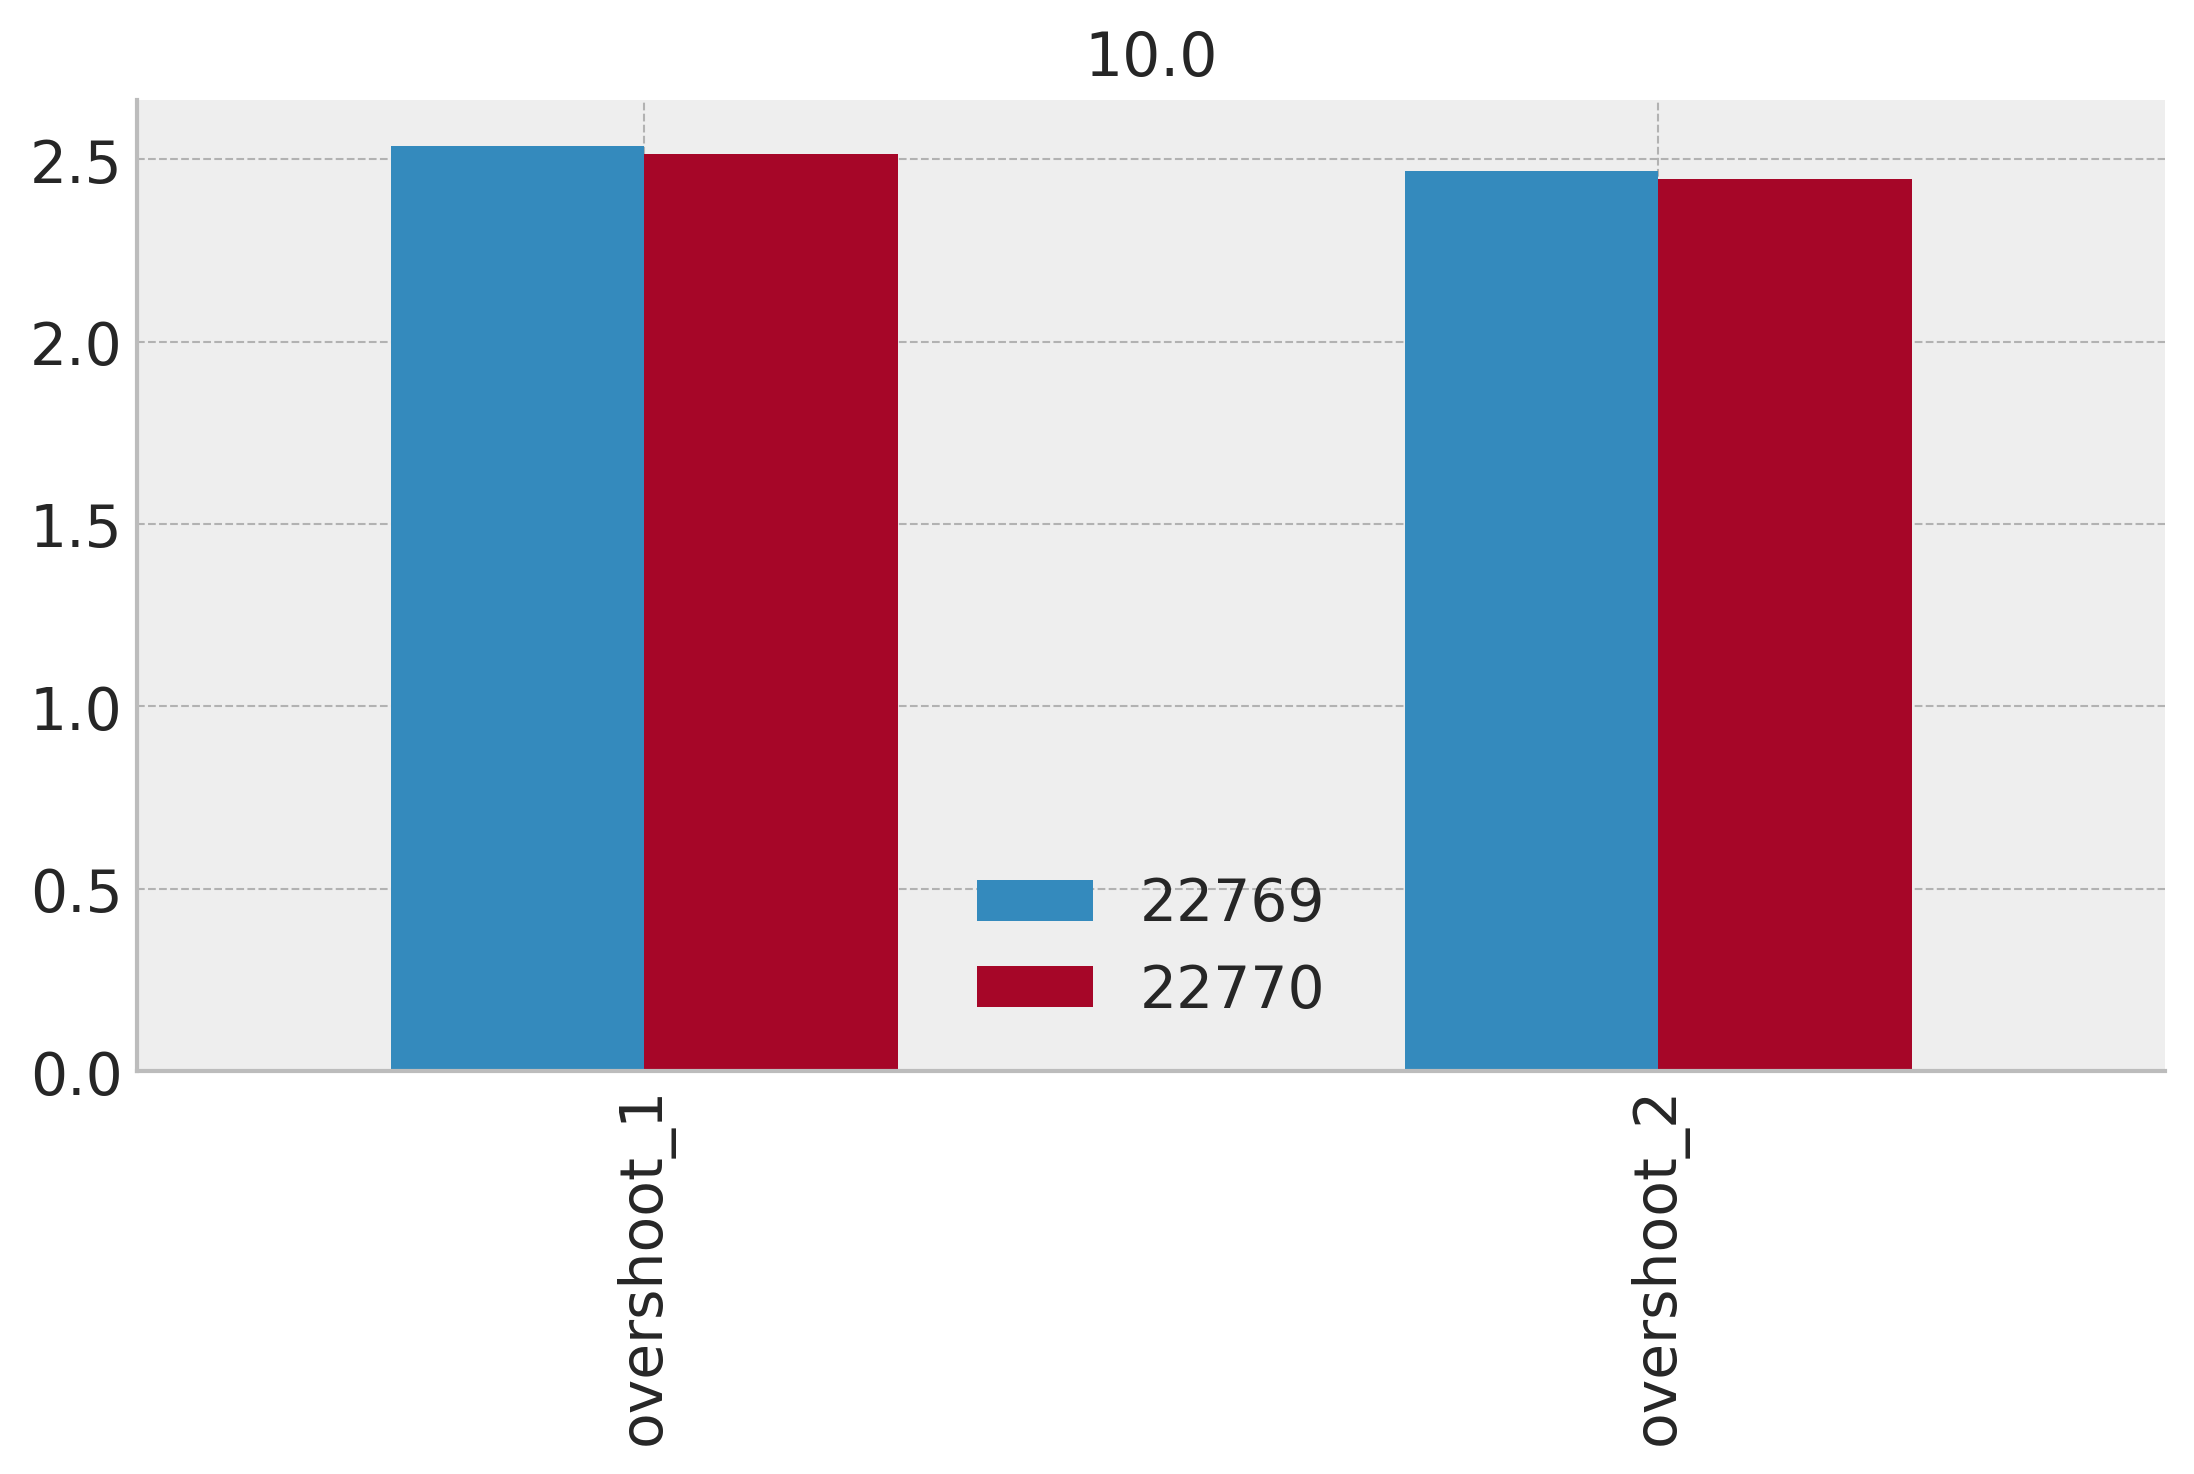

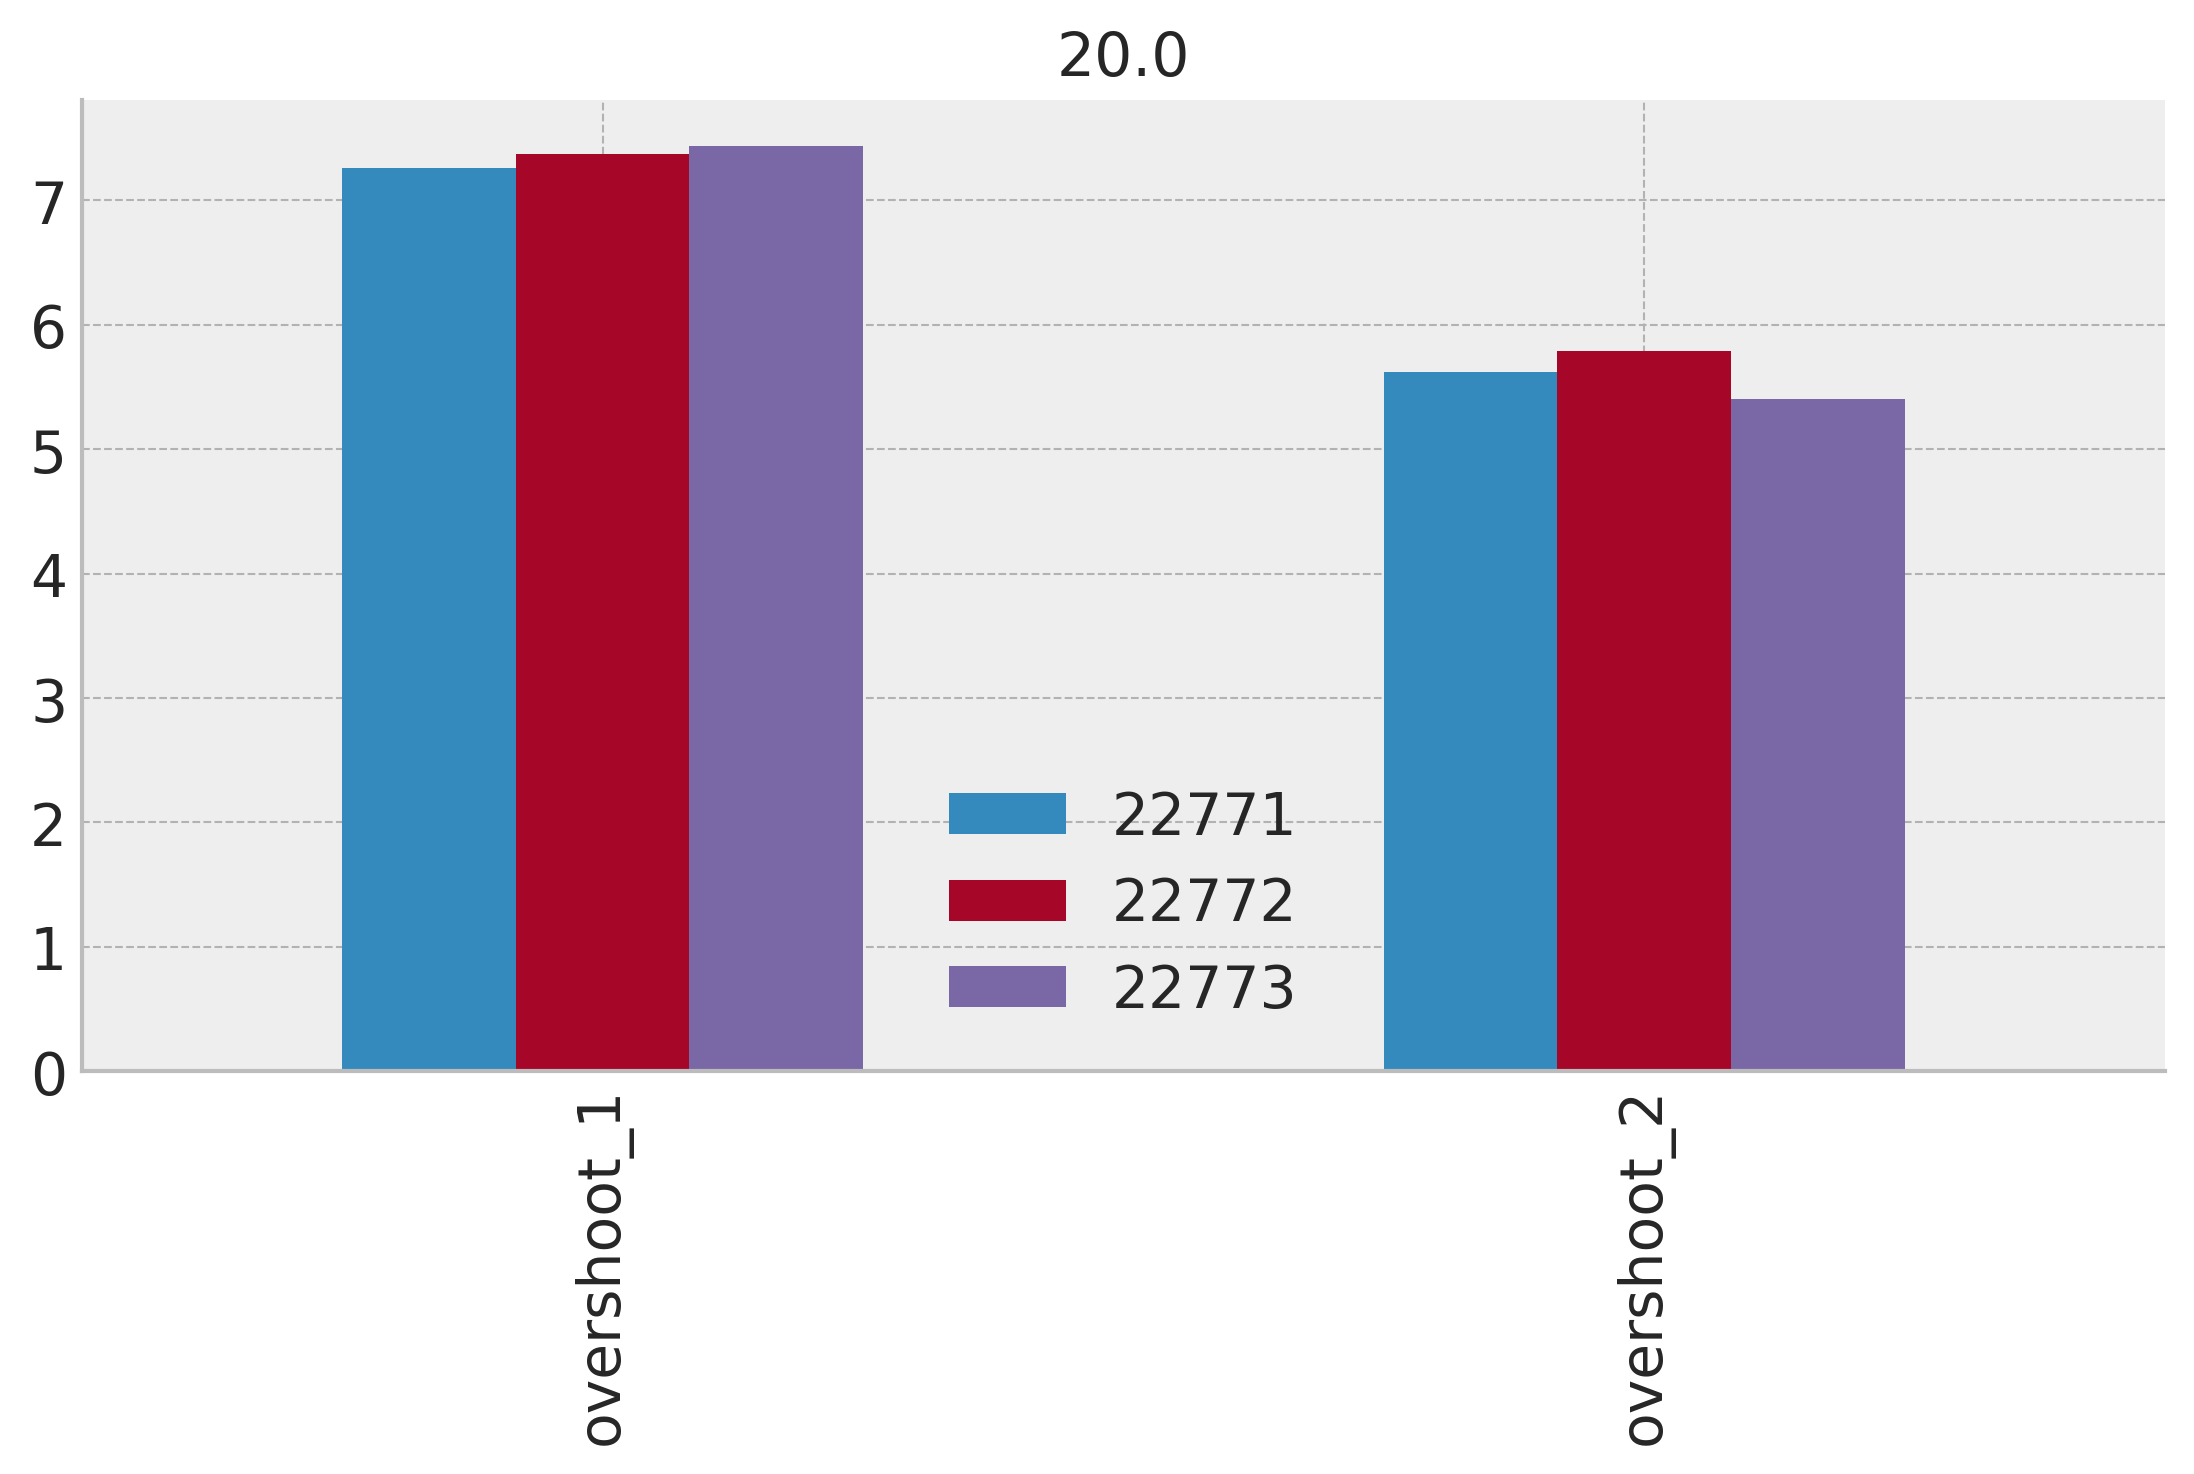

In [34]:
for angle, group in evaluations_MDL.groupby(by='angle1'):
    fig,ax=plt.subplots()
    group[['overshoot_1','overshoot_2']].transpose().plot.bar(ax=ax)
    ax.set_title(angle)

In [35]:
time_series_ek_smooth = catalog.load(f"7m.tests_ek_smooth")

[01/10/24 08:25:37] INFO     Loading data from '7m.tests_ek_smooth' (PartitionedDataset)...     ]8;id=922128;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=595468;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\

In [36]:
def load_field_data(id):
    data = time_series_ek_smooth[str(id)]()
    preprocess(data)
    return data

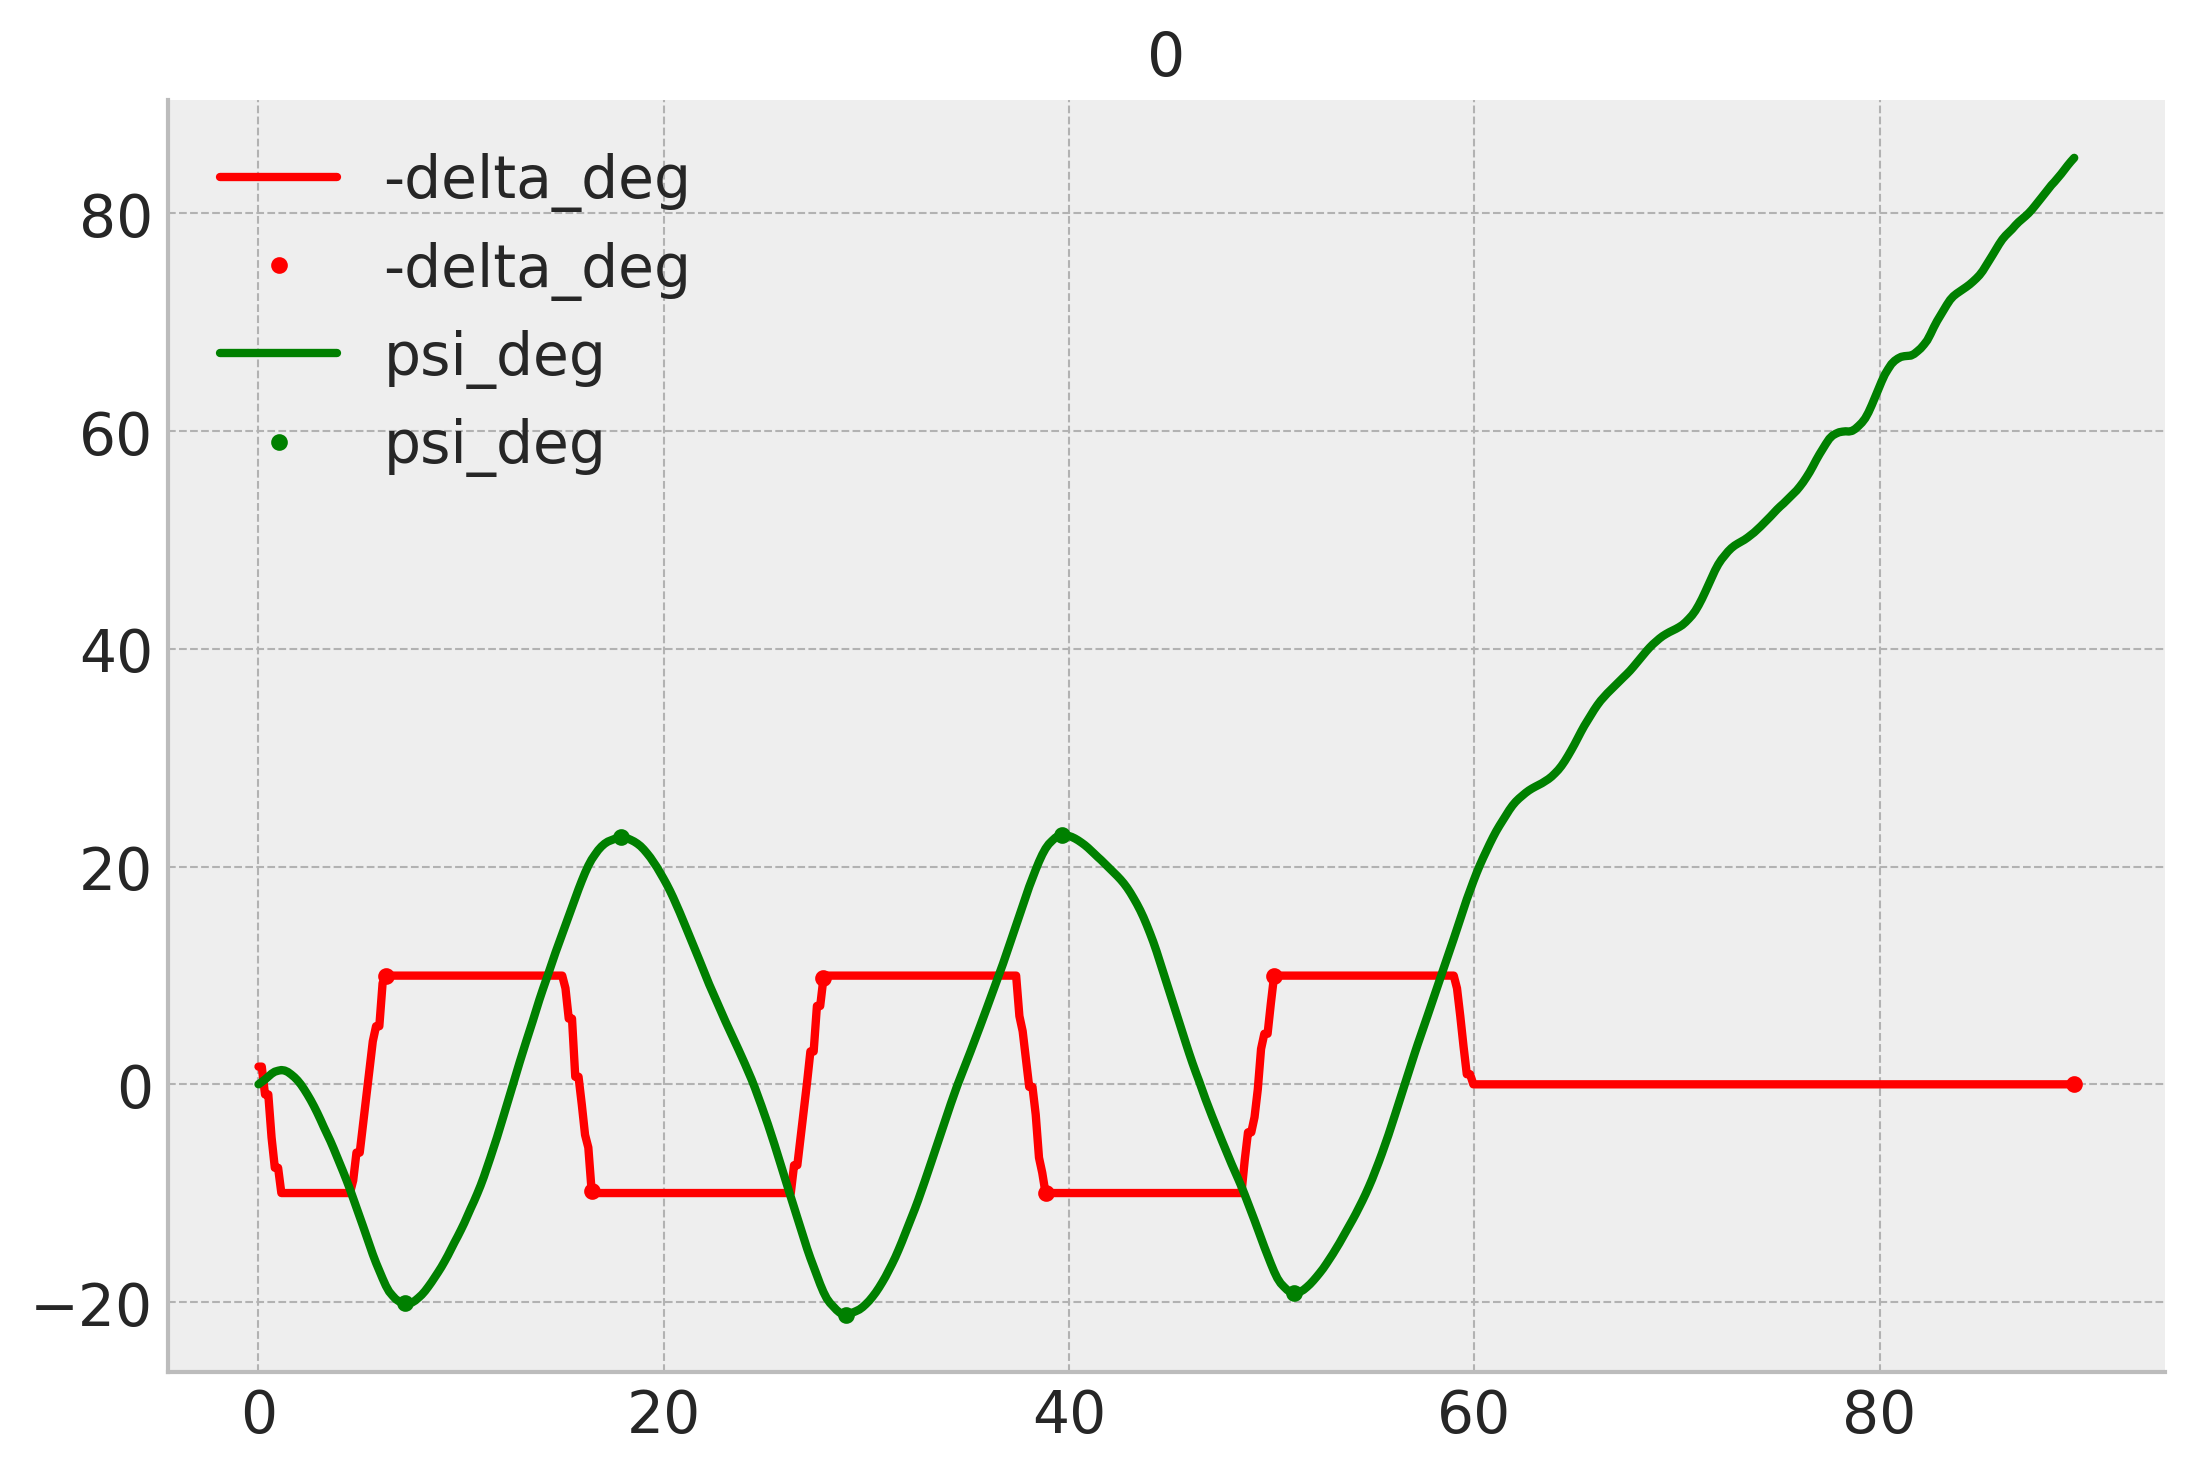

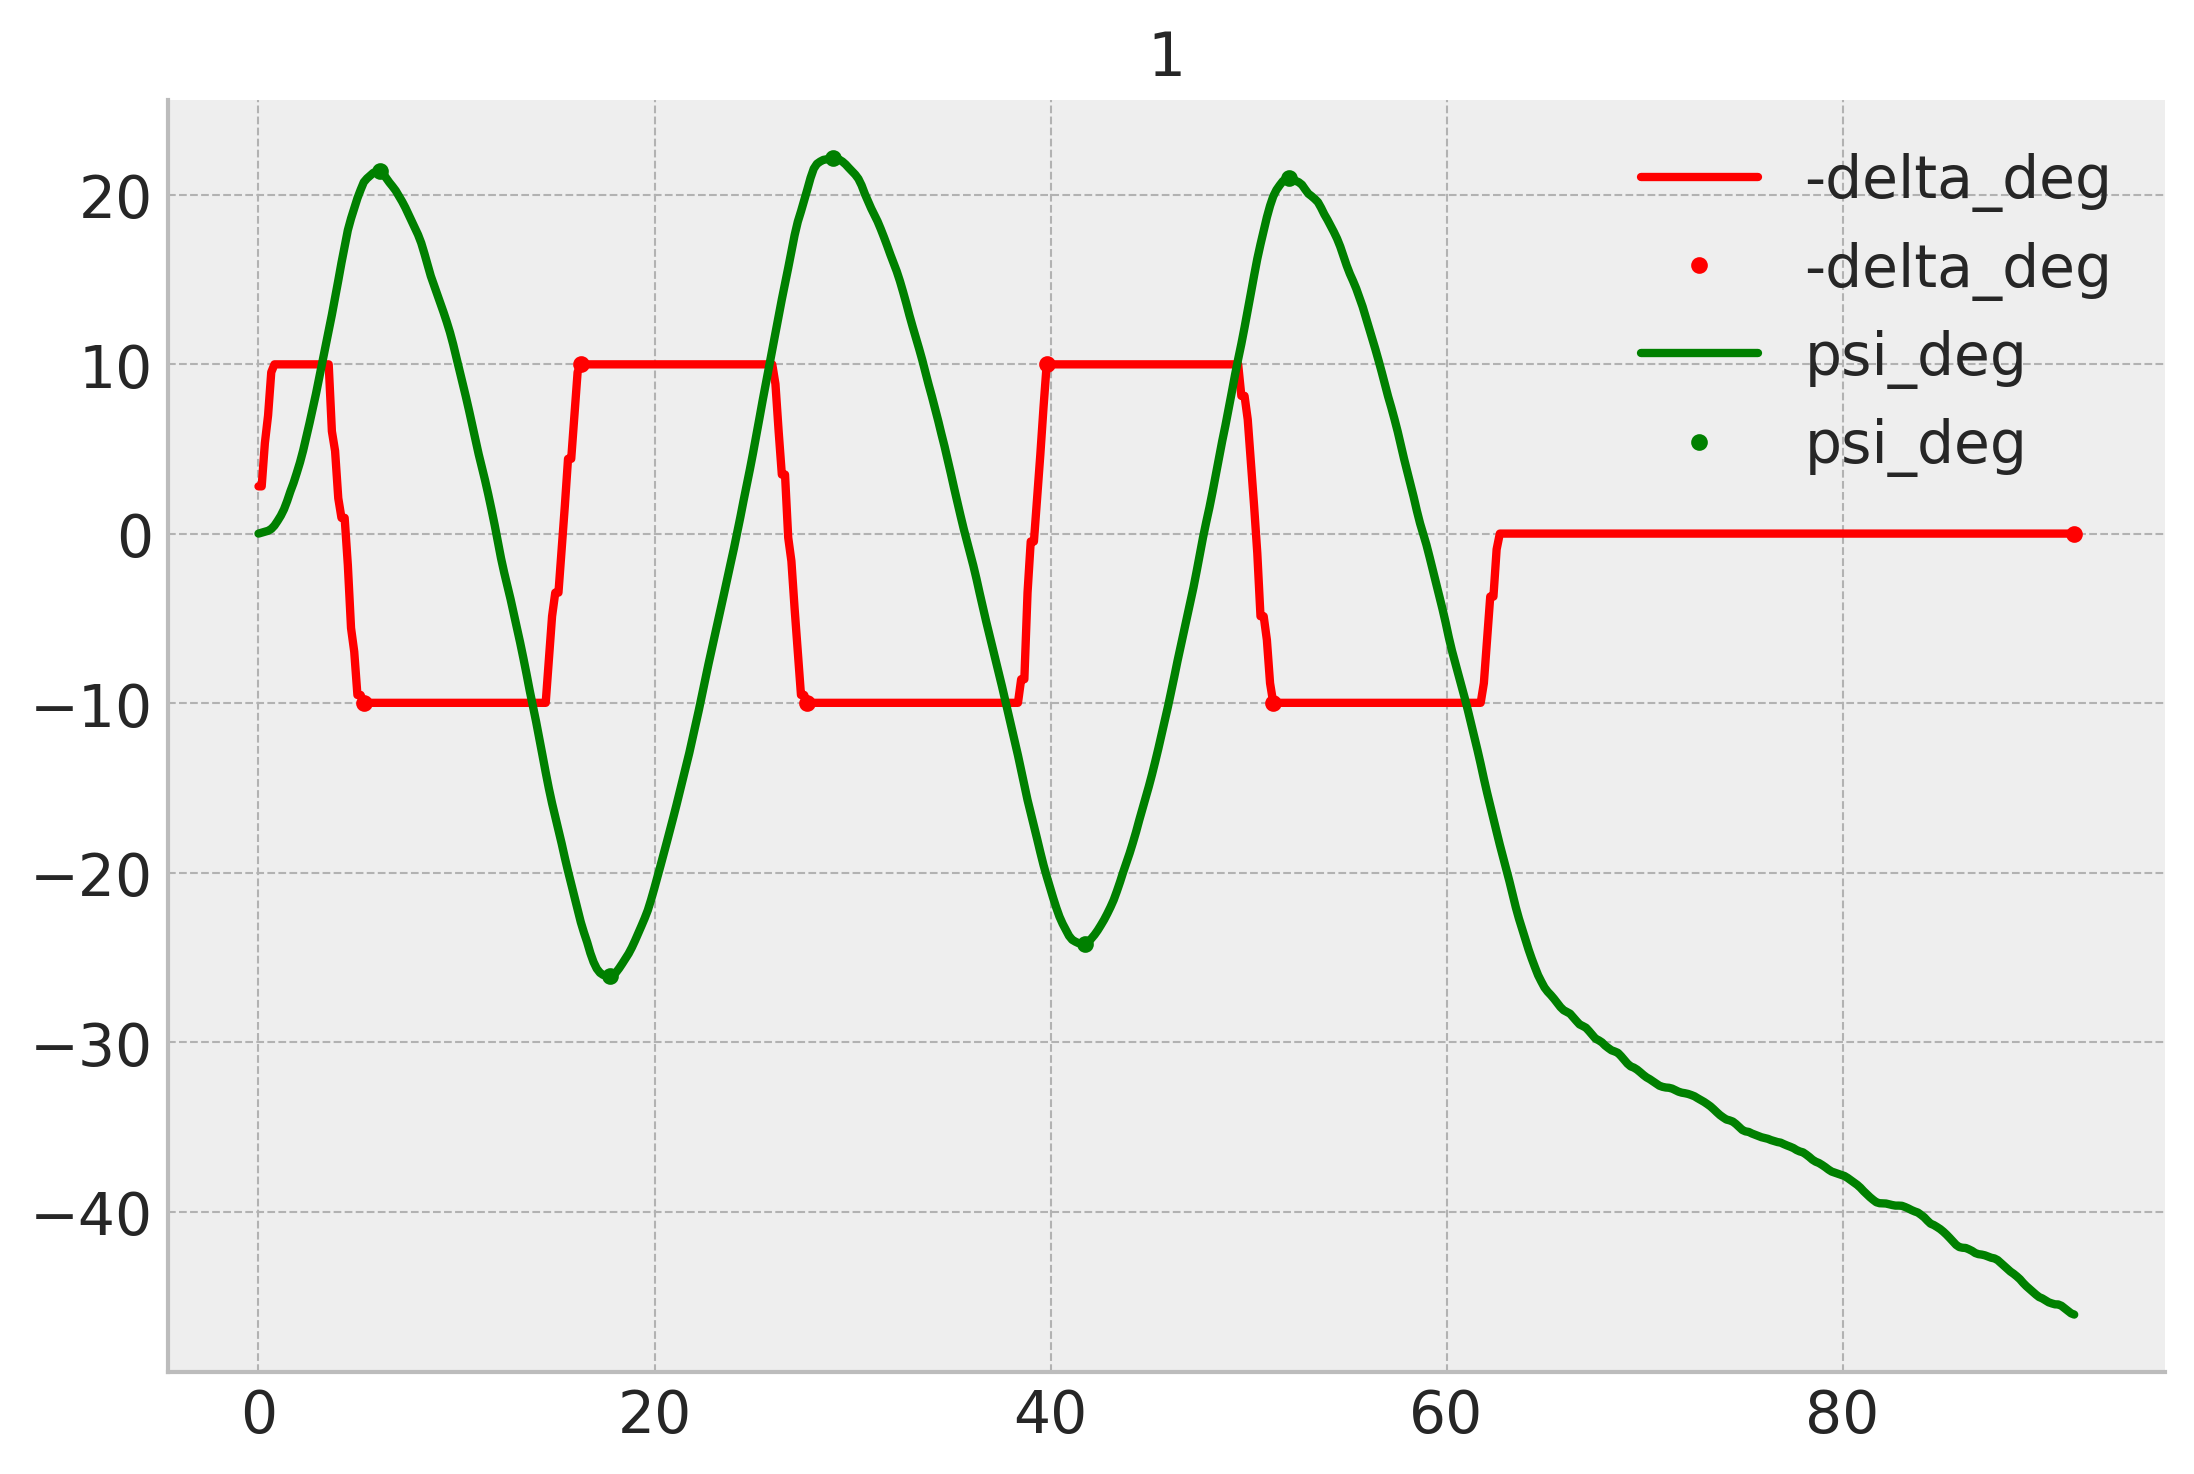

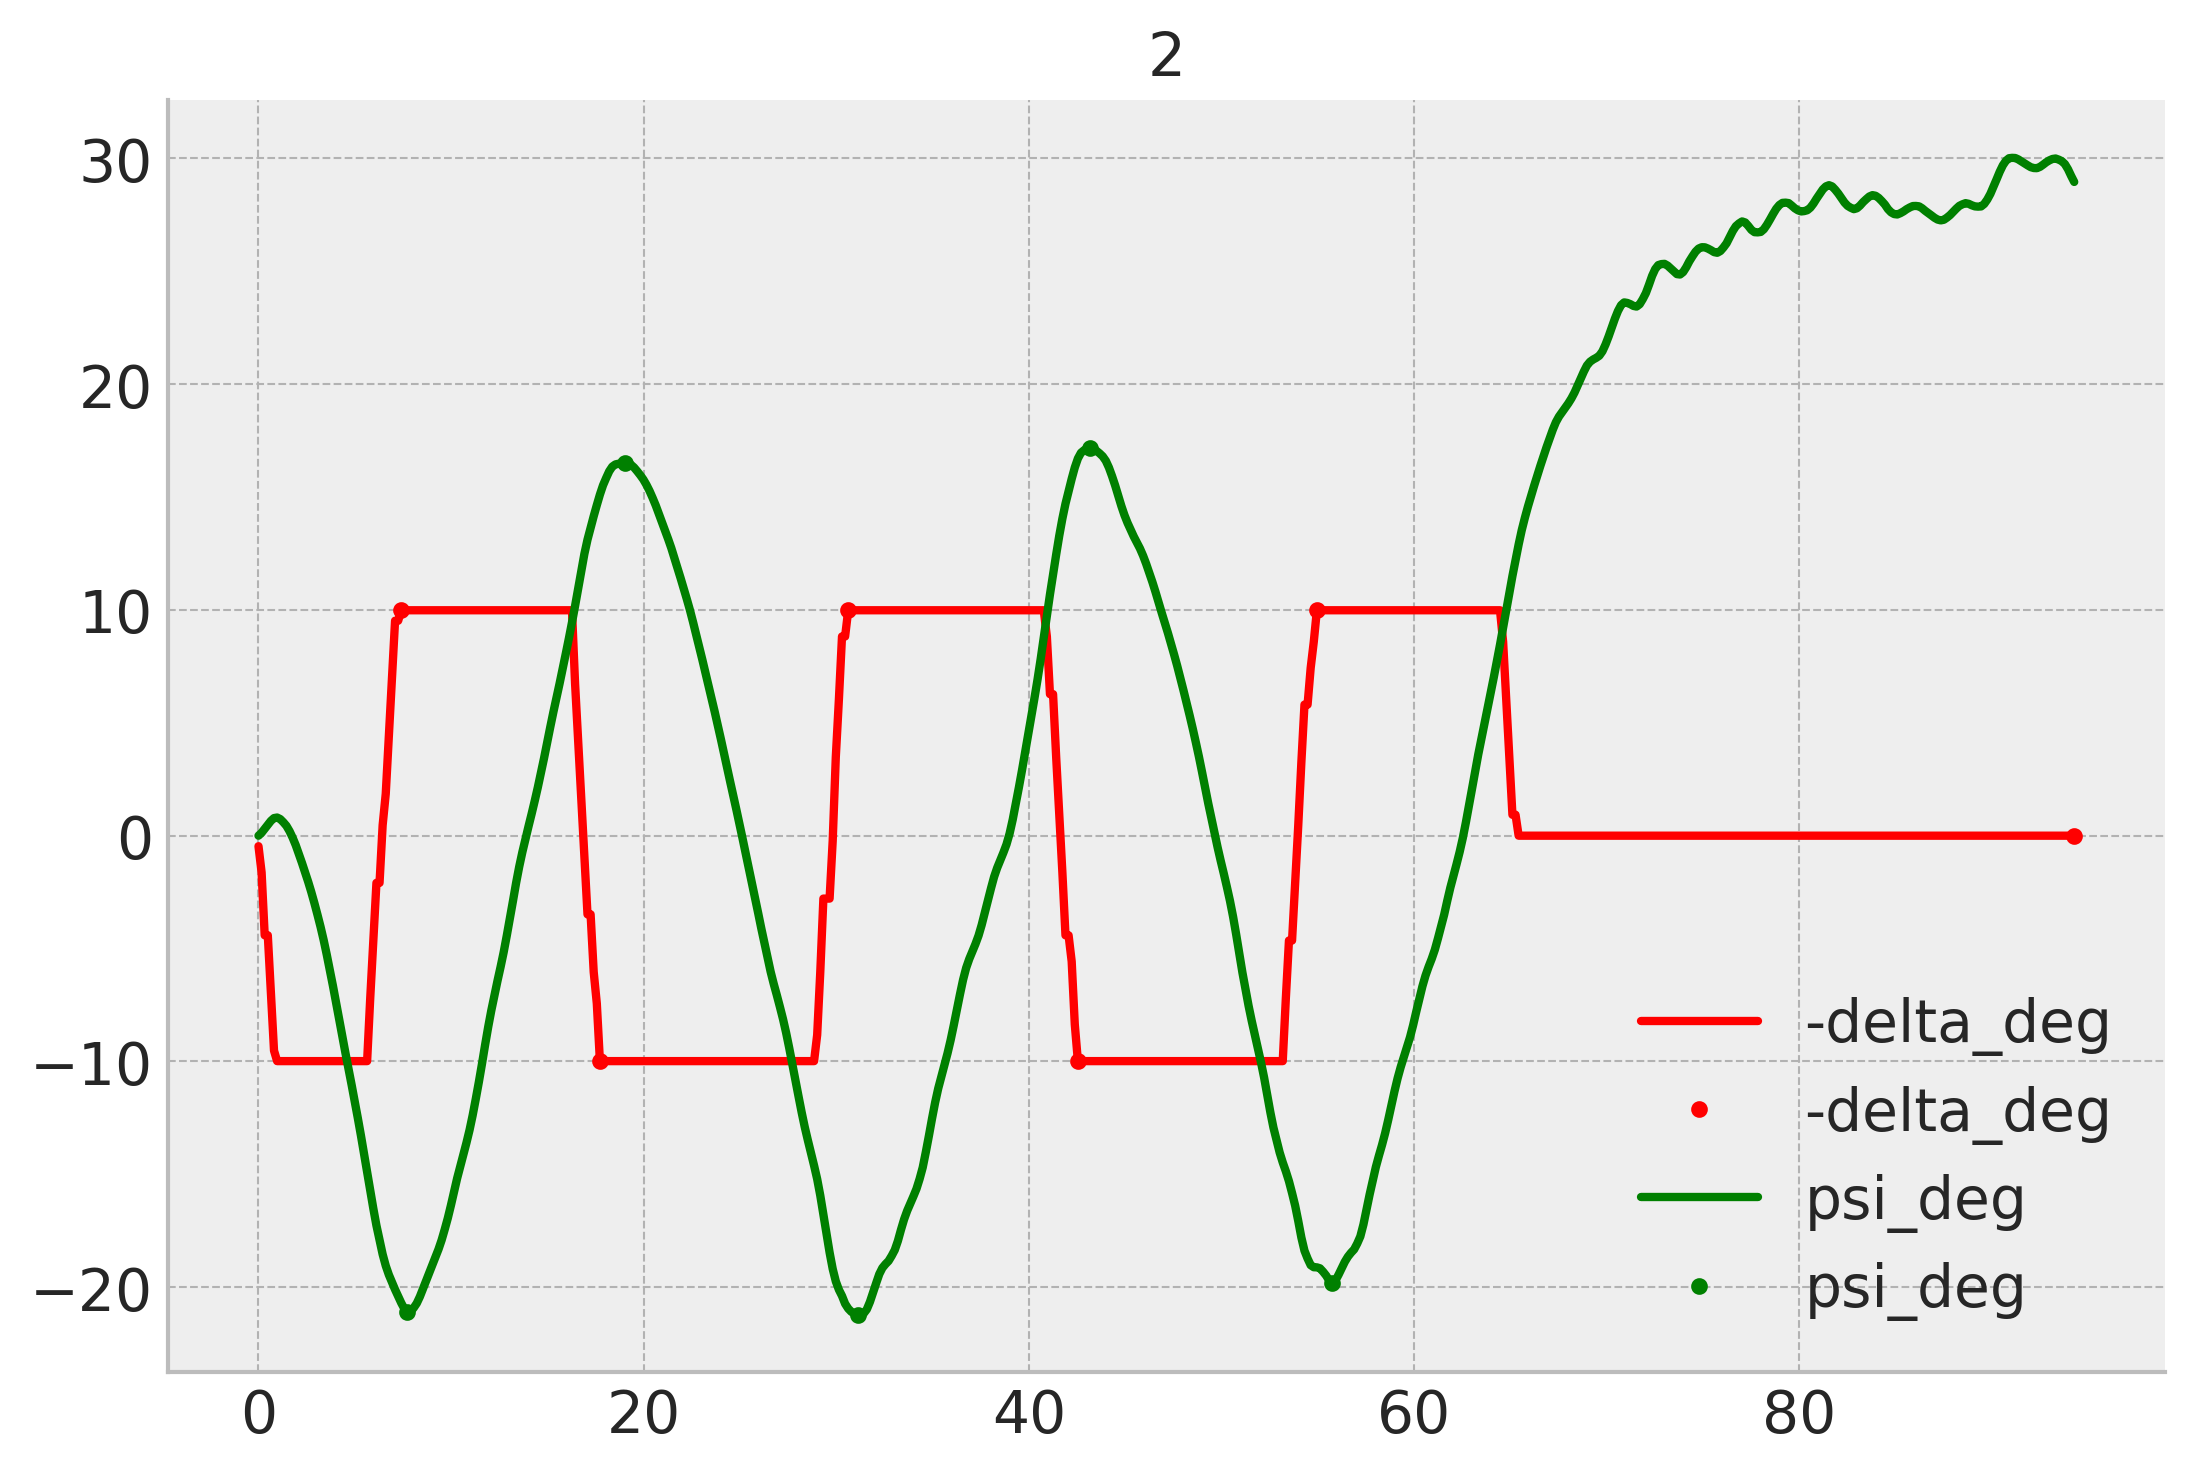

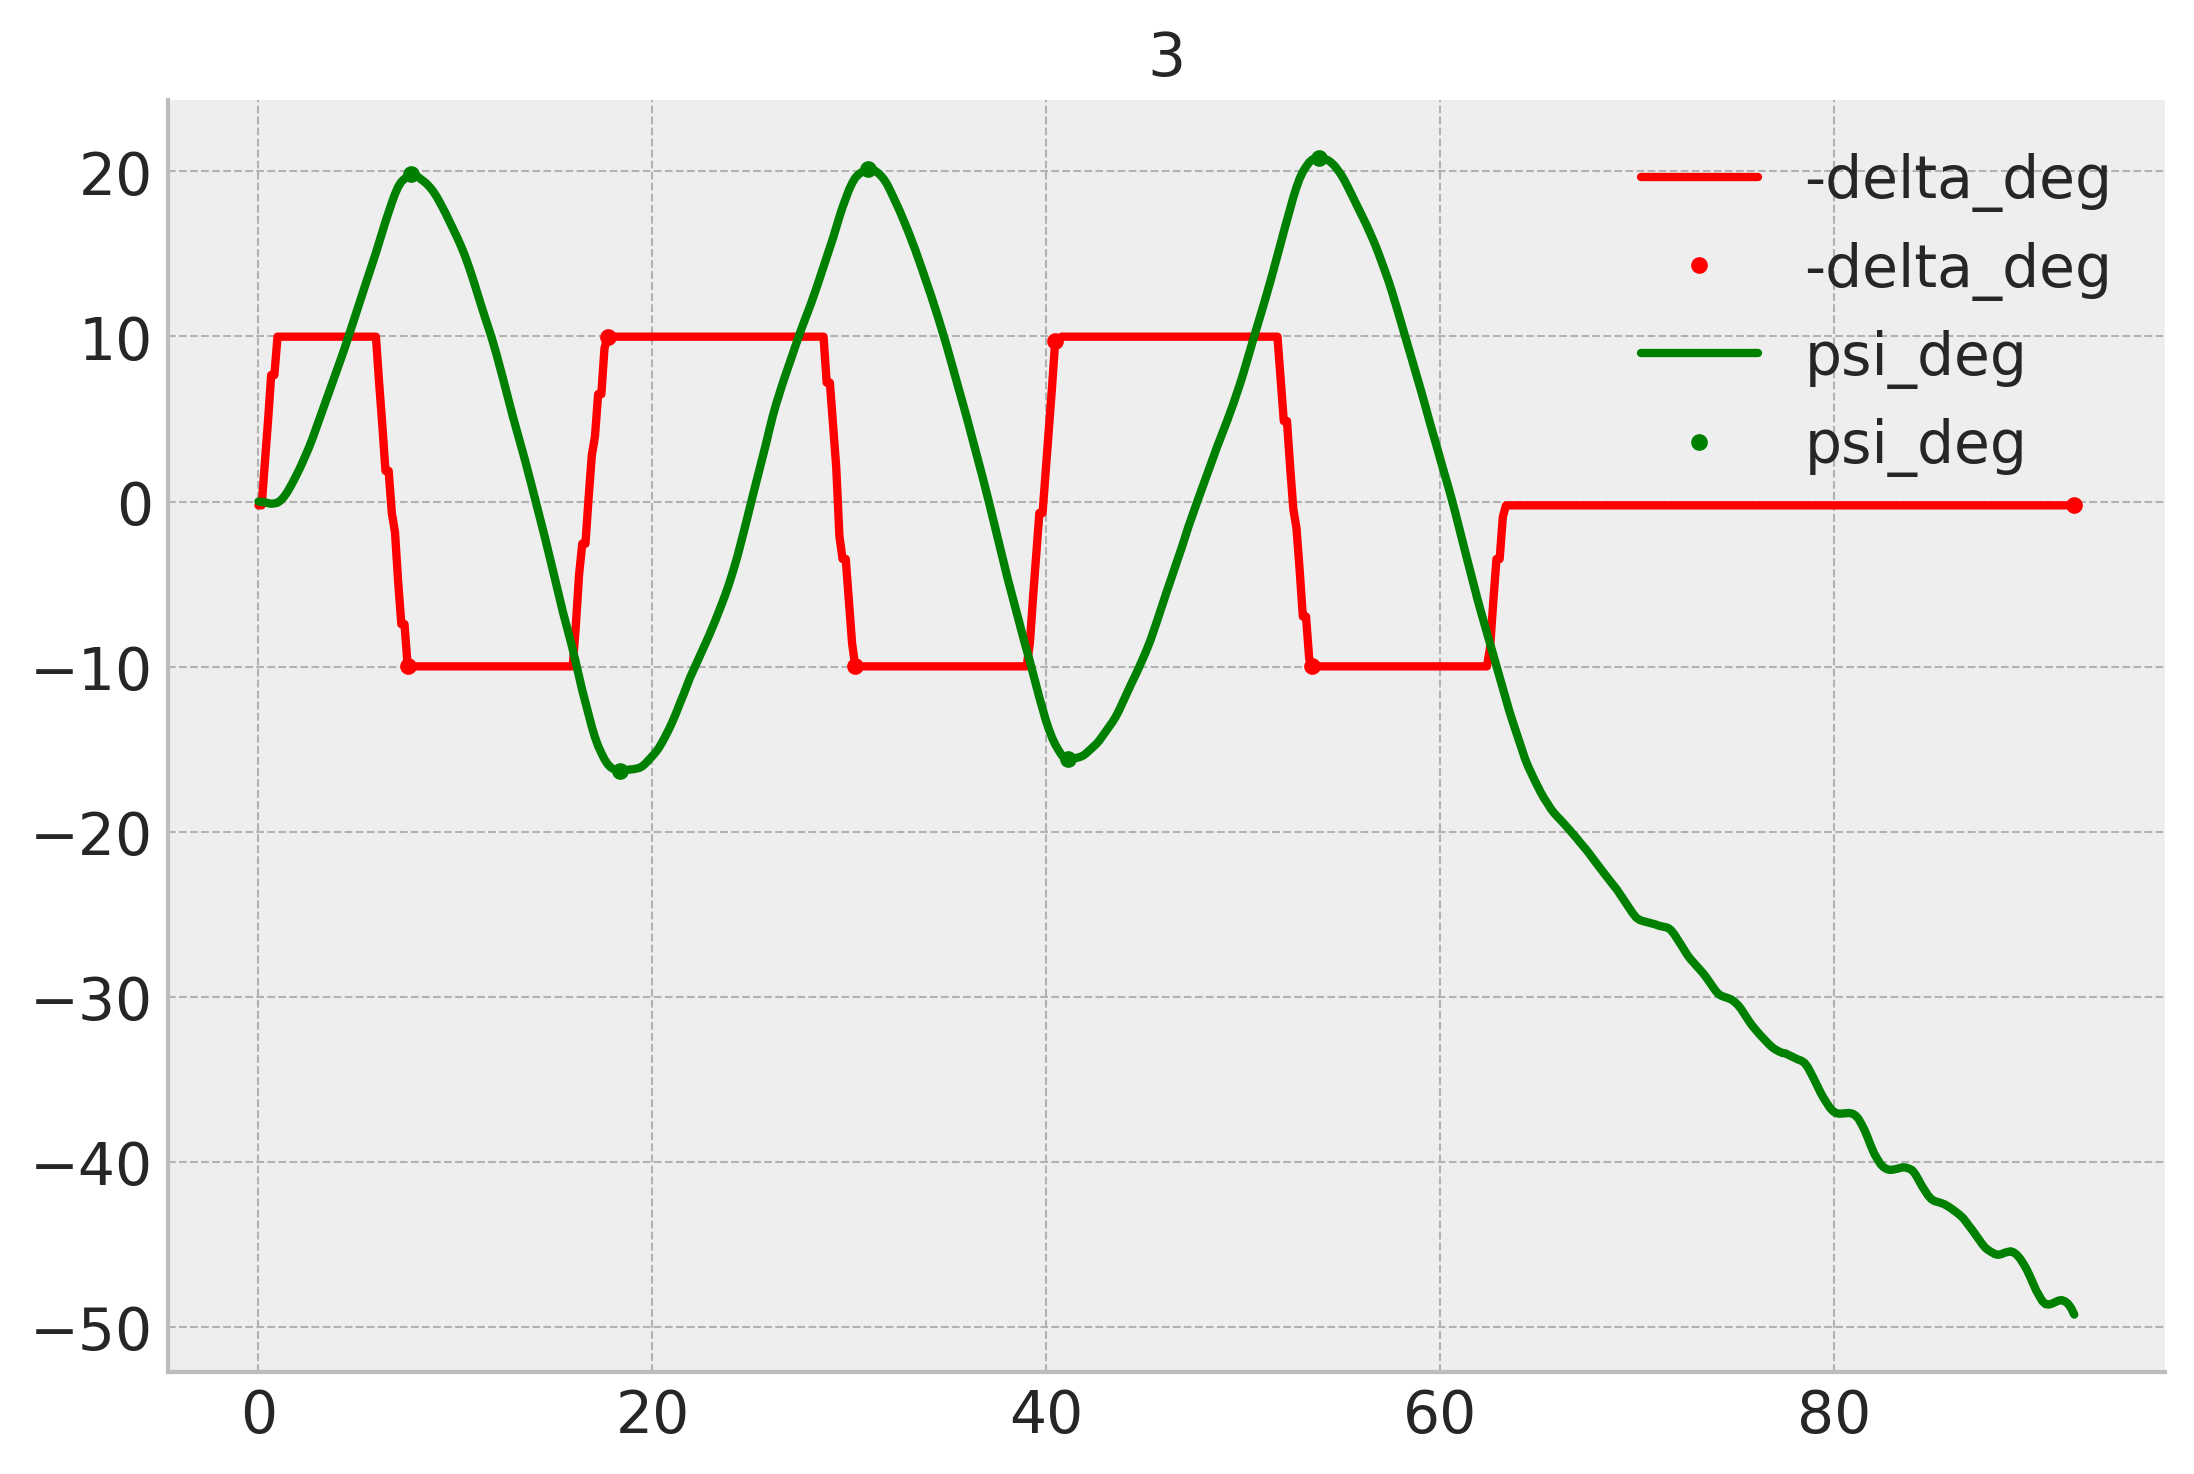

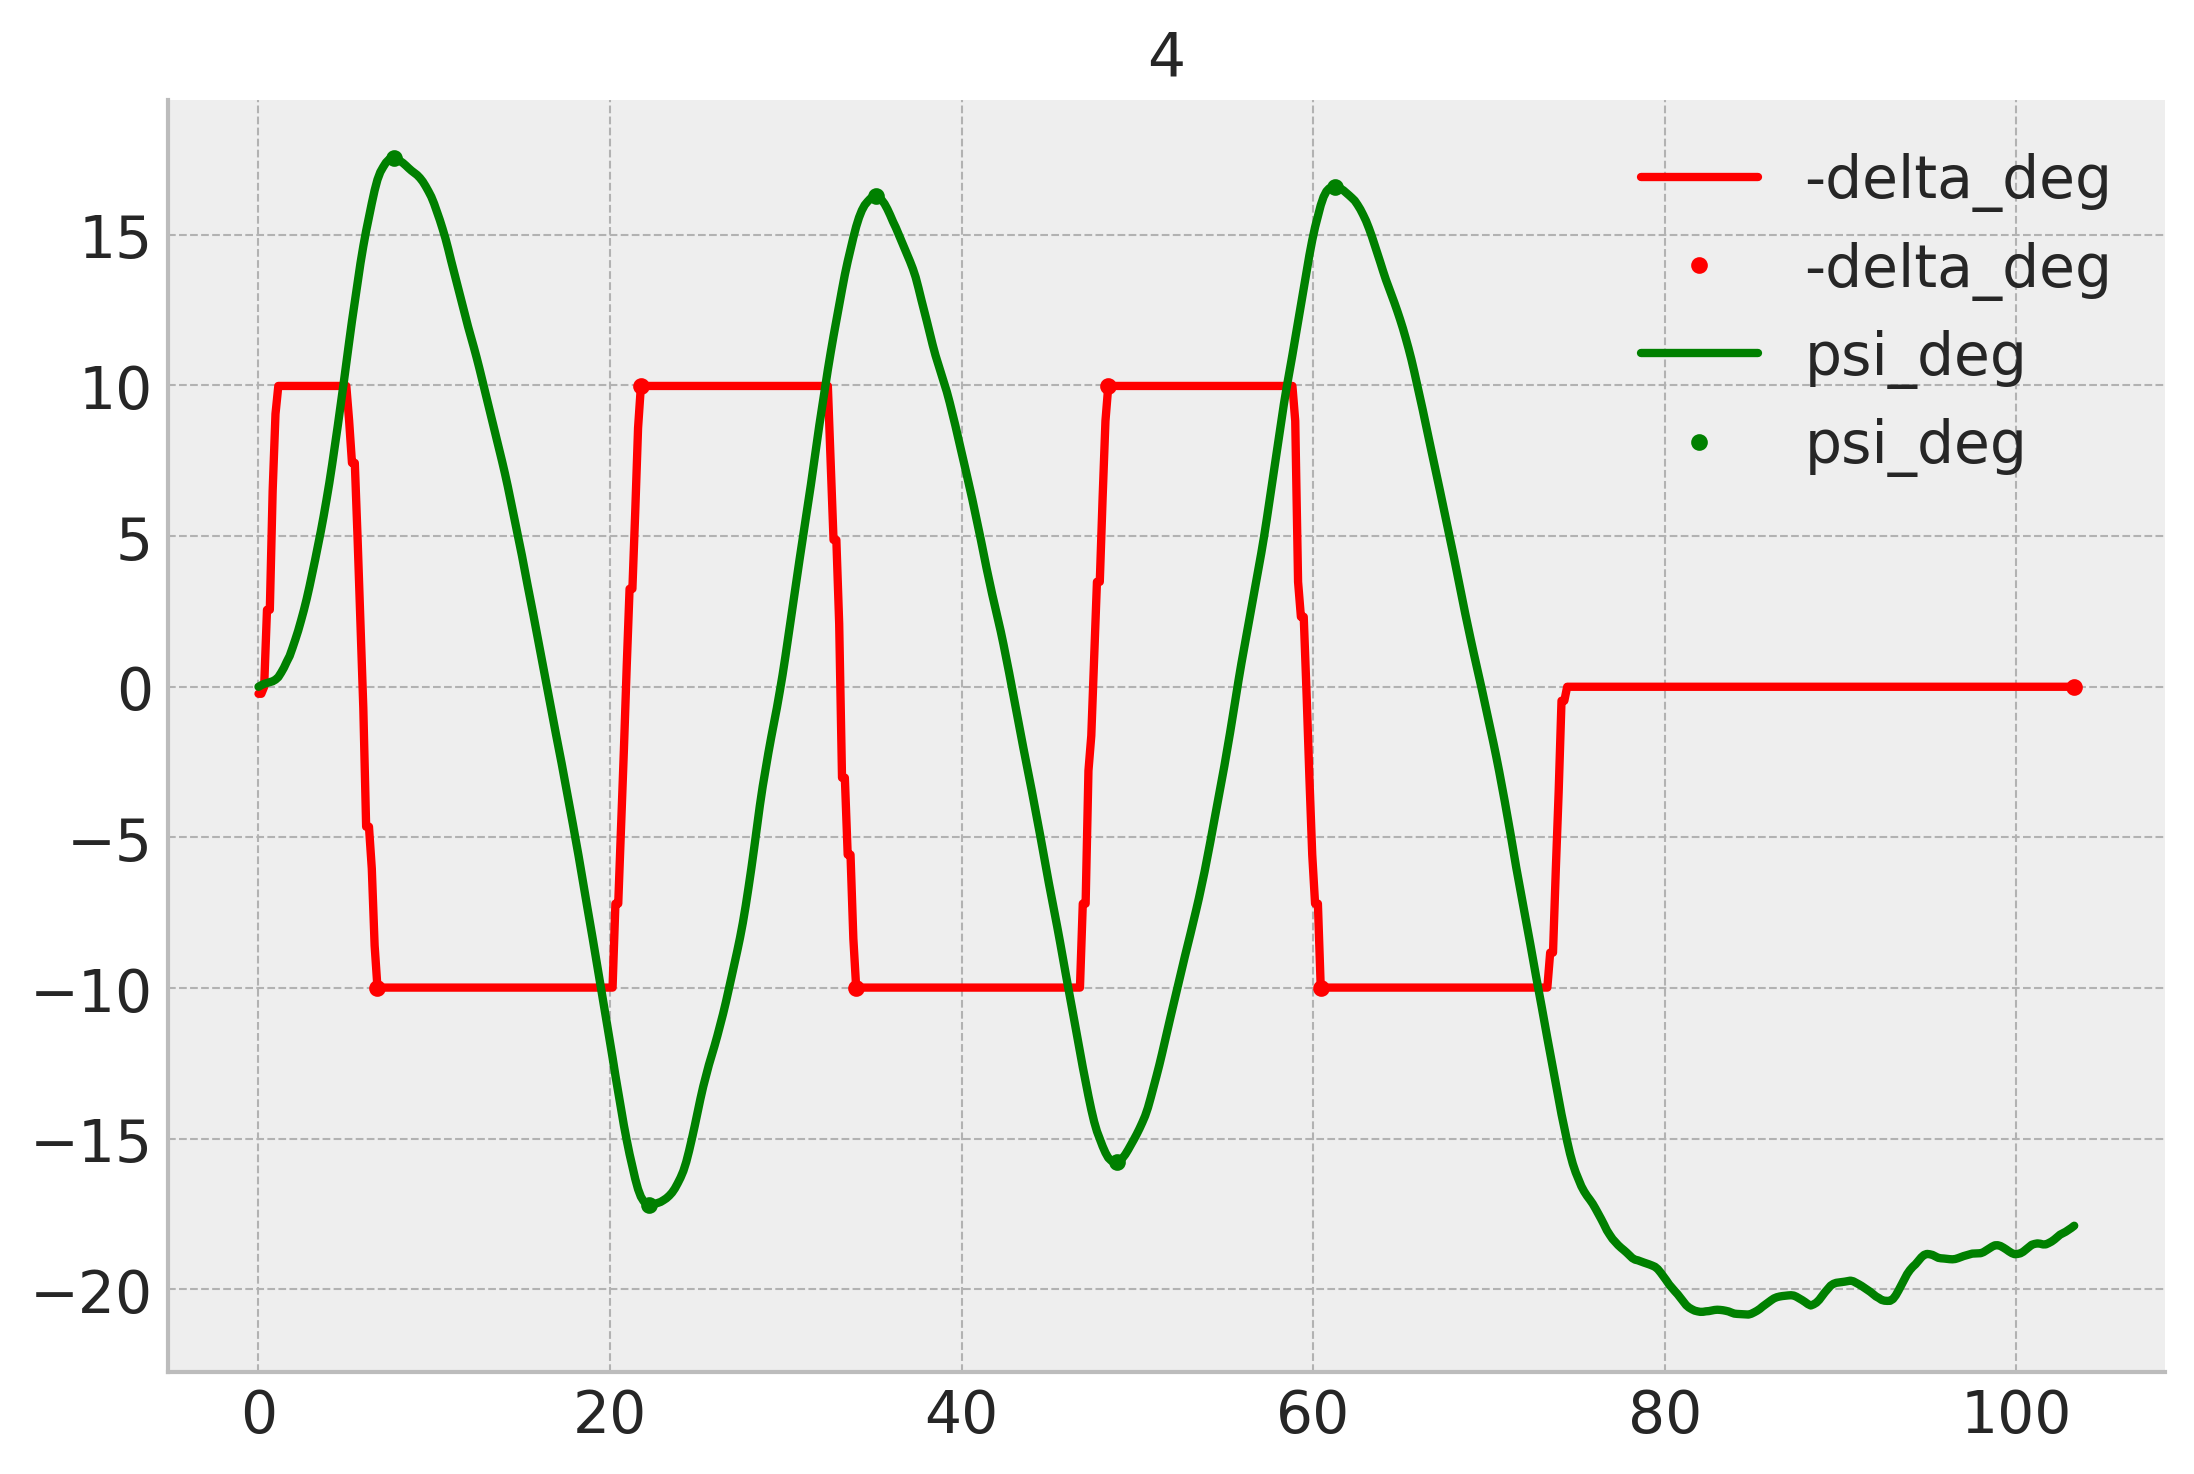

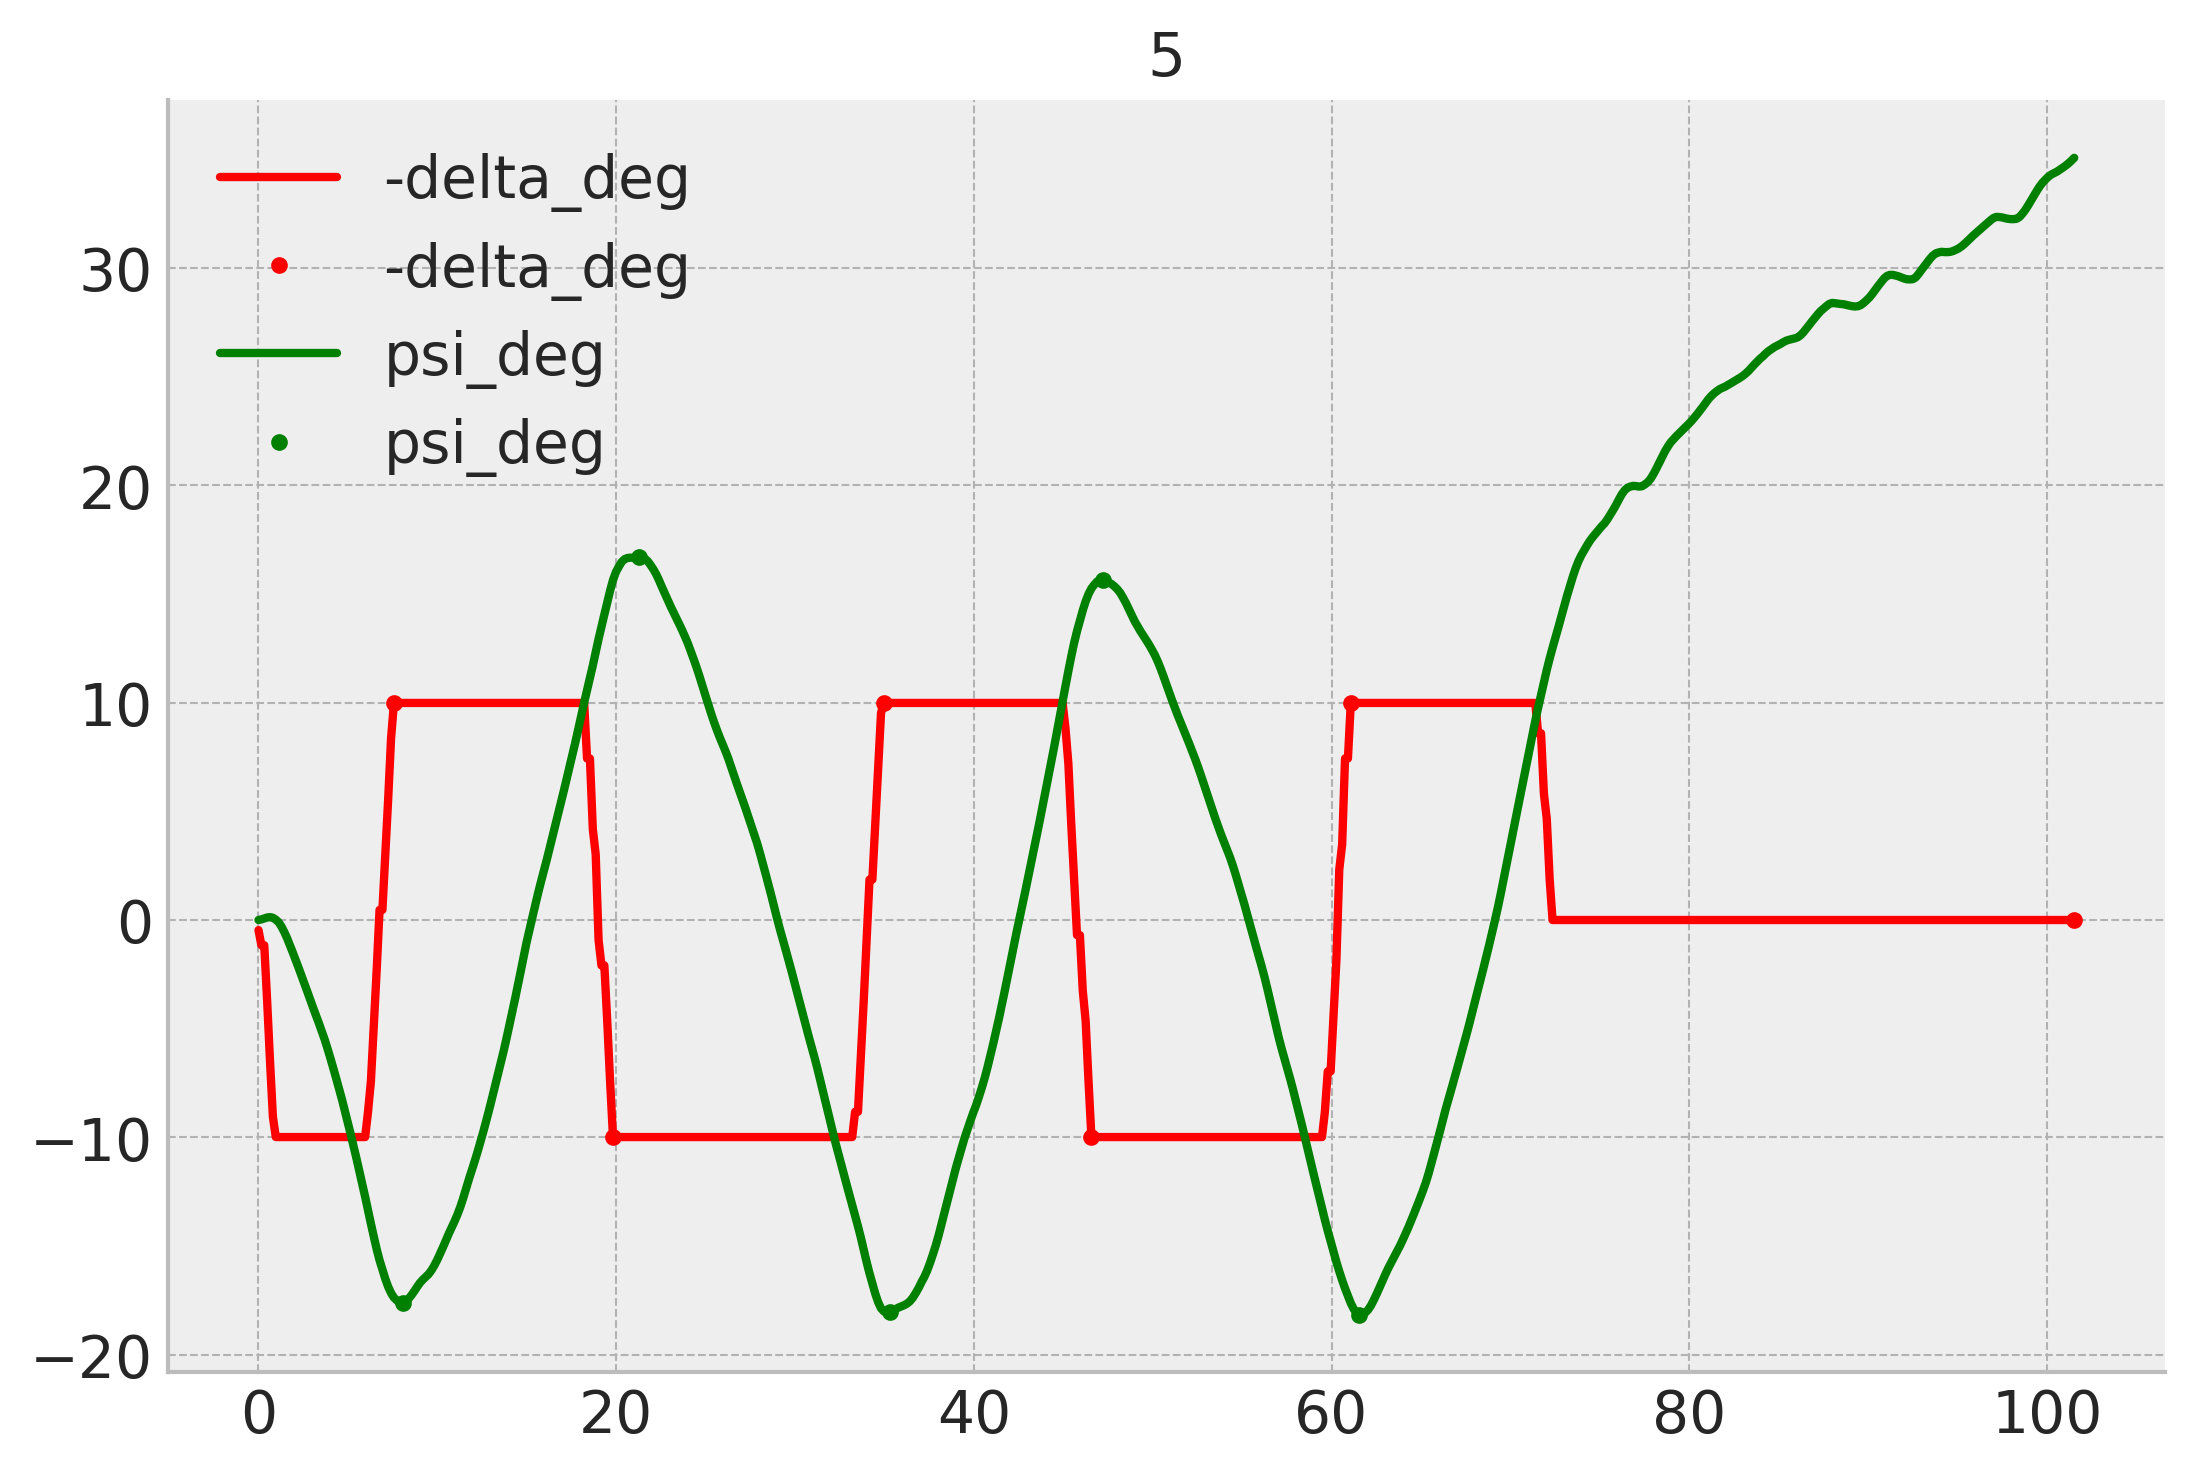

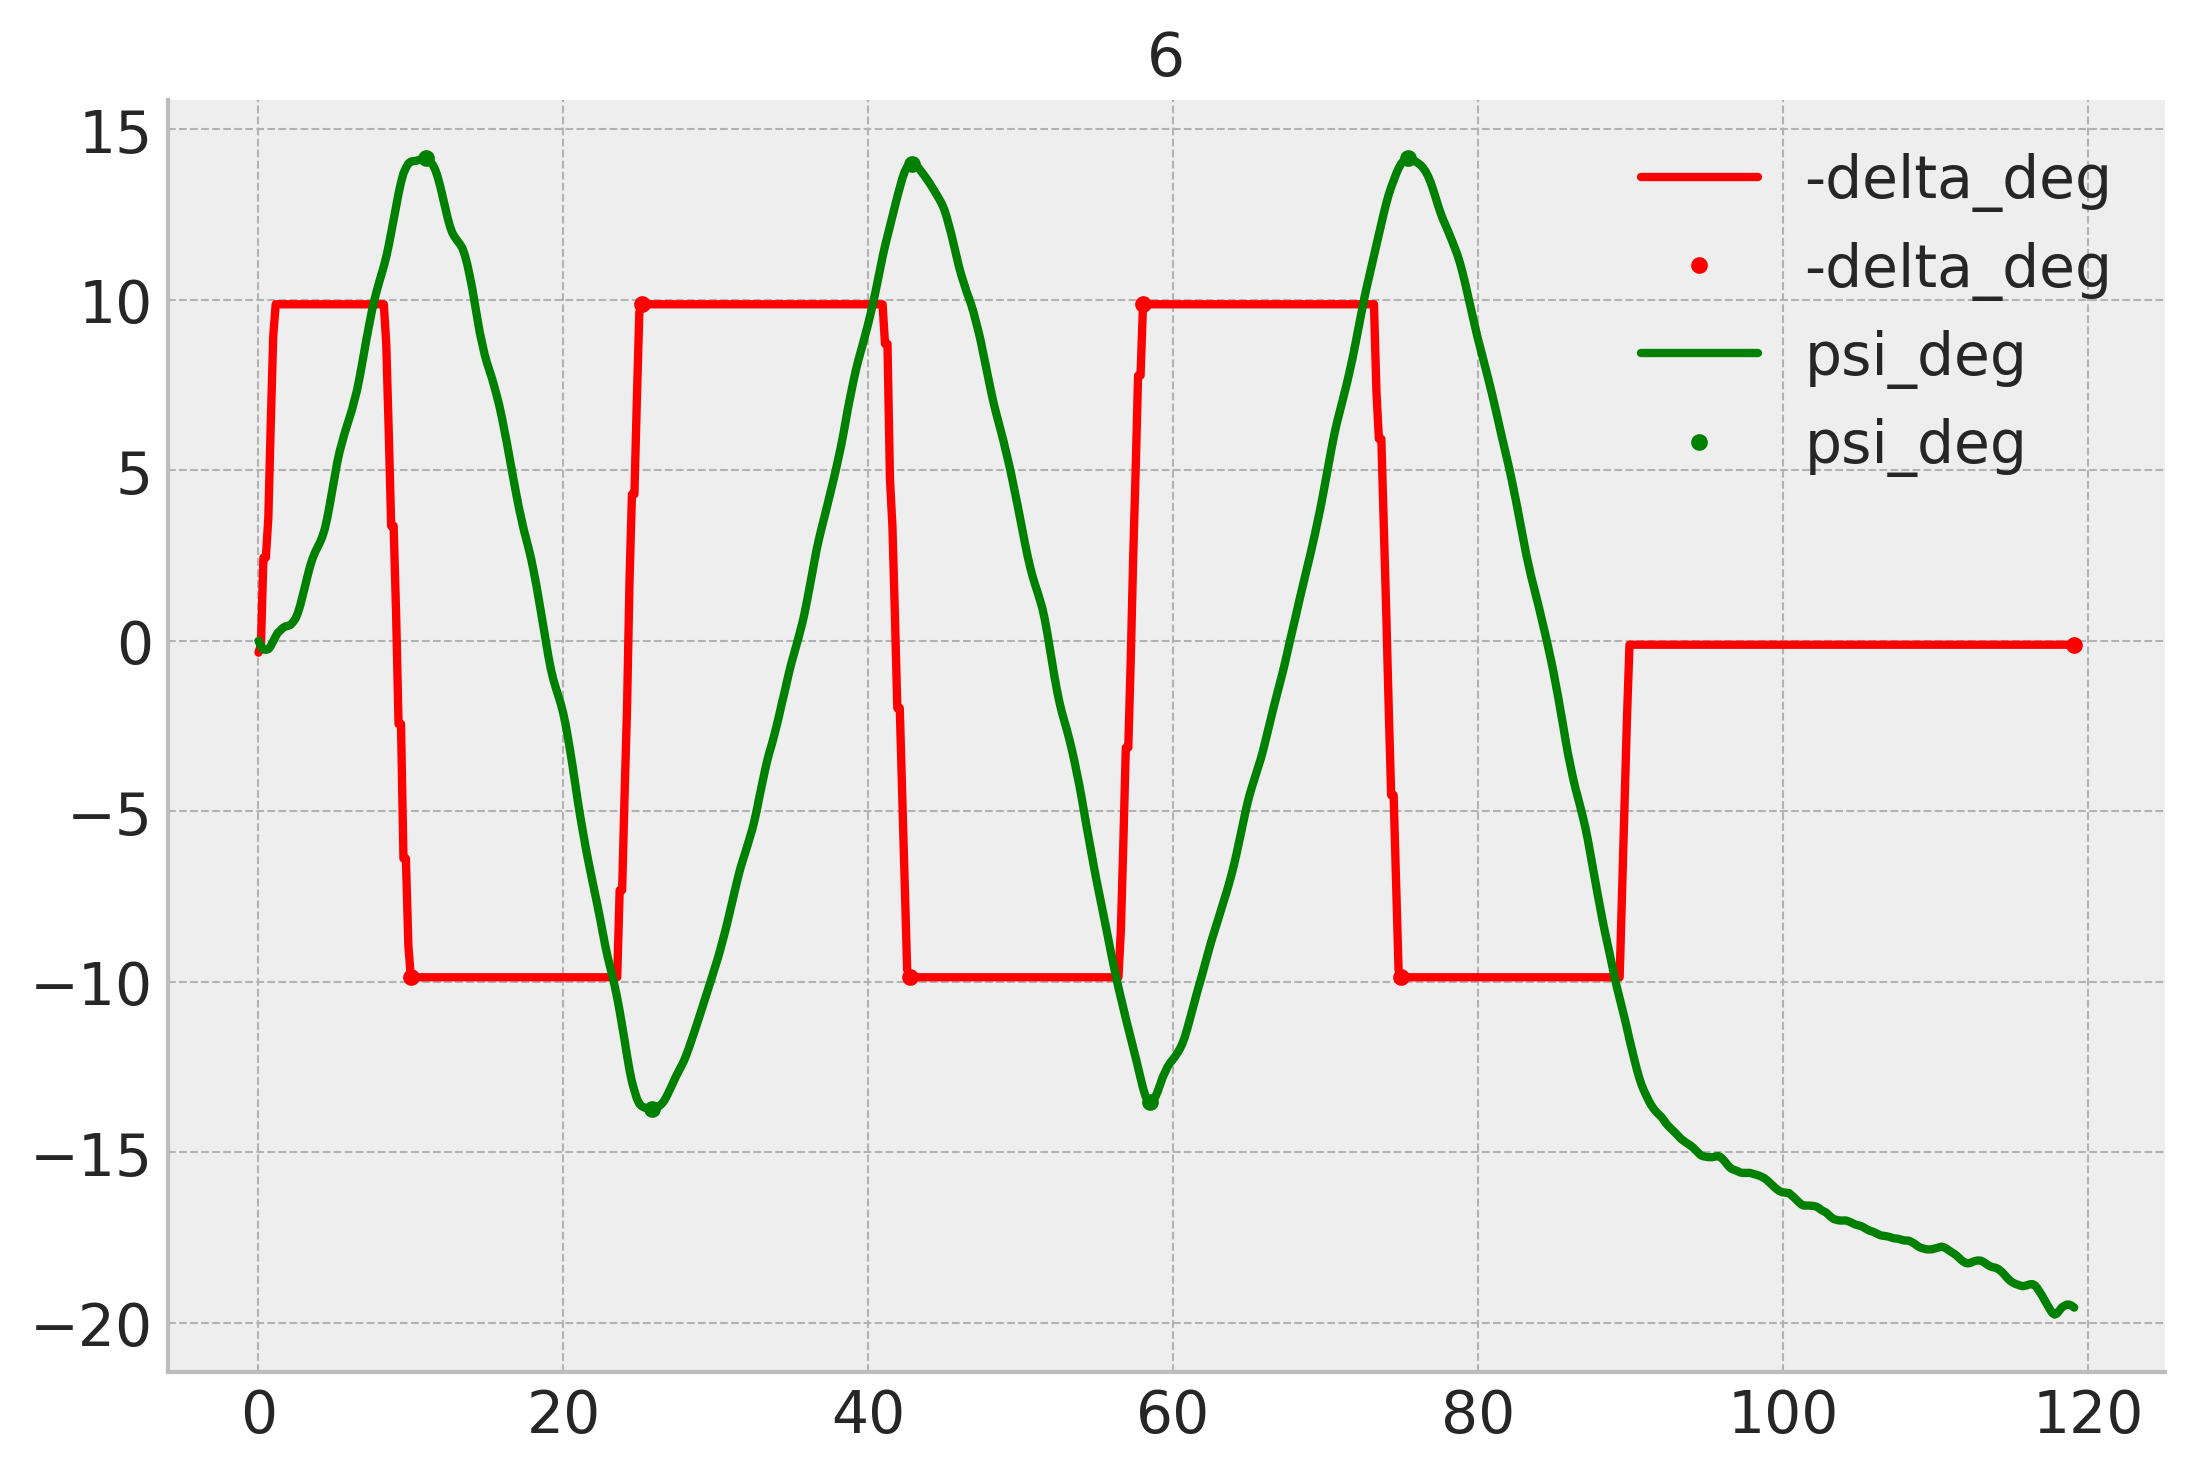

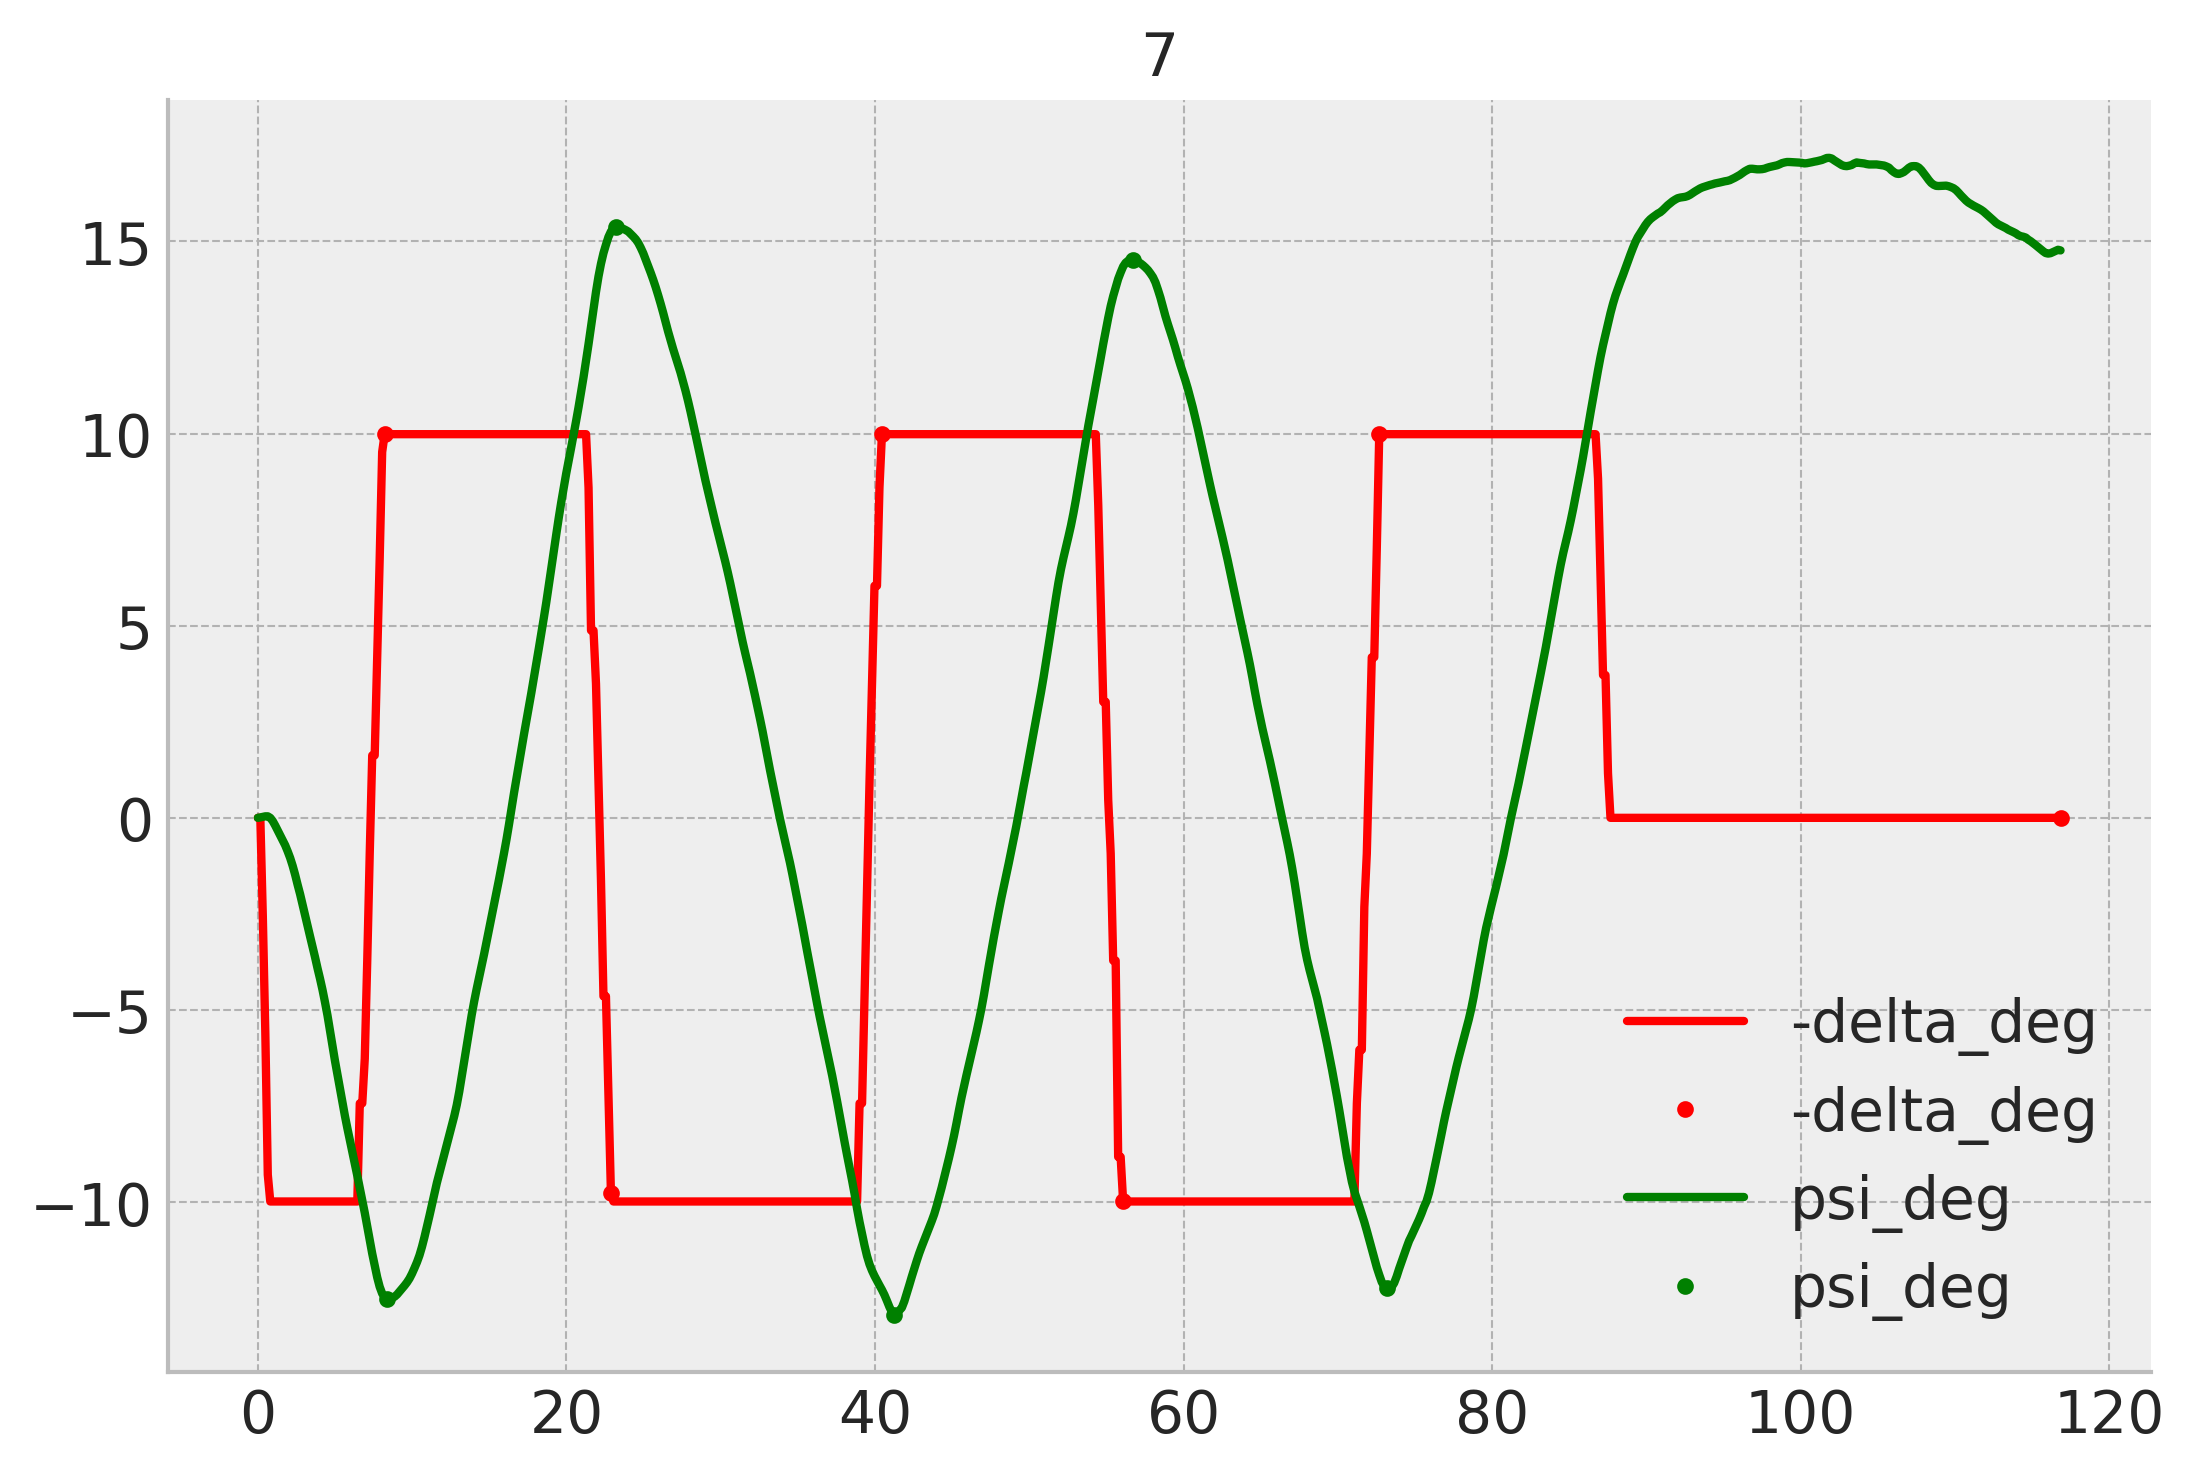

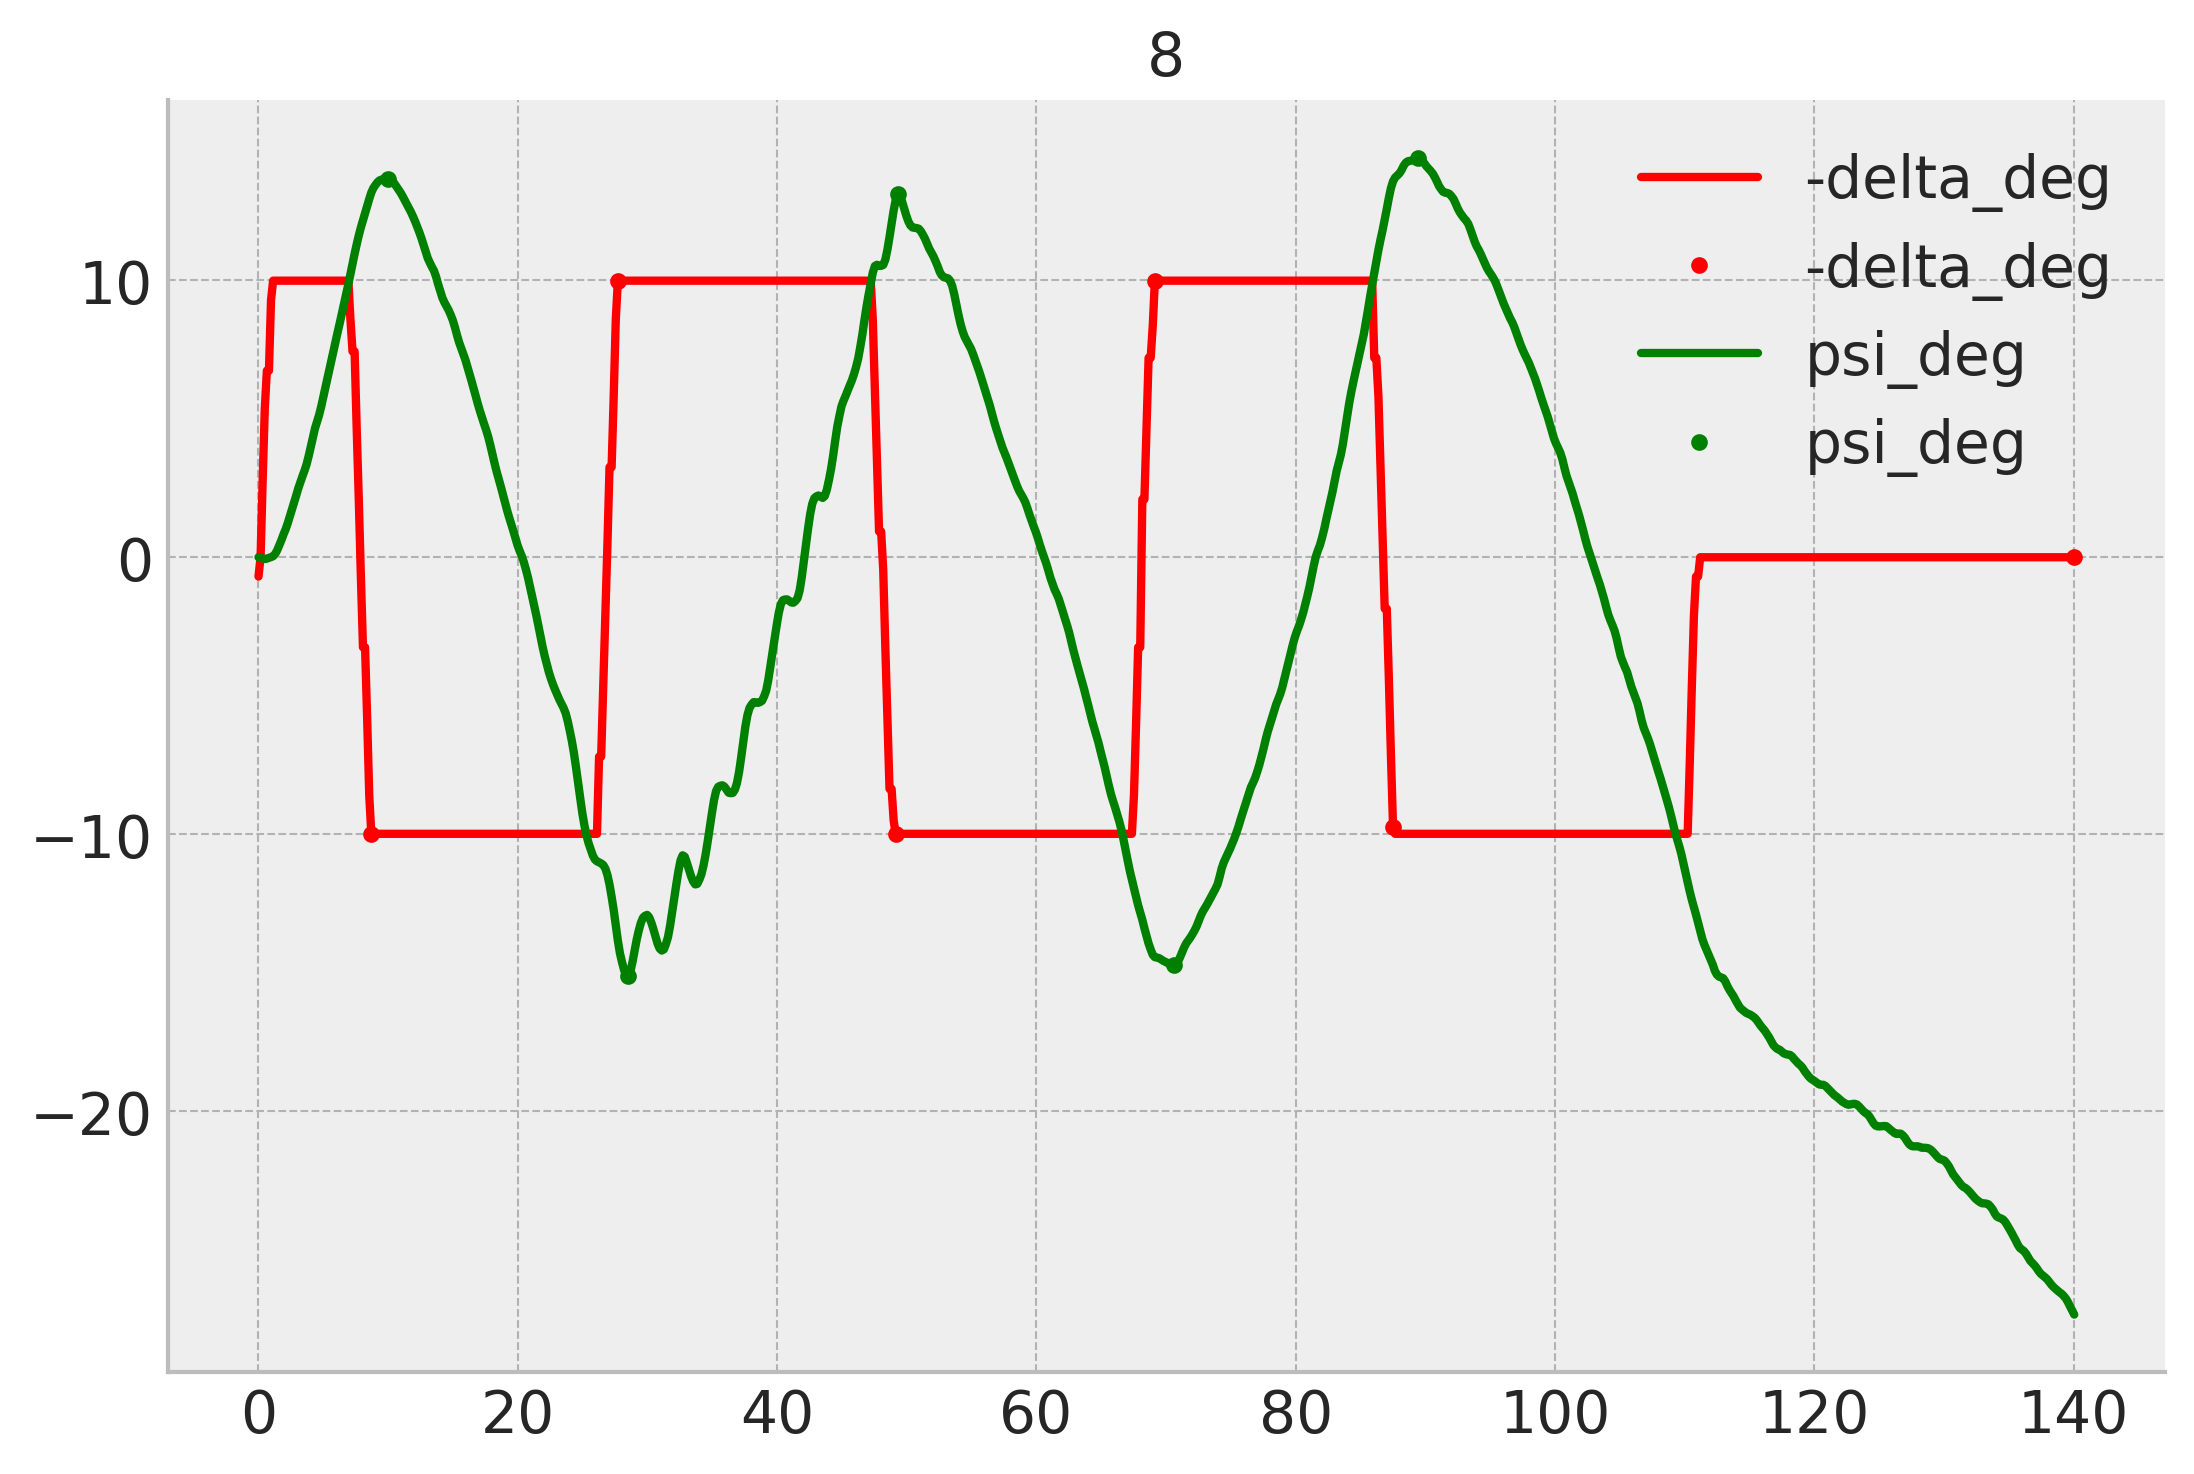

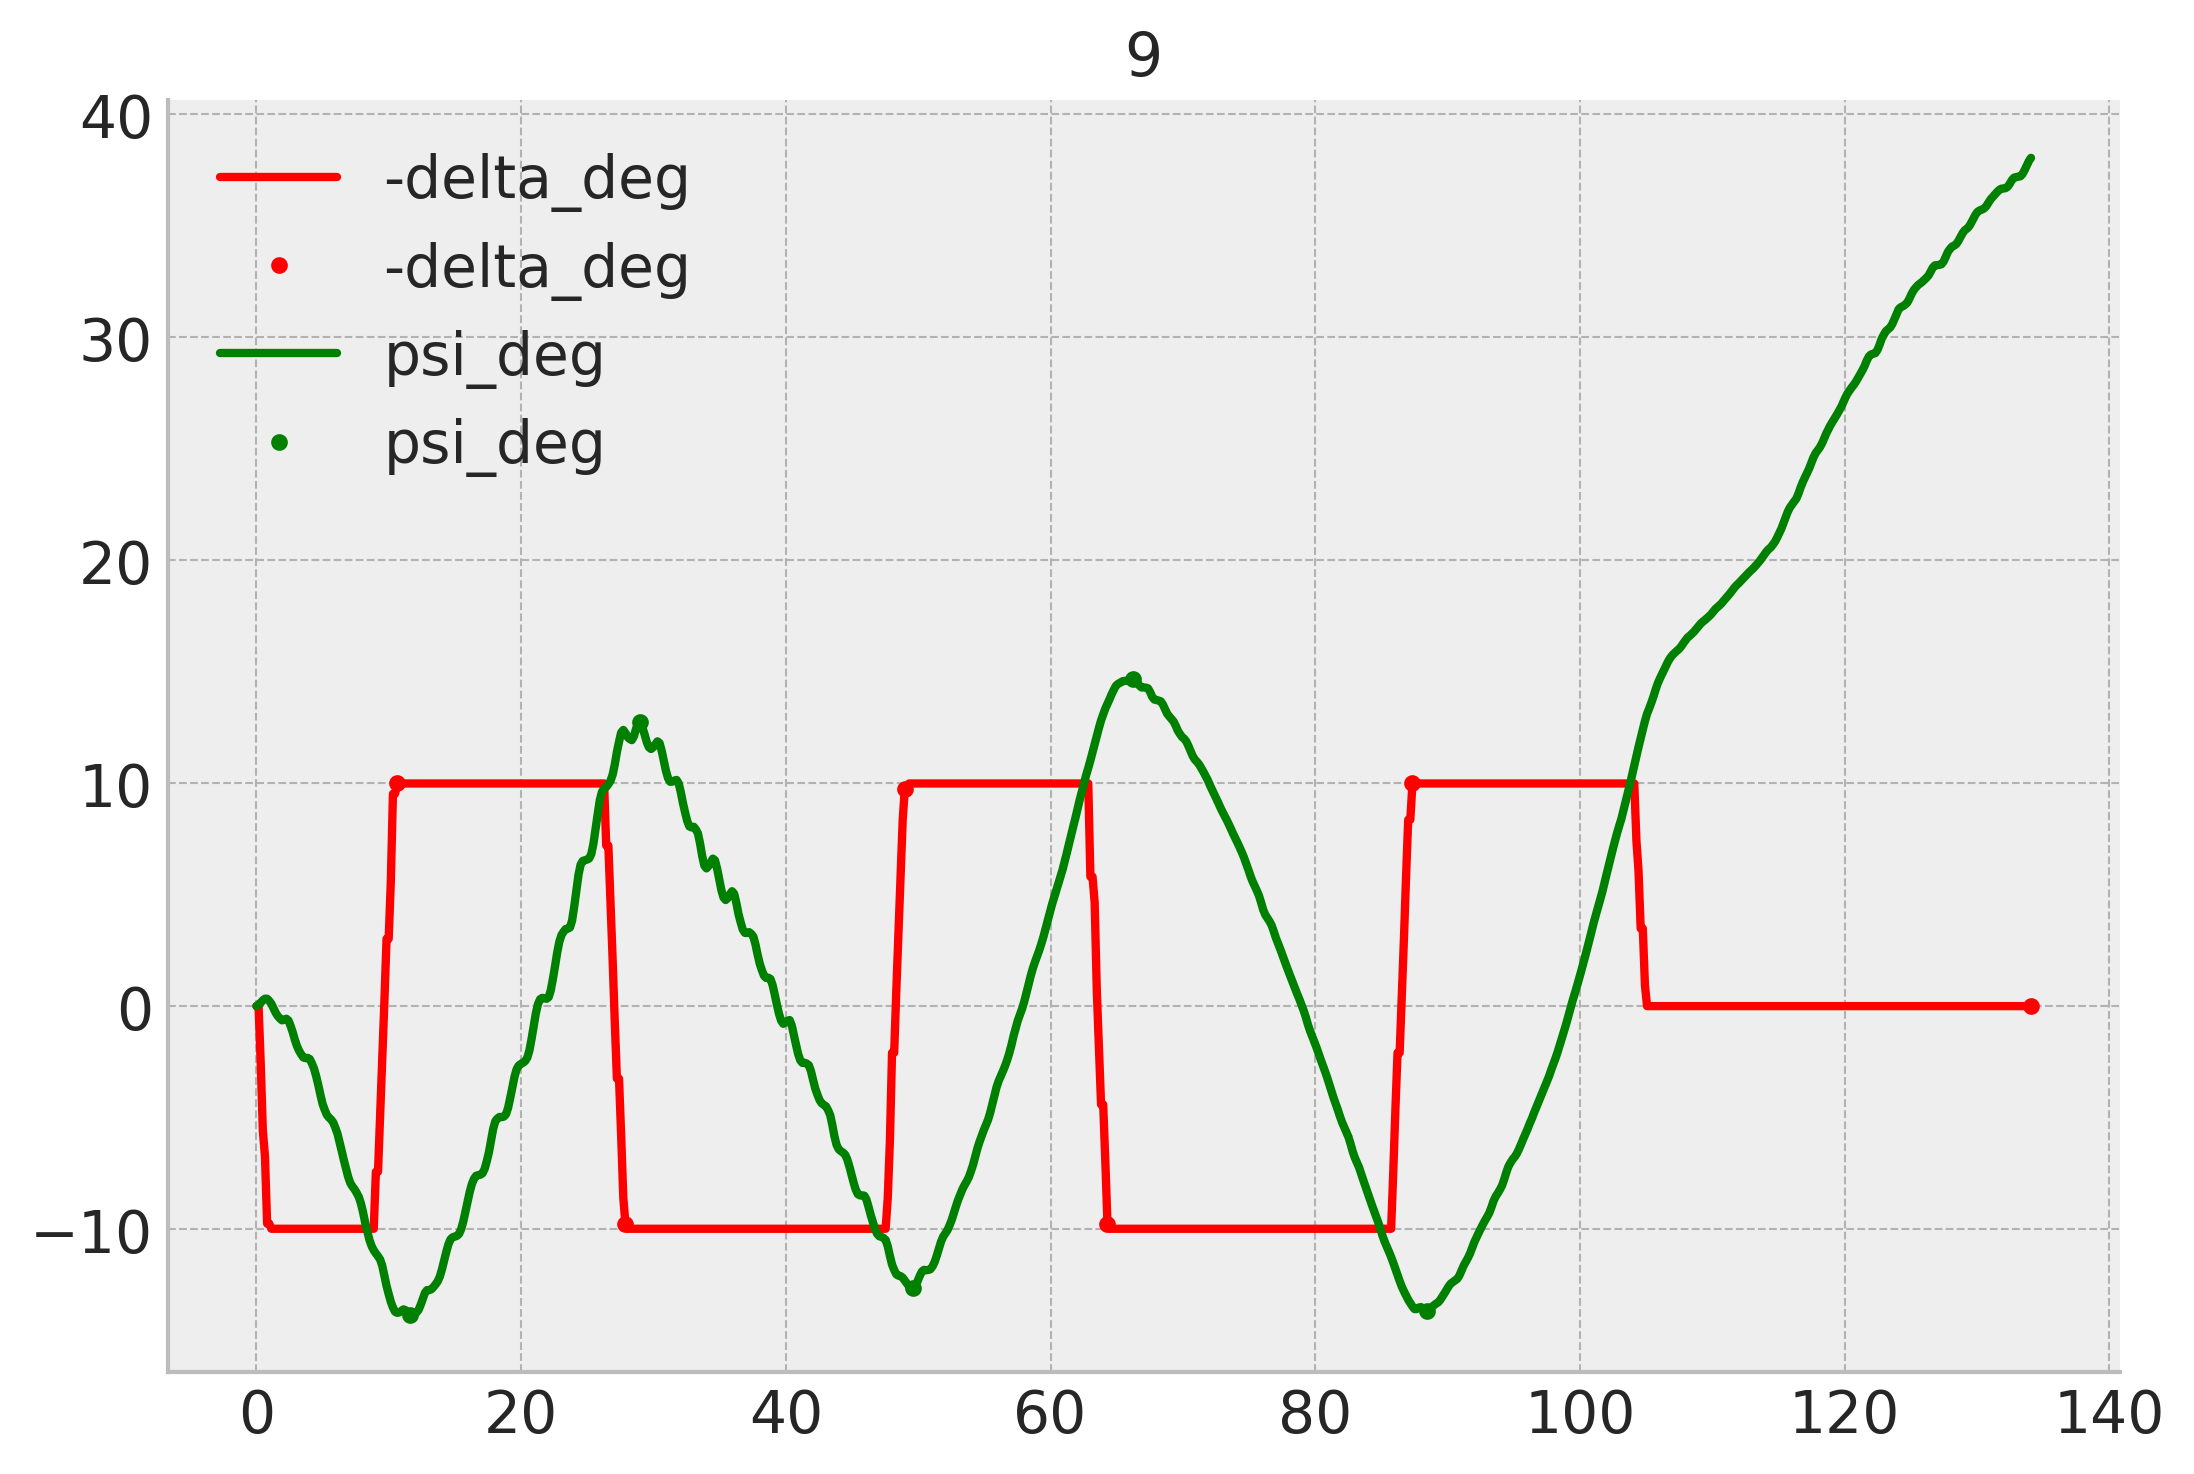

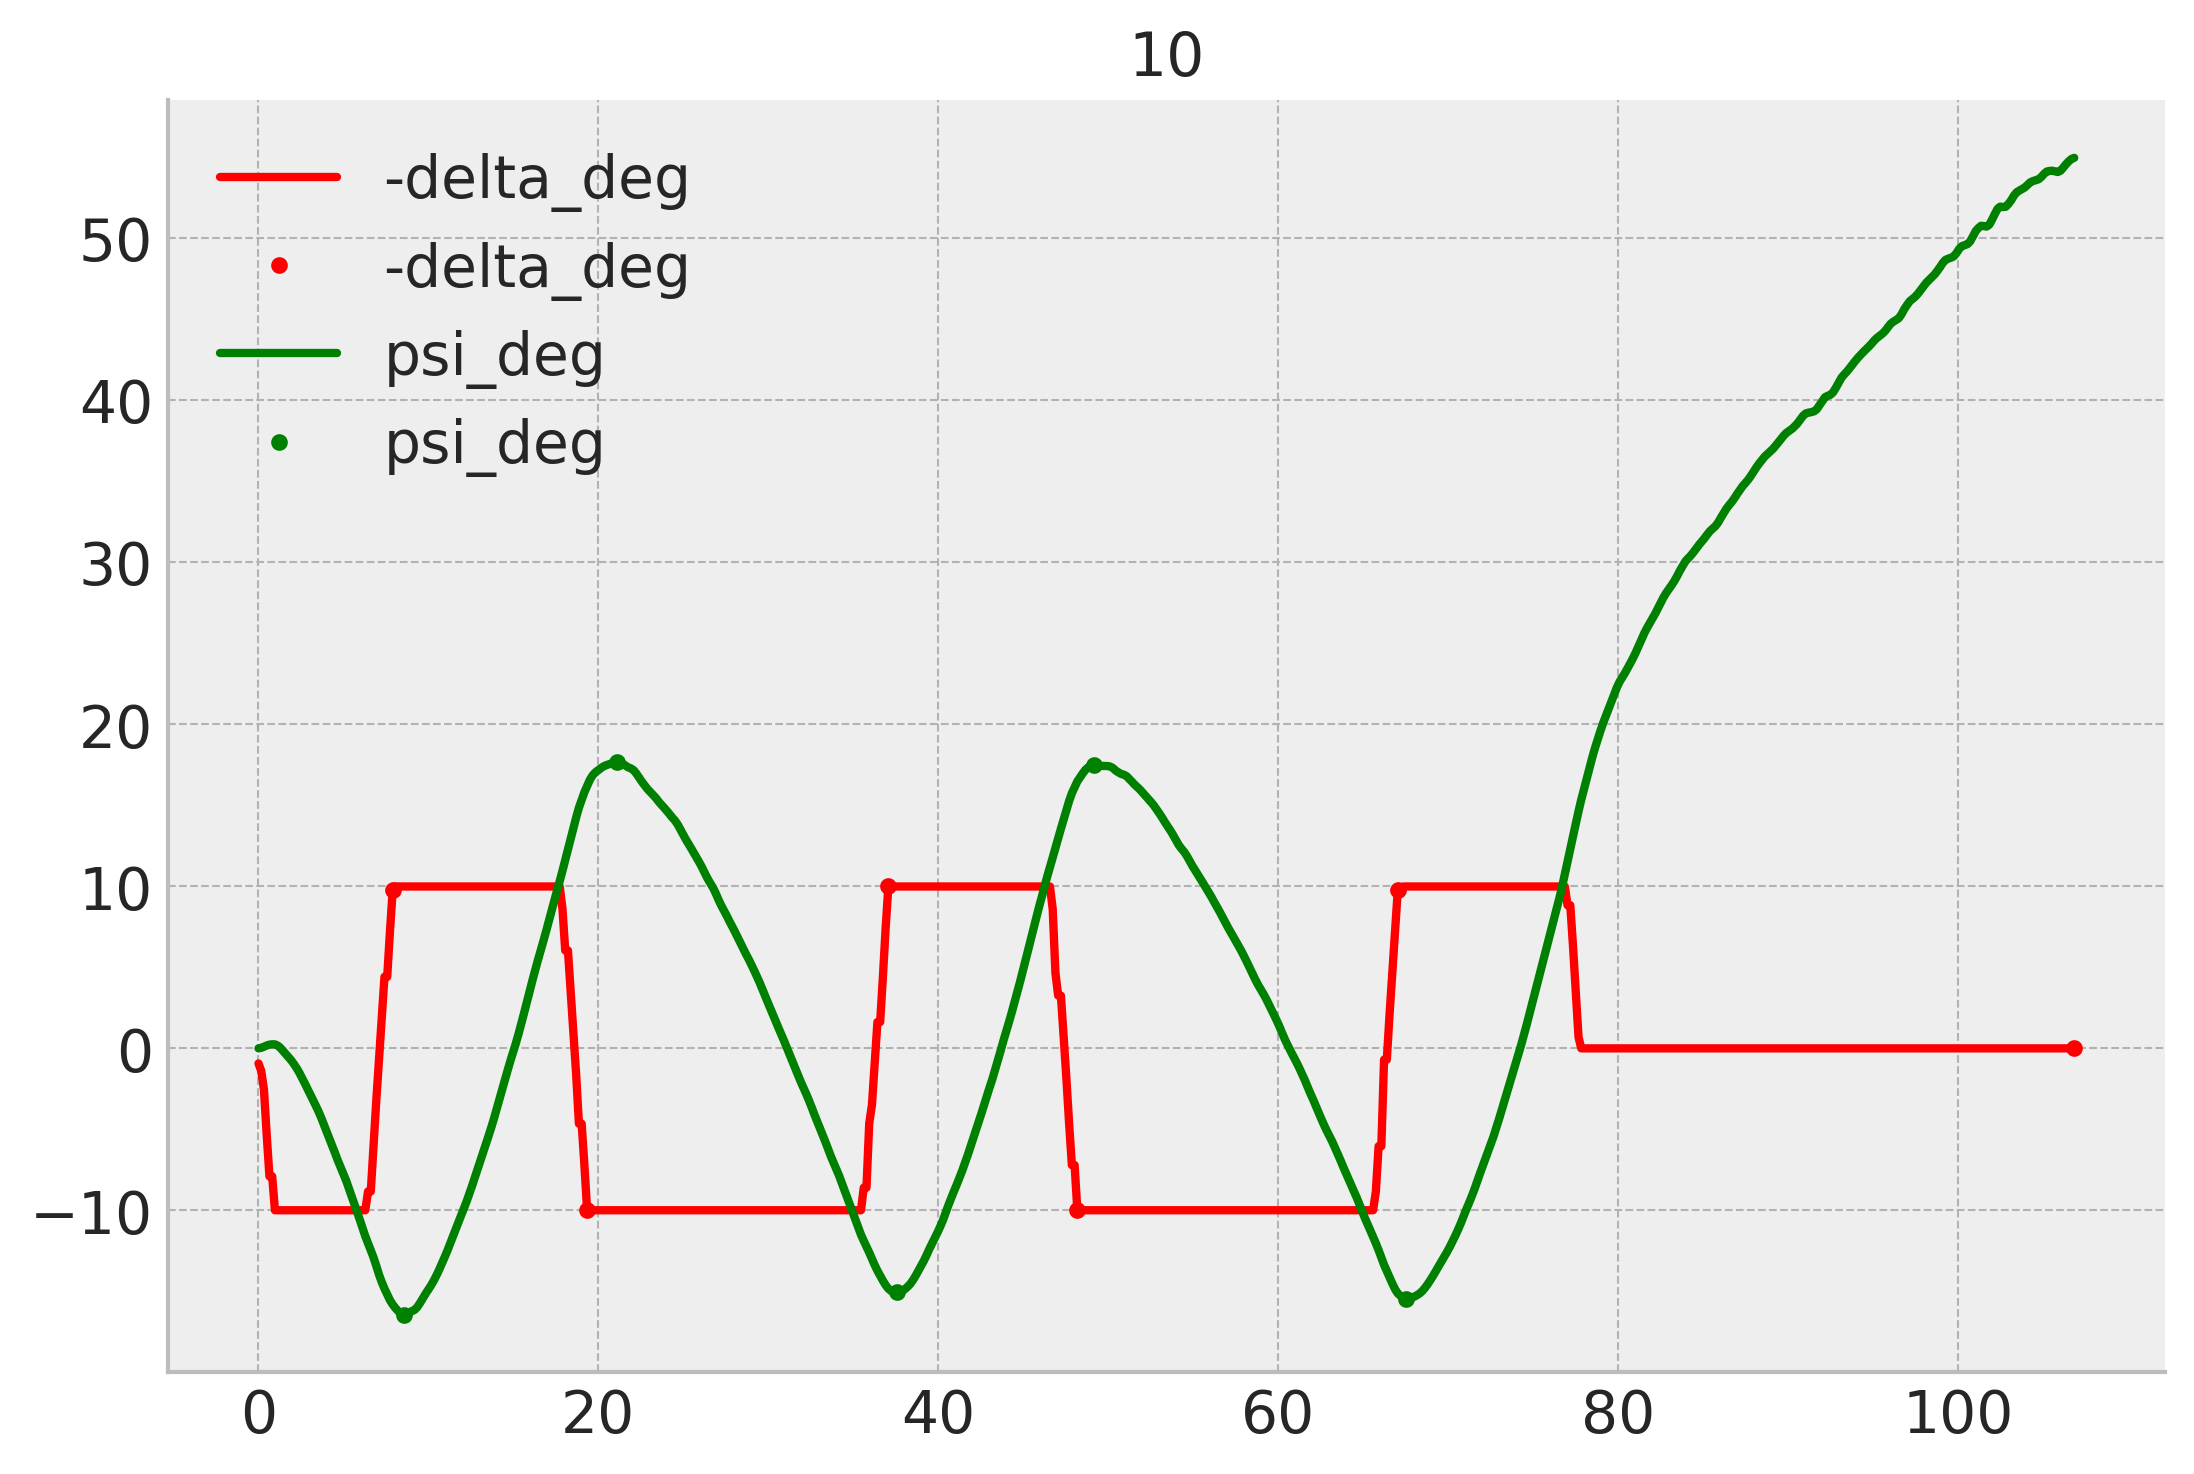

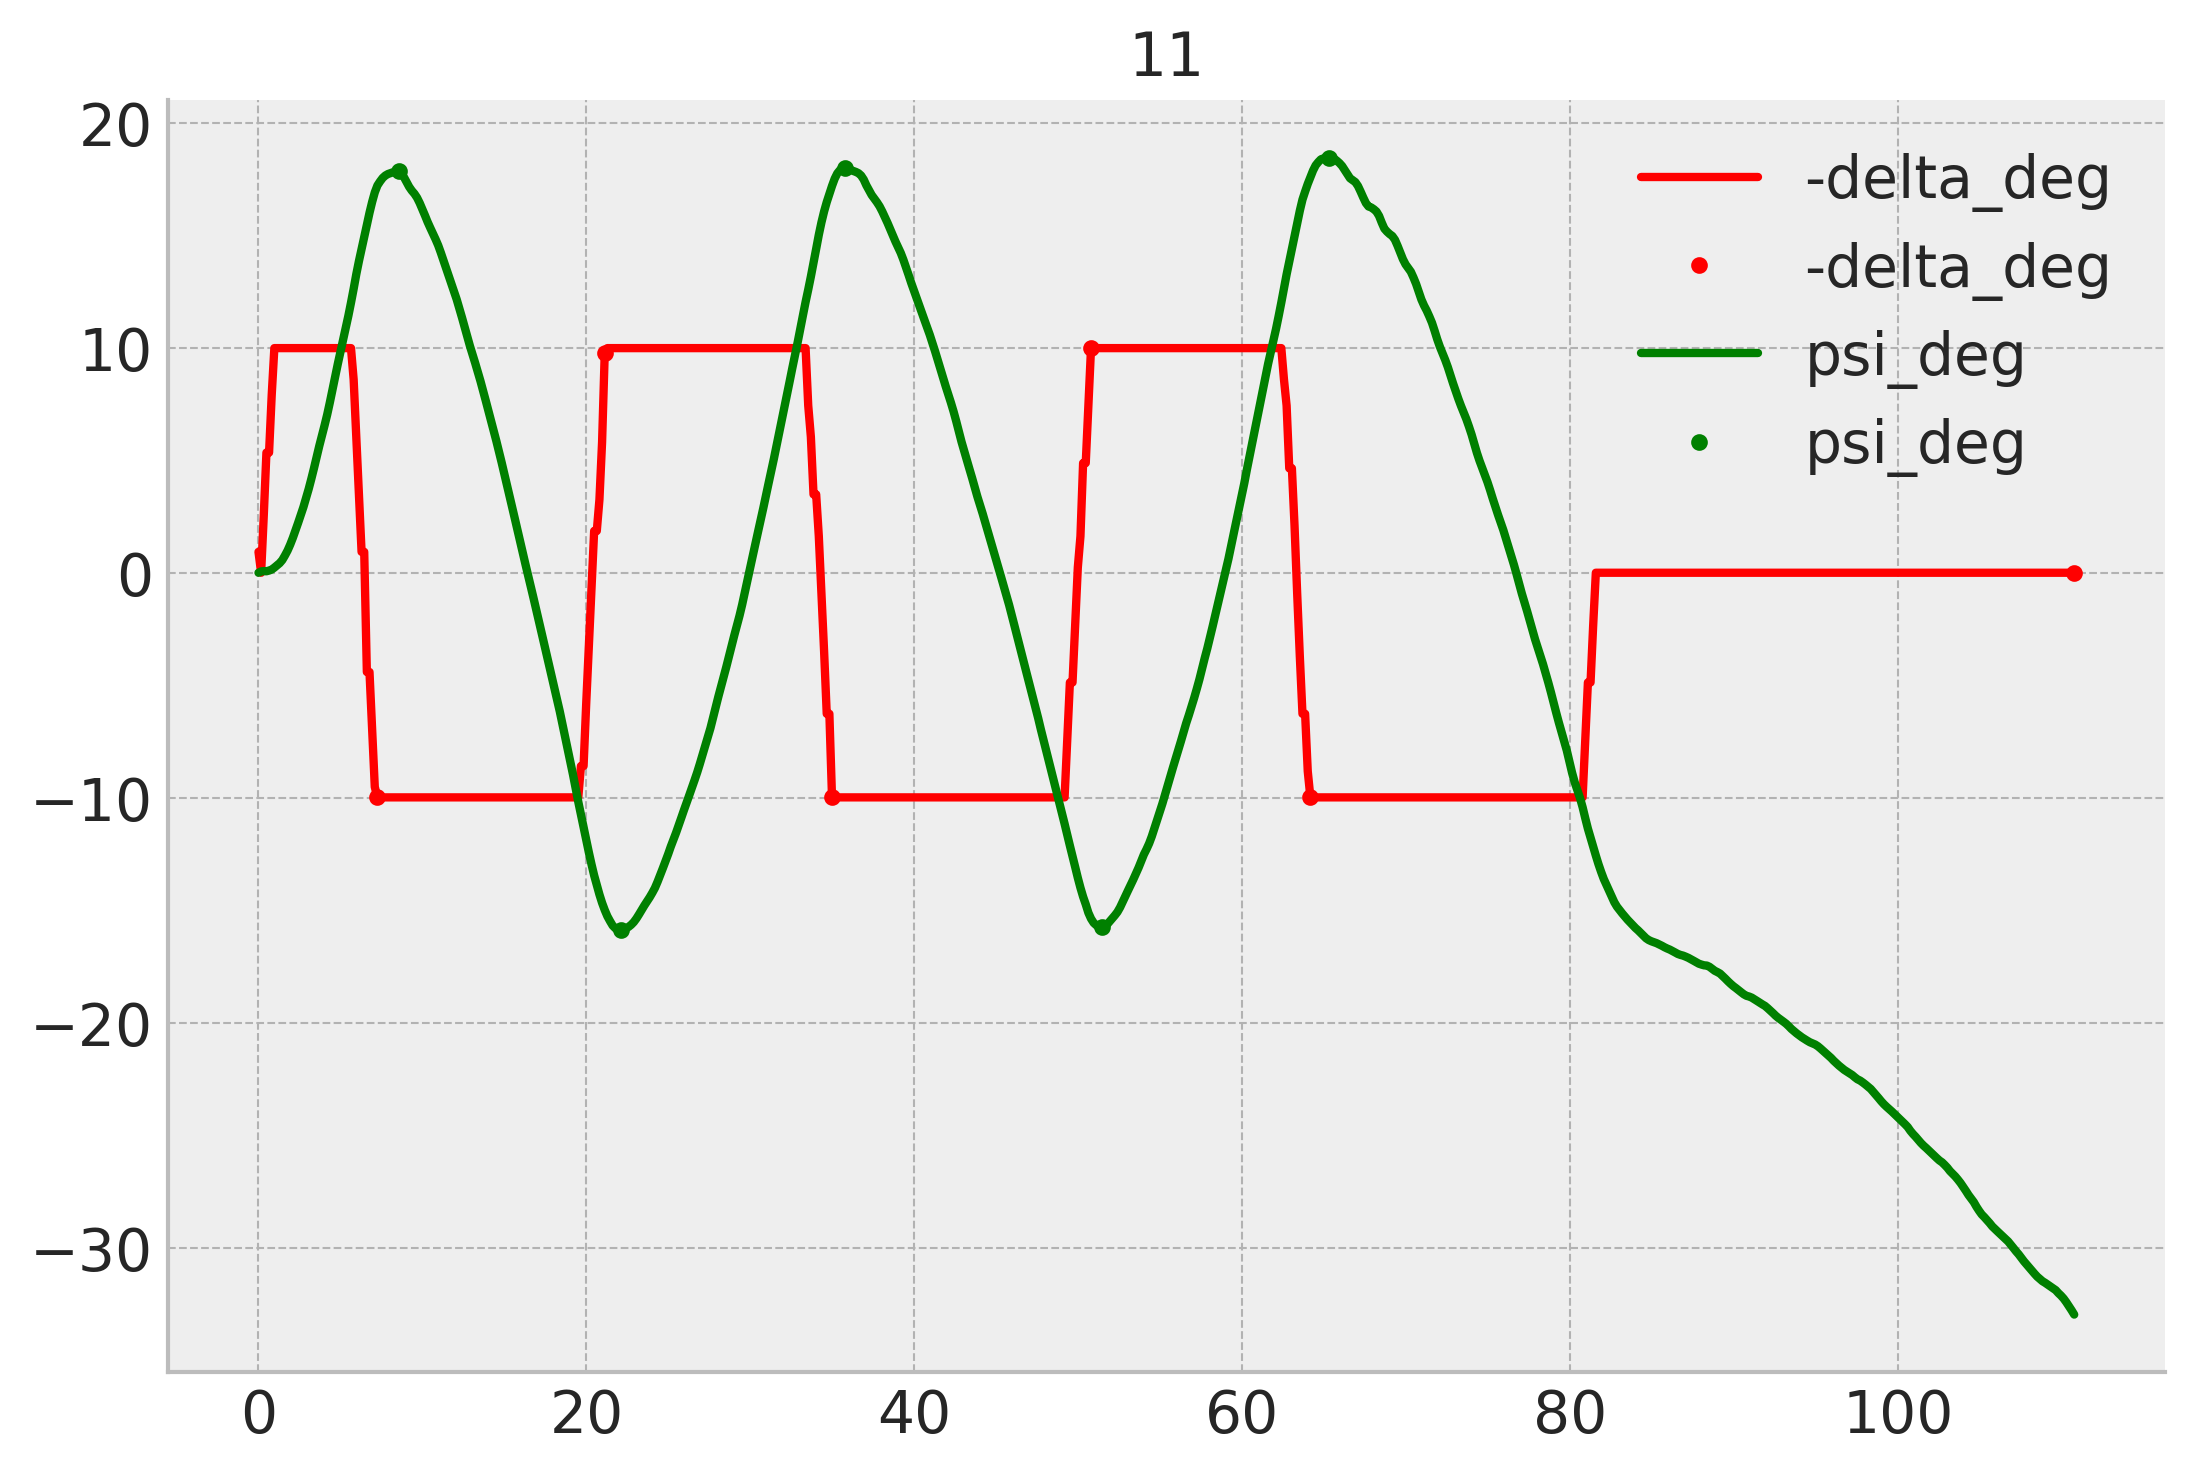

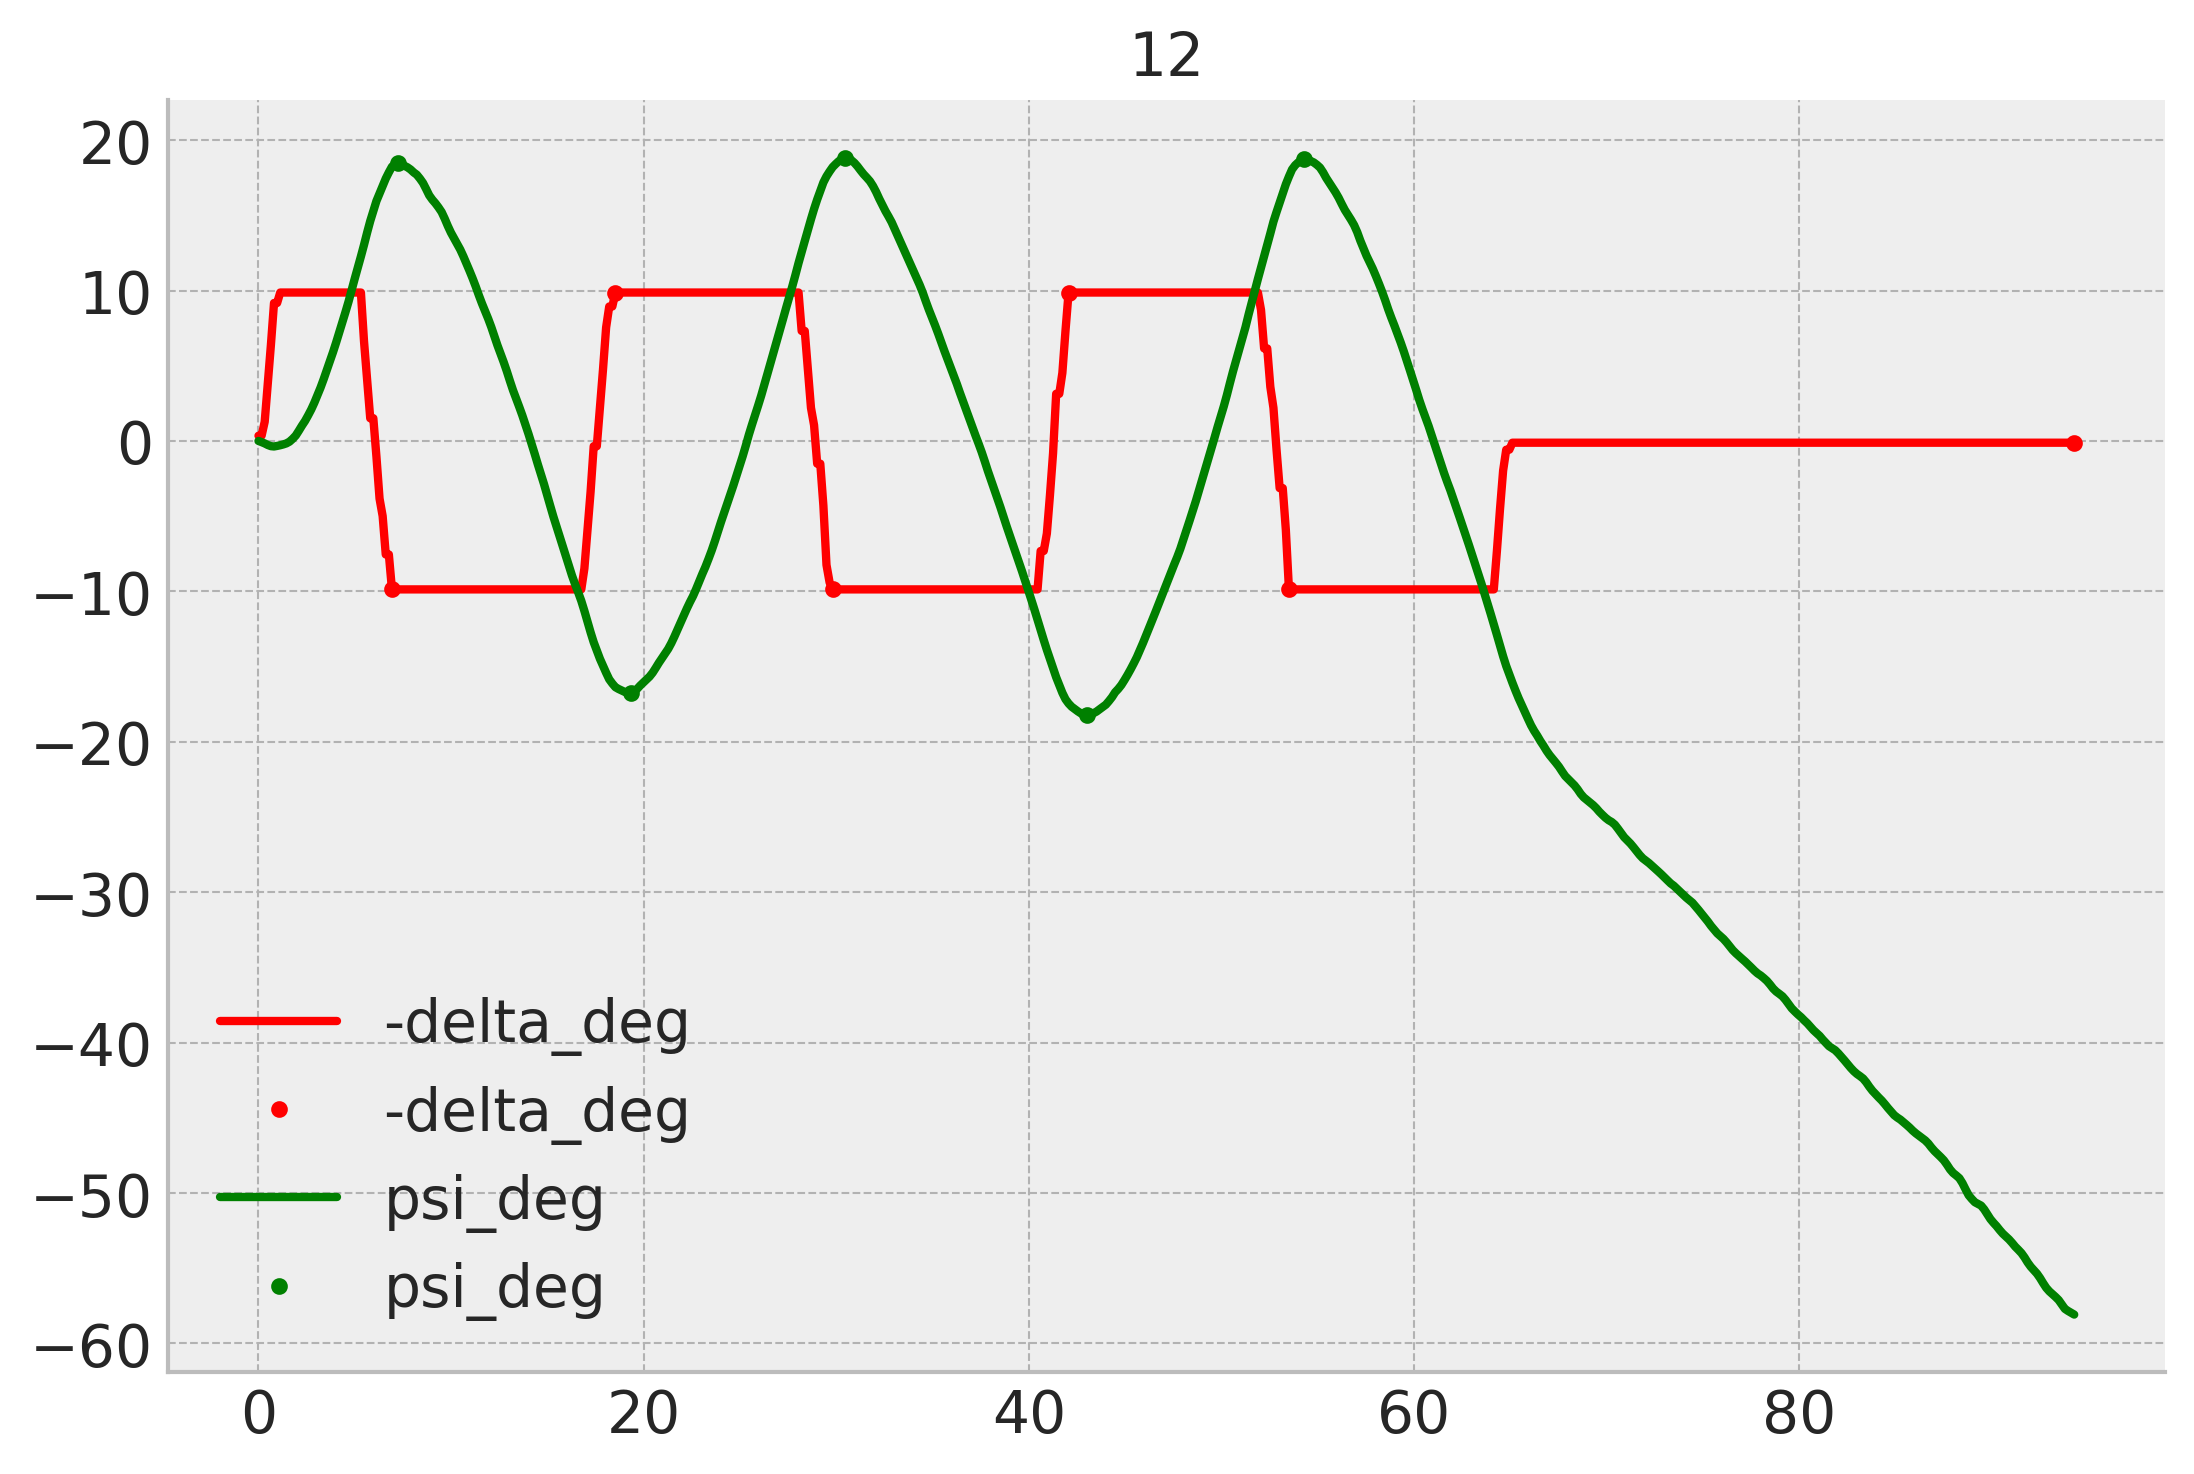

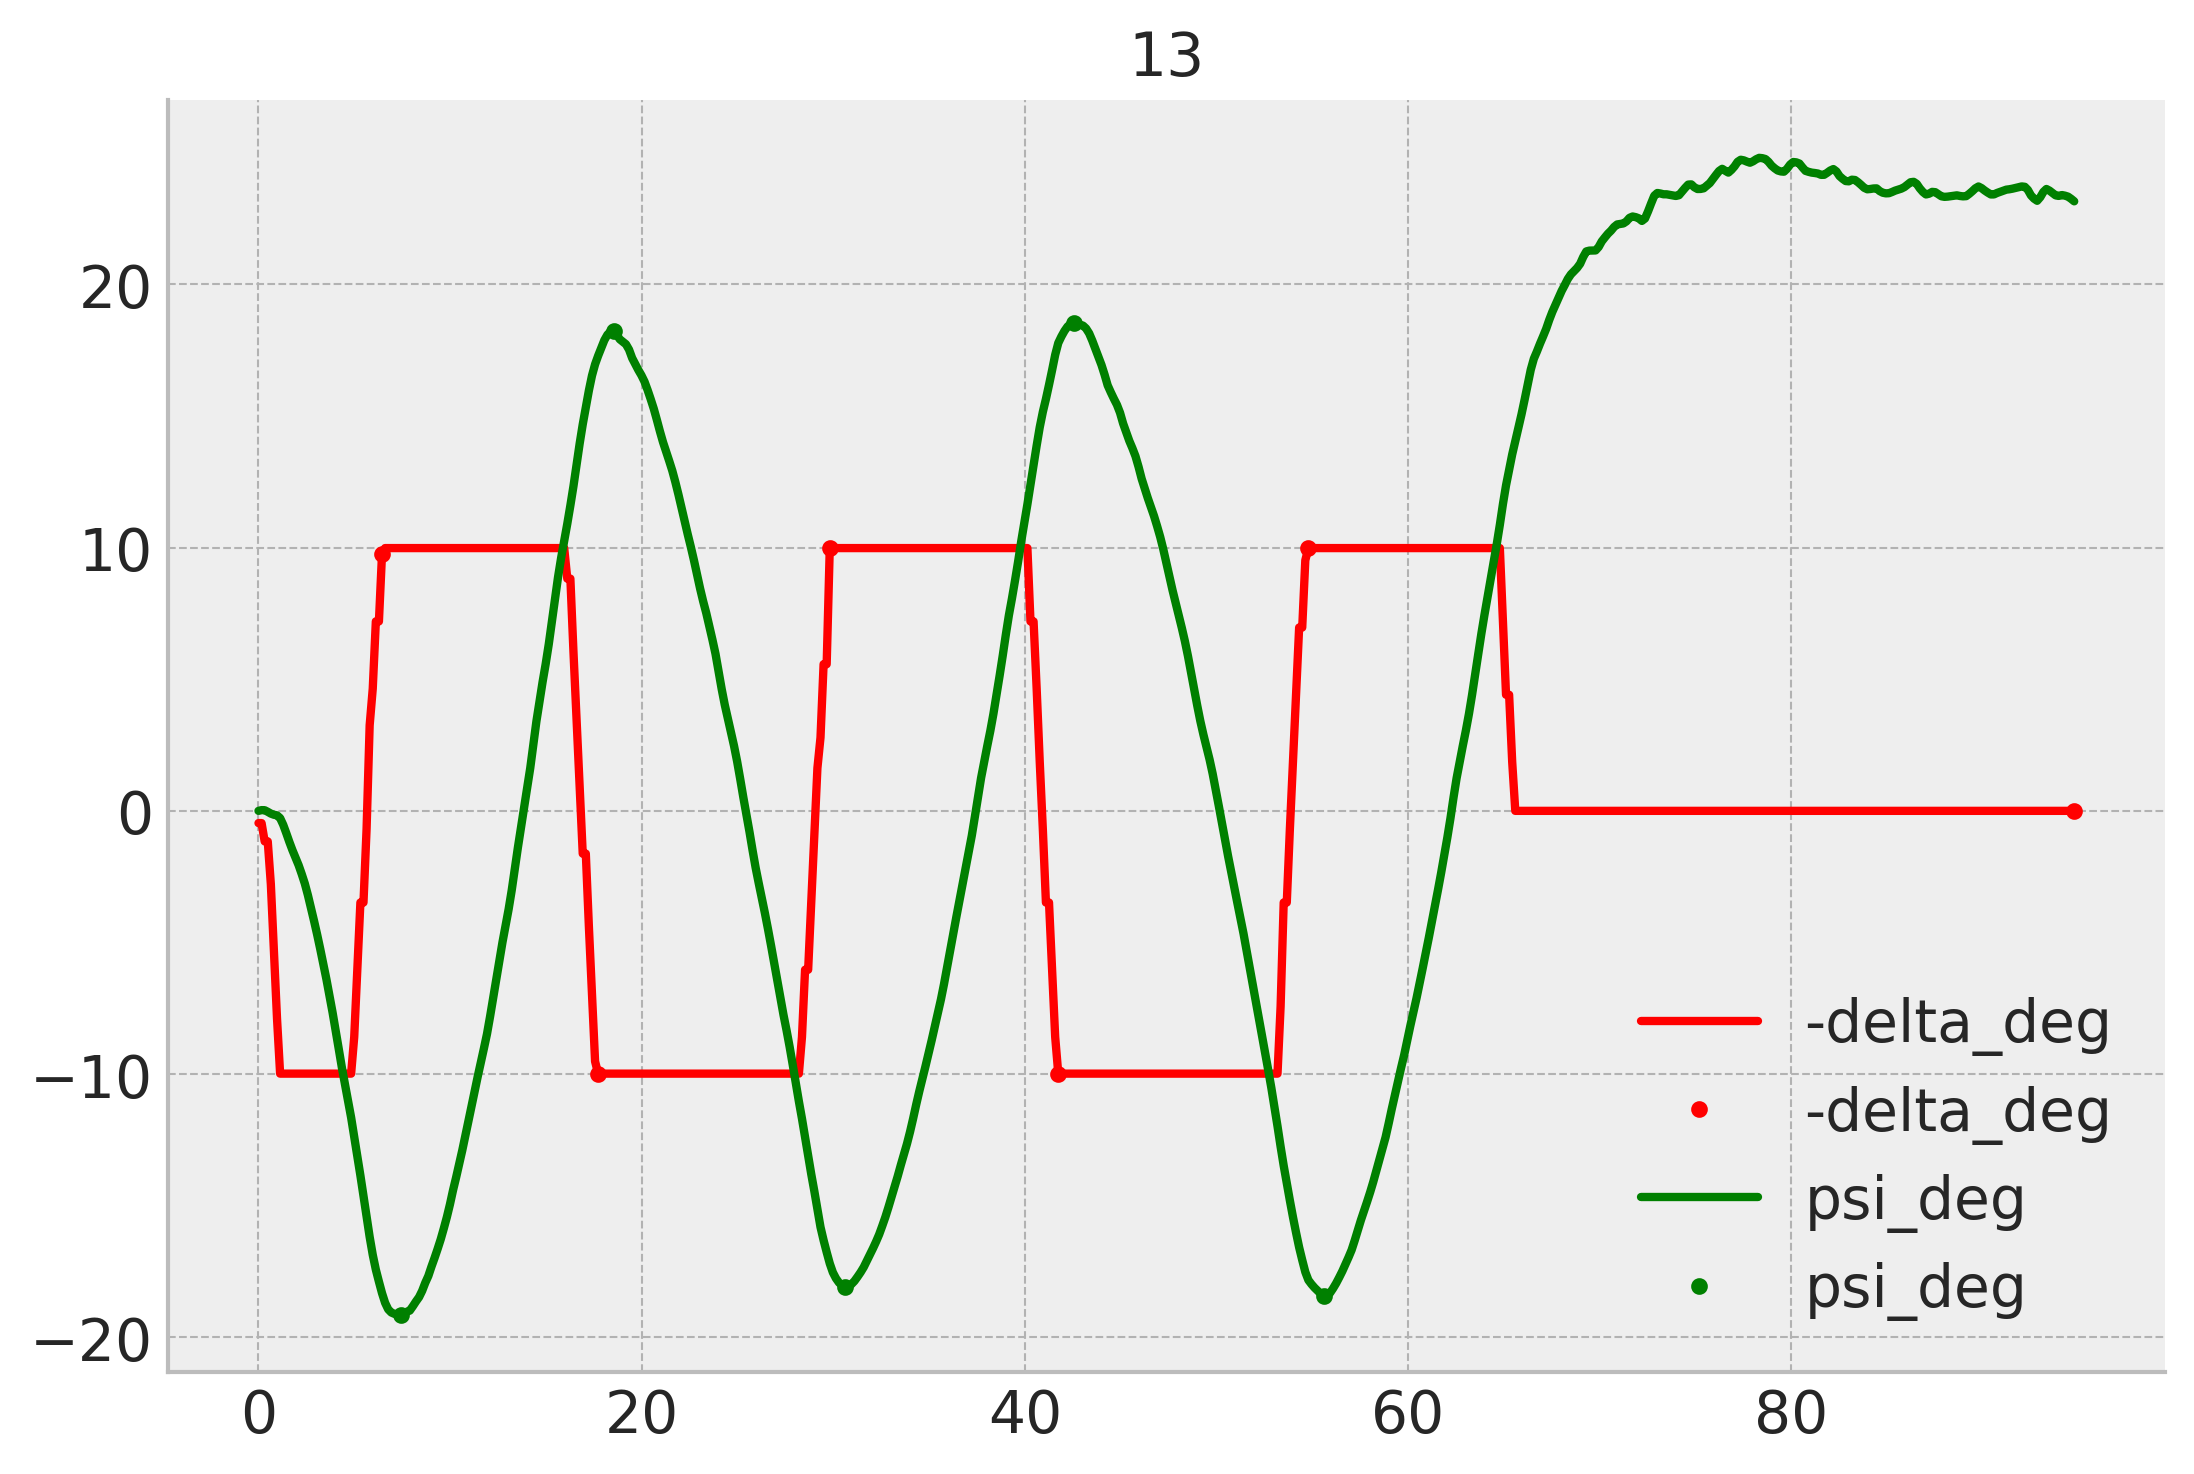

In [37]:
_ = []
mask = time_series_meta_data['type'] == 'zigzag'
time_series_selection = time_series_meta_data.loc[mask].copy()
#time_series_selection.drop(index=[22764], inplace=True)
for id, meta_data in time_series_selection.iterrows():
    
    try:
        df = load_field_data(id)
    except:
        continue
     
    df['psi_deg'] = np.rad2deg(df['psi'])
    df['delta']-=(df['delta'].max() + df['delta'].min())/2
    df['-delta_deg']=-np.rad2deg(df['delta'])
    angle = np.round(np.rad2deg((df['delta'].max() - df['delta'].min())/2)/10,0)*10
    
    corners = zigzag._get_corners(angle=np.deg2rad(angle), df=df)
    maximums = zigzag._get_maximums(df=df, corners=corners)
    
    fig,ax=plt.subplots()
    df.plot(y='-delta_deg', style='r-', ax=ax)
    corners.plot(y='-delta_deg', style='r.', ax=ax)
    
    df.plot(y='psi_deg', style='g-', ax=ax)
    maximums.plot(y='psi_deg', style='g.', ax=ax)
    ax.set_title(id)
    
    results = evaluate(df=df, angle=angle)
    results['angle1'] = angle
    _.append(results)
    
evaluations_field_data = pd.DataFrame(_)
evaluations_field_data = pd.merge(left=evaluations_field_data, right=time_series_meta_data.drop(columns=['V']), left_index=True, right_index=True, how='left')

In [38]:
evaluations_field_data.head()

overshoot_1  overshoot_2  overshoot_3  overshoot_4  overshoot_5   period_1   period_2   period_3         V  angle1       yaw  rudderTarget   latitude  longitude  heelAngle  awaSternRAW  awsSternRAW  thrusterTarget  courseTarget  pitchAngle     GyroX     GyroY     GyroZ    AccelX    AccelY    AccelZ  awaBowRAW  awsBowRAW  rudderAngle     delta       psi       phi     theta         p       p1d         q       q1d       y_GPS        x_GPS           x0          y0         u         v         r       u1d       v1d       r1d       aws       awa         U      beta       cog       tws       twa  v1d_AccelY  u1d_AccelX  zigzag_test_id  inbetween_zigzags_id                       date  global time start  global time end                                           missions    type              time_series  sog  awaBow  awsBow  twaBow  twsBow  awaStern  awsStern  twaStern  twsStern  twaBowRAW  twsBowRAW  twsSternRAW   mission
0    10.100200    12.711332    11.146426    12.917718     9.203514  10.636362  11.119833  10.636362  2.305946    10.0 -2.869532      2.997609  59.290853  18.324044   0.011756    -0.117815     1.803712           100.0     -3.127558    0.009364  0.001582 -0.000934  0.017416  0.108683 -0.100004 -9.821080  -0.057739   1.805349     2.872793 -0.050178 -2.869532  0.011756  0.009364  0.000024 -0.000463 -0.000006 -0.000011  425.351046  1415.806101  1413.359982  425.126244  2.236995 -0.052807  0.017004 -0.174901 -0.001299 -0.001816  1.804531 -0.085510  2.246538  0.024214 -2.893242  0.729250  0.274705   -0.026896    0.173933             0.0                   NaN 2021-04-28 10:27:01.062378        3830.761731      3920.560625  FollowCurrentCourse 15  stopped. comment: setu...  zigzag  01_motoring_7m_all_data  NaN     NaN     NaN     NaN     NaN       NaN       NaN       NaN       NaN        NaN        NaN           NaN      NaN
1    11.390934    16.117823    12.167750    14.216410    10.962615  11.603304  11.280990  12.731403  2.341380    10.0  2.976132      1.473723  59.282844  18.322967   0.021975    -0.255817     5.945218           100.0     -3.141593    0.008293  0.001840 -0.001172 -0.008107  0.114854 -0.221117 -9.827145  -0.257634   6.439807     1.606982 -0.027979  2.976132  0.021975  0.008293  0.000362  0.001039 -0.000127  0.001495  358.209277   524.020883   521.560149  359.104403  2.157077  0.041780 -0.008805 -0.179495 -0.002694  0.000056  6.192513 -0.256885  2.166664 -0.020273  2.997775  4.342320  2.577201    0.014775    0.171810             1.0                   NaN 2021-04-28 10:41:19.851613        4689.550966      4781.382705  ZigZag: start (59.28369141,18.32298660),ZigZag...  zigzag  01_motoring_7m_all_data  NaN     NaN     NaN     NaN     NaN       NaN       NaN       NaN       NaN        NaN        NaN           NaN      NaN
2    11.093616     6.502797    11.209848     7.154319     9.810165  11.280990  12.086775  12.086775  2.176433    10.0 -0.016693      3.126105  59.286841  18.323604   0.012927     3.005560     1.045852            80.0     -0.174533    0.006816  0.002218 -0.000729  0.006431  0.085716 -0.142740 -9.817491   3.073779   1.003721     3.041956 -0.053111 -0.016693  0.012927  0.006816  0.000939 -0.001056 -0.000048  0.000233  397.410130   969.014553   971.652038  396.882594  2.039055  0.012686  0.005395 -0.163021  0.001591  0.000070  1.024787  3.079834  2.046918 -0.005608 -0.011595  2.593311  3.018457   -0.023570    0.137164             2.0                   NaN 2021-04-28 10:49:38.245151        5187.944504      5282.376141  ZigZag: start (59.28599167,18.32381248),ZigZag...  zigzag  01_motoring_7m_all_data  NaN     NaN     NaN     NaN     NaN       NaN       NaN       NaN       NaN        NaN        NaN           NaN      NaN
3     9.813491     6.321509    10.136955     5.611722    10.816695  10.636362  12.570246  10.152891  2.123908    10.0 -0.380597      1.048747  59.290530  18.322799   0.020053    -0.047182     0.801177            80.0     -0.174533    0.007674  0.001904 -0.000957 -0.009487  0.084805 -0.2

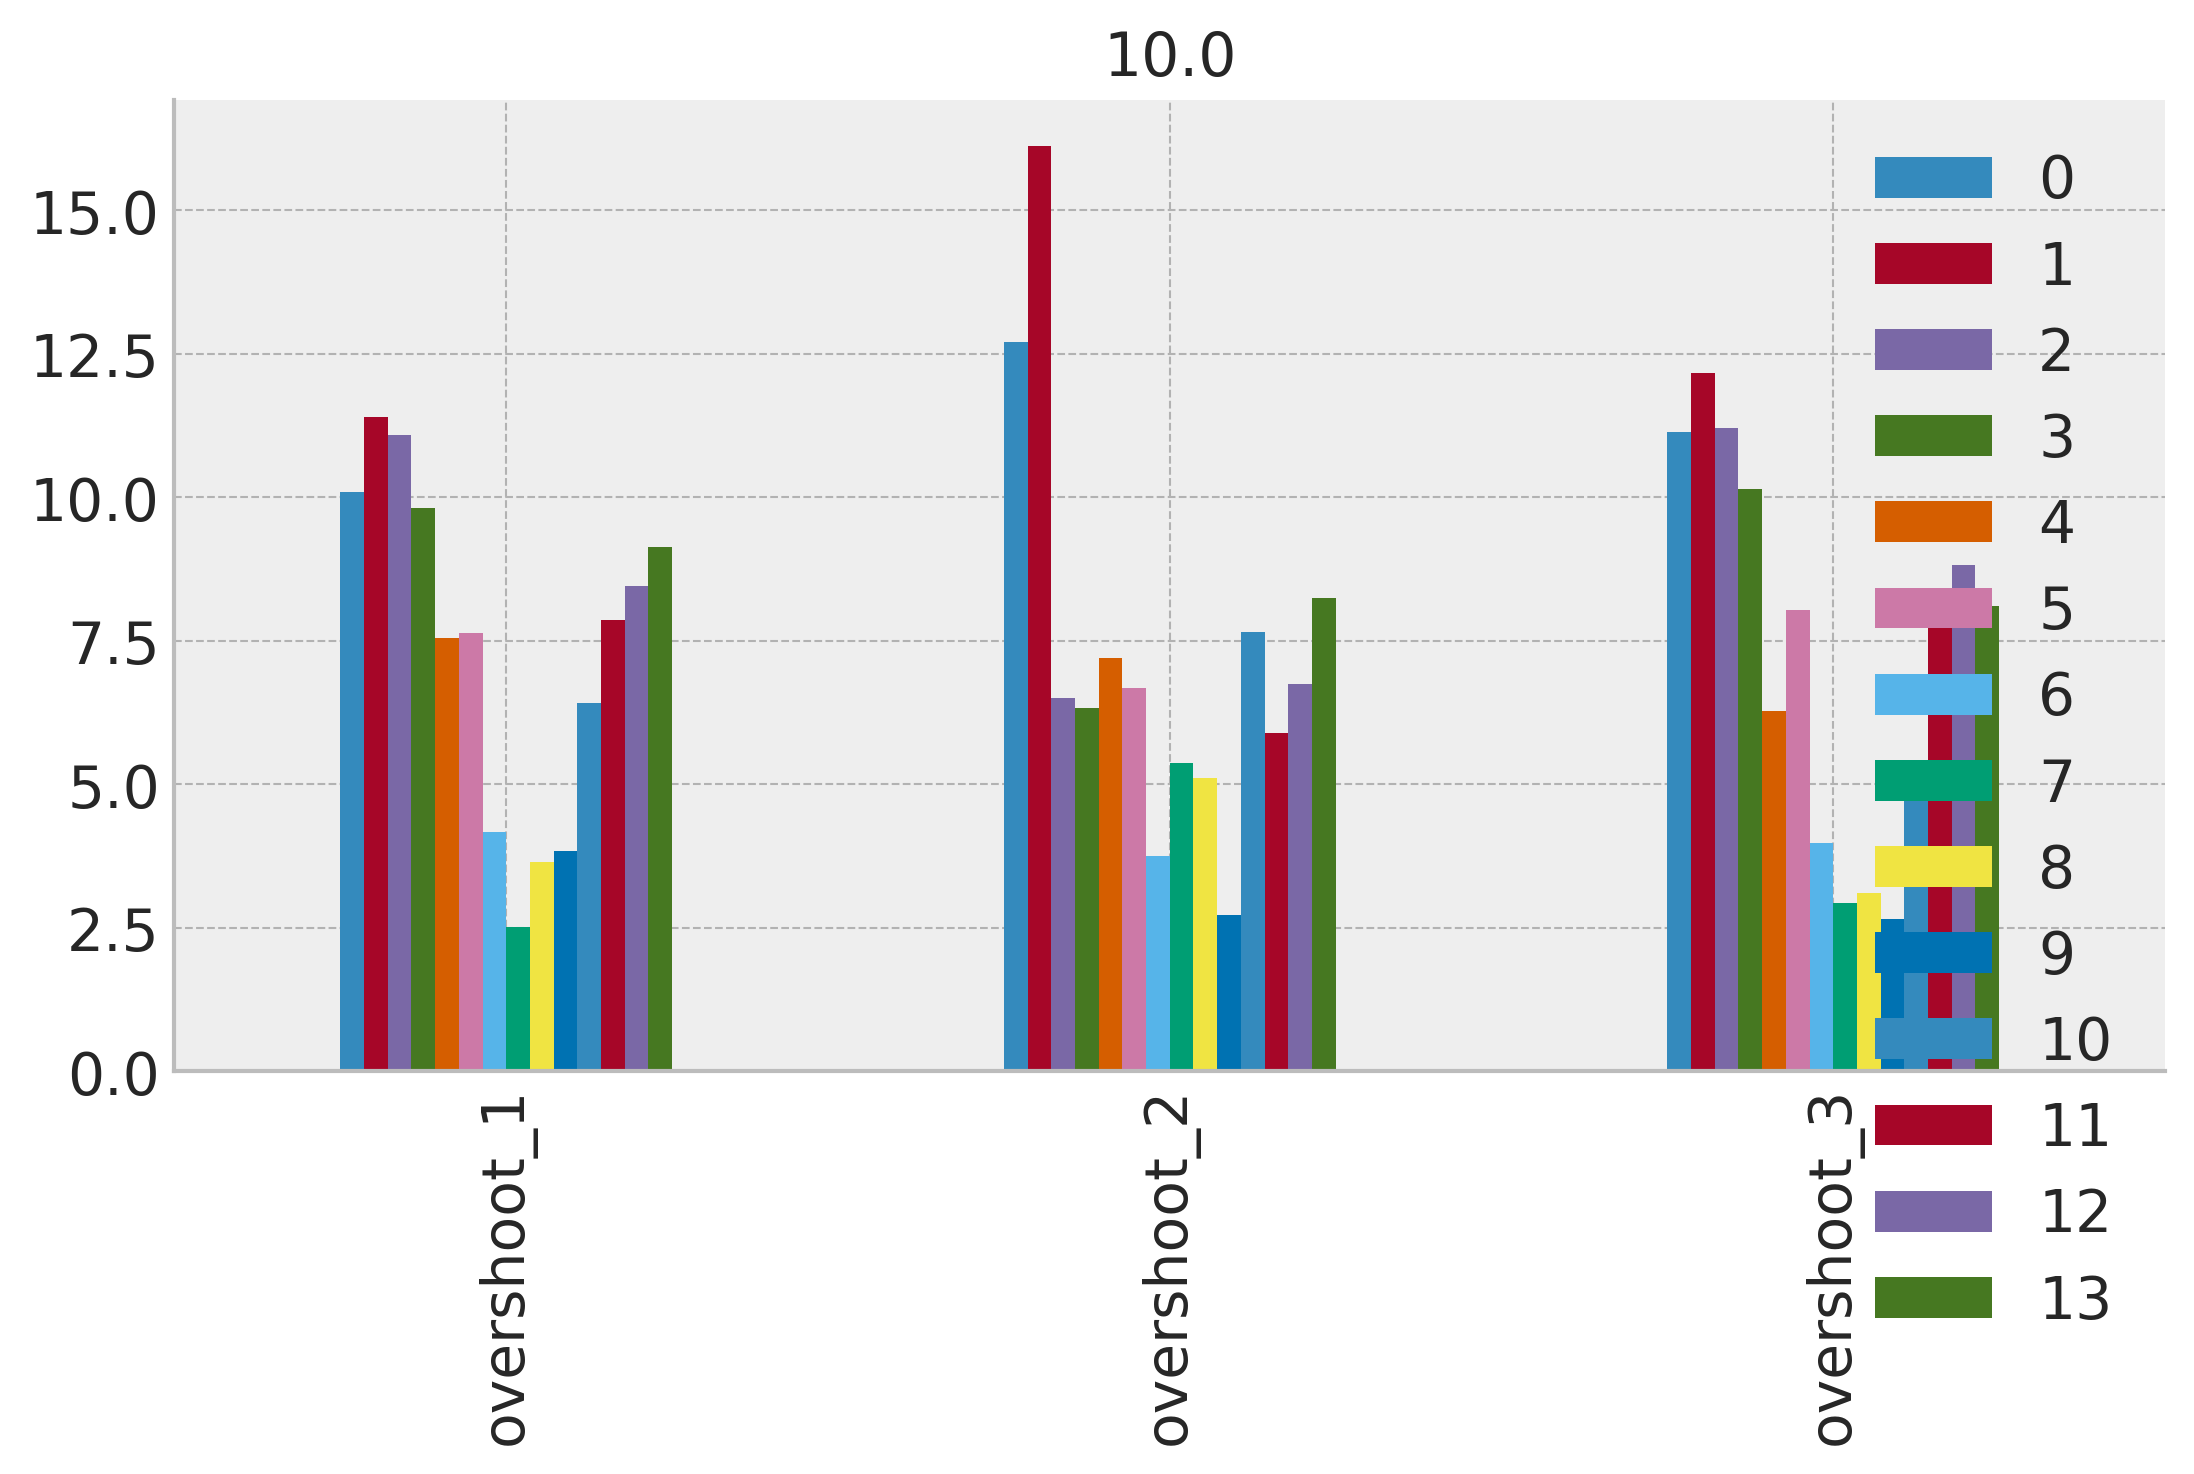

In [39]:
for angle, group in evaluations_field_data.groupby(by='angle1'):
    fig,ax=plt.subplots()
    group[['overshoot_1','overshoot_2','overshoot_3']].transpose().plot.bar(ax=ax)
    ax.set_title(angle)

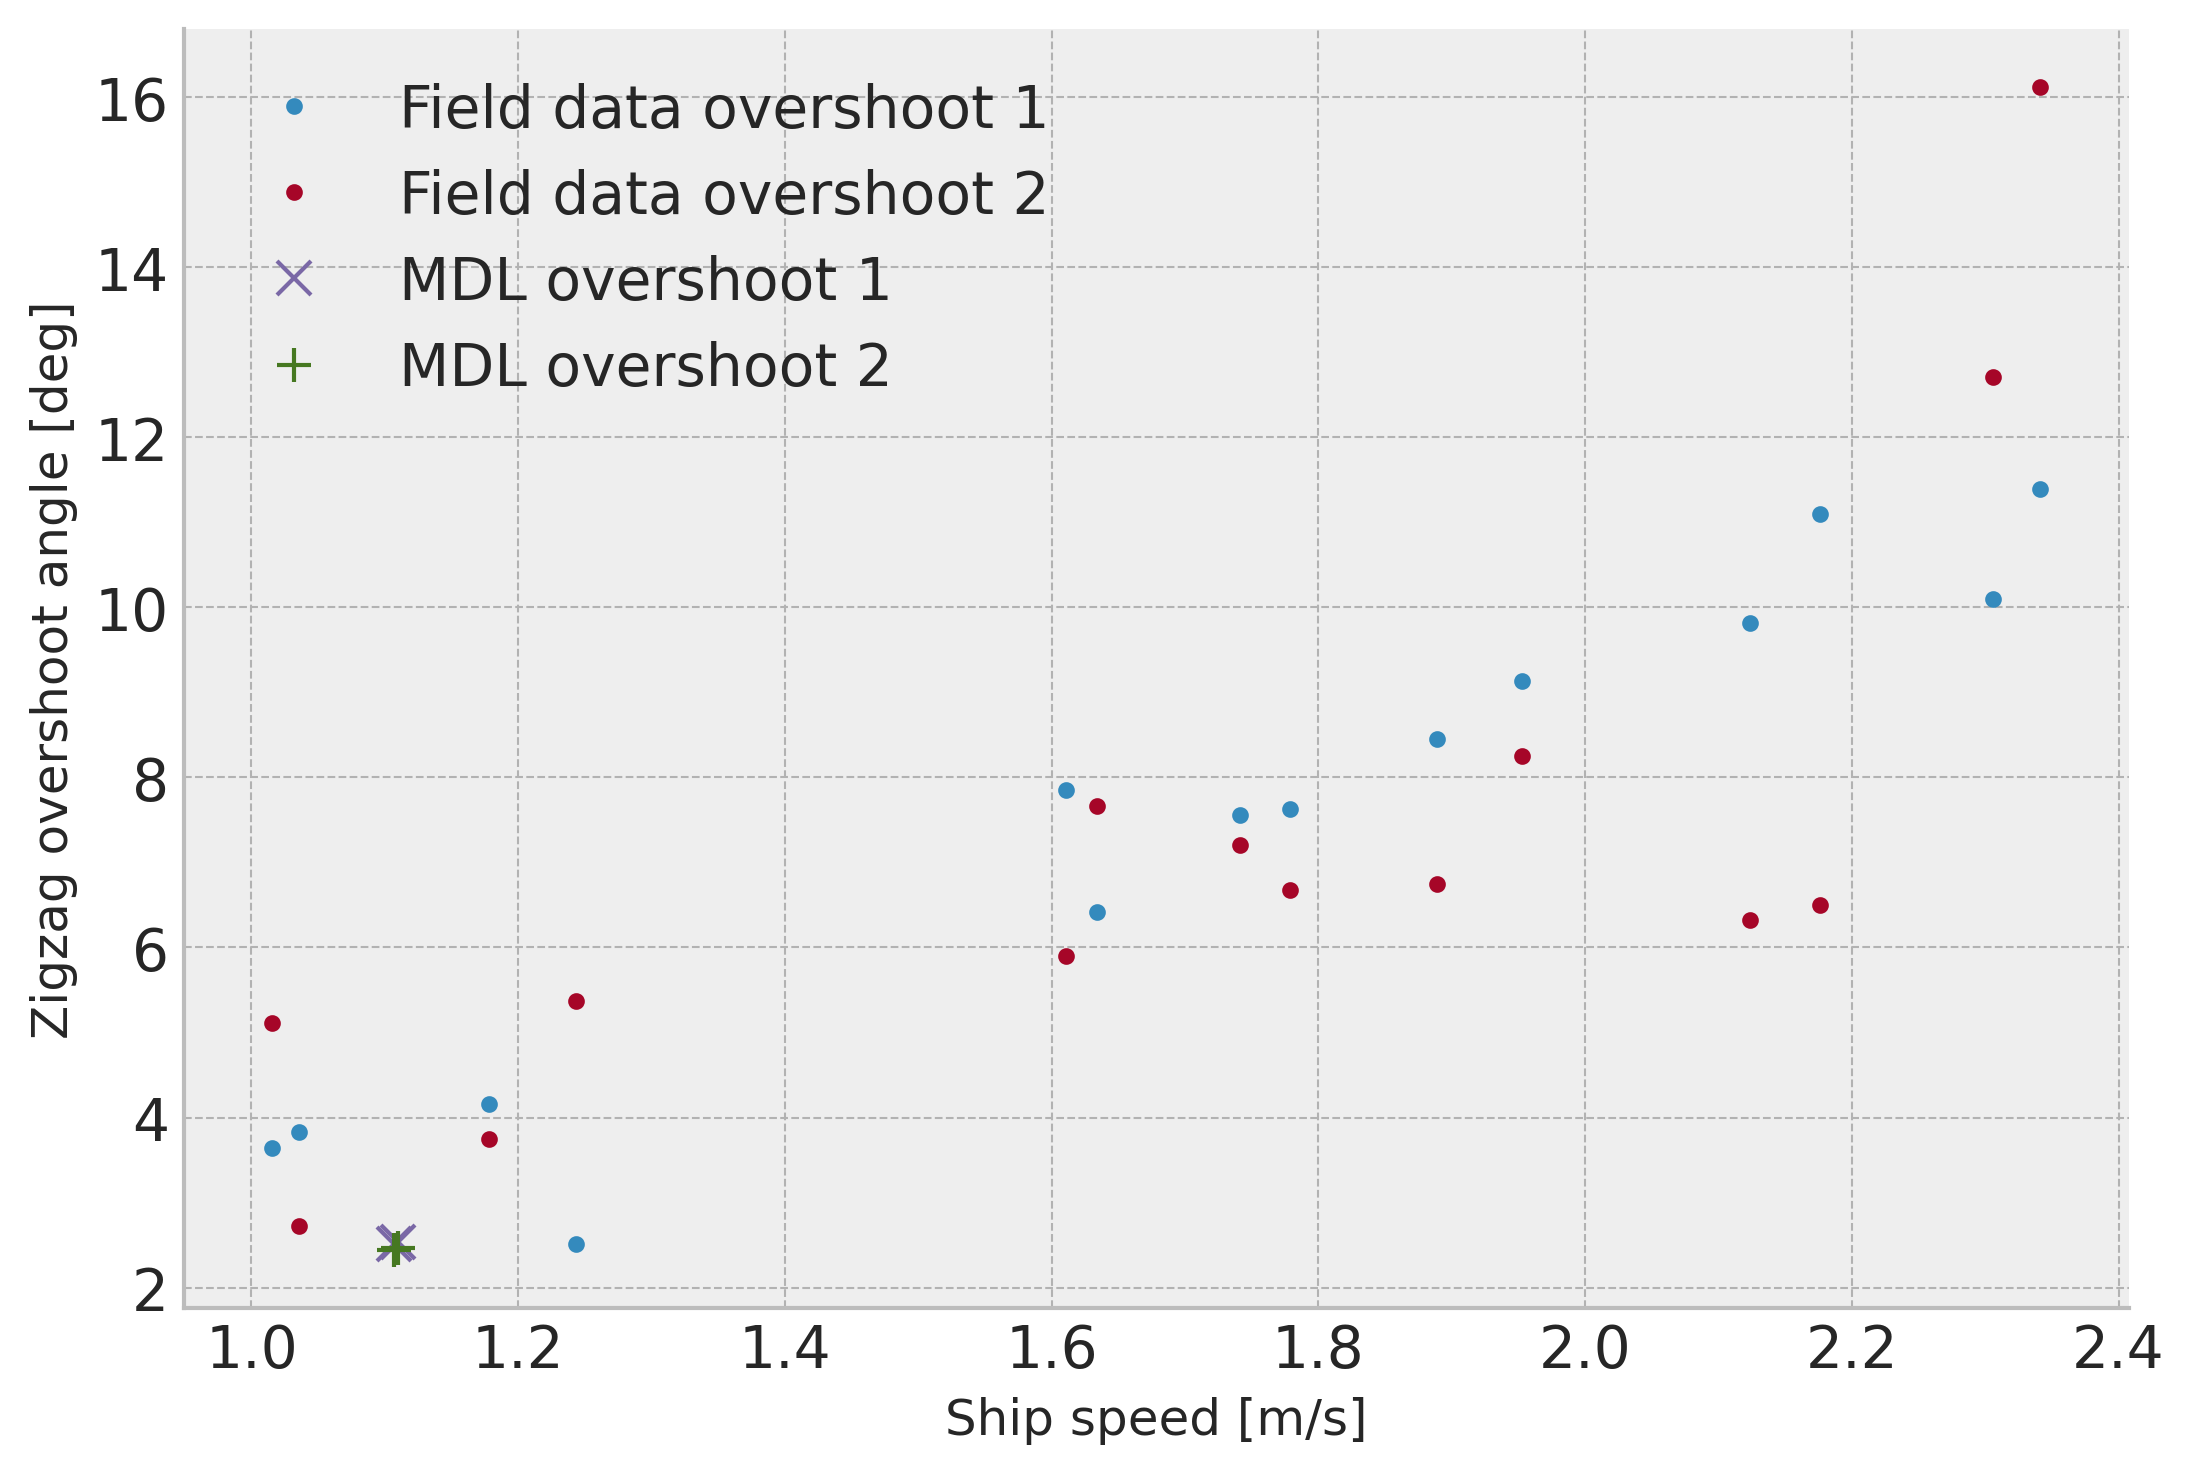

In [40]:
fig,ax=plt.subplots()
evaluations_field_data.plot(x='V', y=['overshoot_1','overshoot_2'], 
                            label=['Field data overshoot 1','Field data overshoot 2'], style='.', ax=ax)
evaluations_MDL.groupby(by='angle1').get_group(10).plot(x='V', y=['overshoot_1','overshoot_2'], 
                            label=['MDL overshoot 1','MDL overshoot 2'], style=['x','+'], ms=8, ax=ax)
ax.set_ylabel('Zigzag overshoot angle [deg]')
ax.set_xlabel('Ship speed [m/s]')
paper.save_fig(fig, file_name="overshoots.pdf")

In [41]:
mask = evaluations_field_data['V'].between(2.17,2.50)
df_selection = evaluations_field_data.loc[mask]

df_selection[['V','aws','overshoot_1','overshoot_2']]

V       aws  overshoot_1  overshoot_2
0  2.305946  1.804531    10.100200    12.711332
1  2.341380  6.192513    11.390934    16.117823
2  2.176433  1.024787    11.093616     6.502797

<Axes: xlabel='V'>

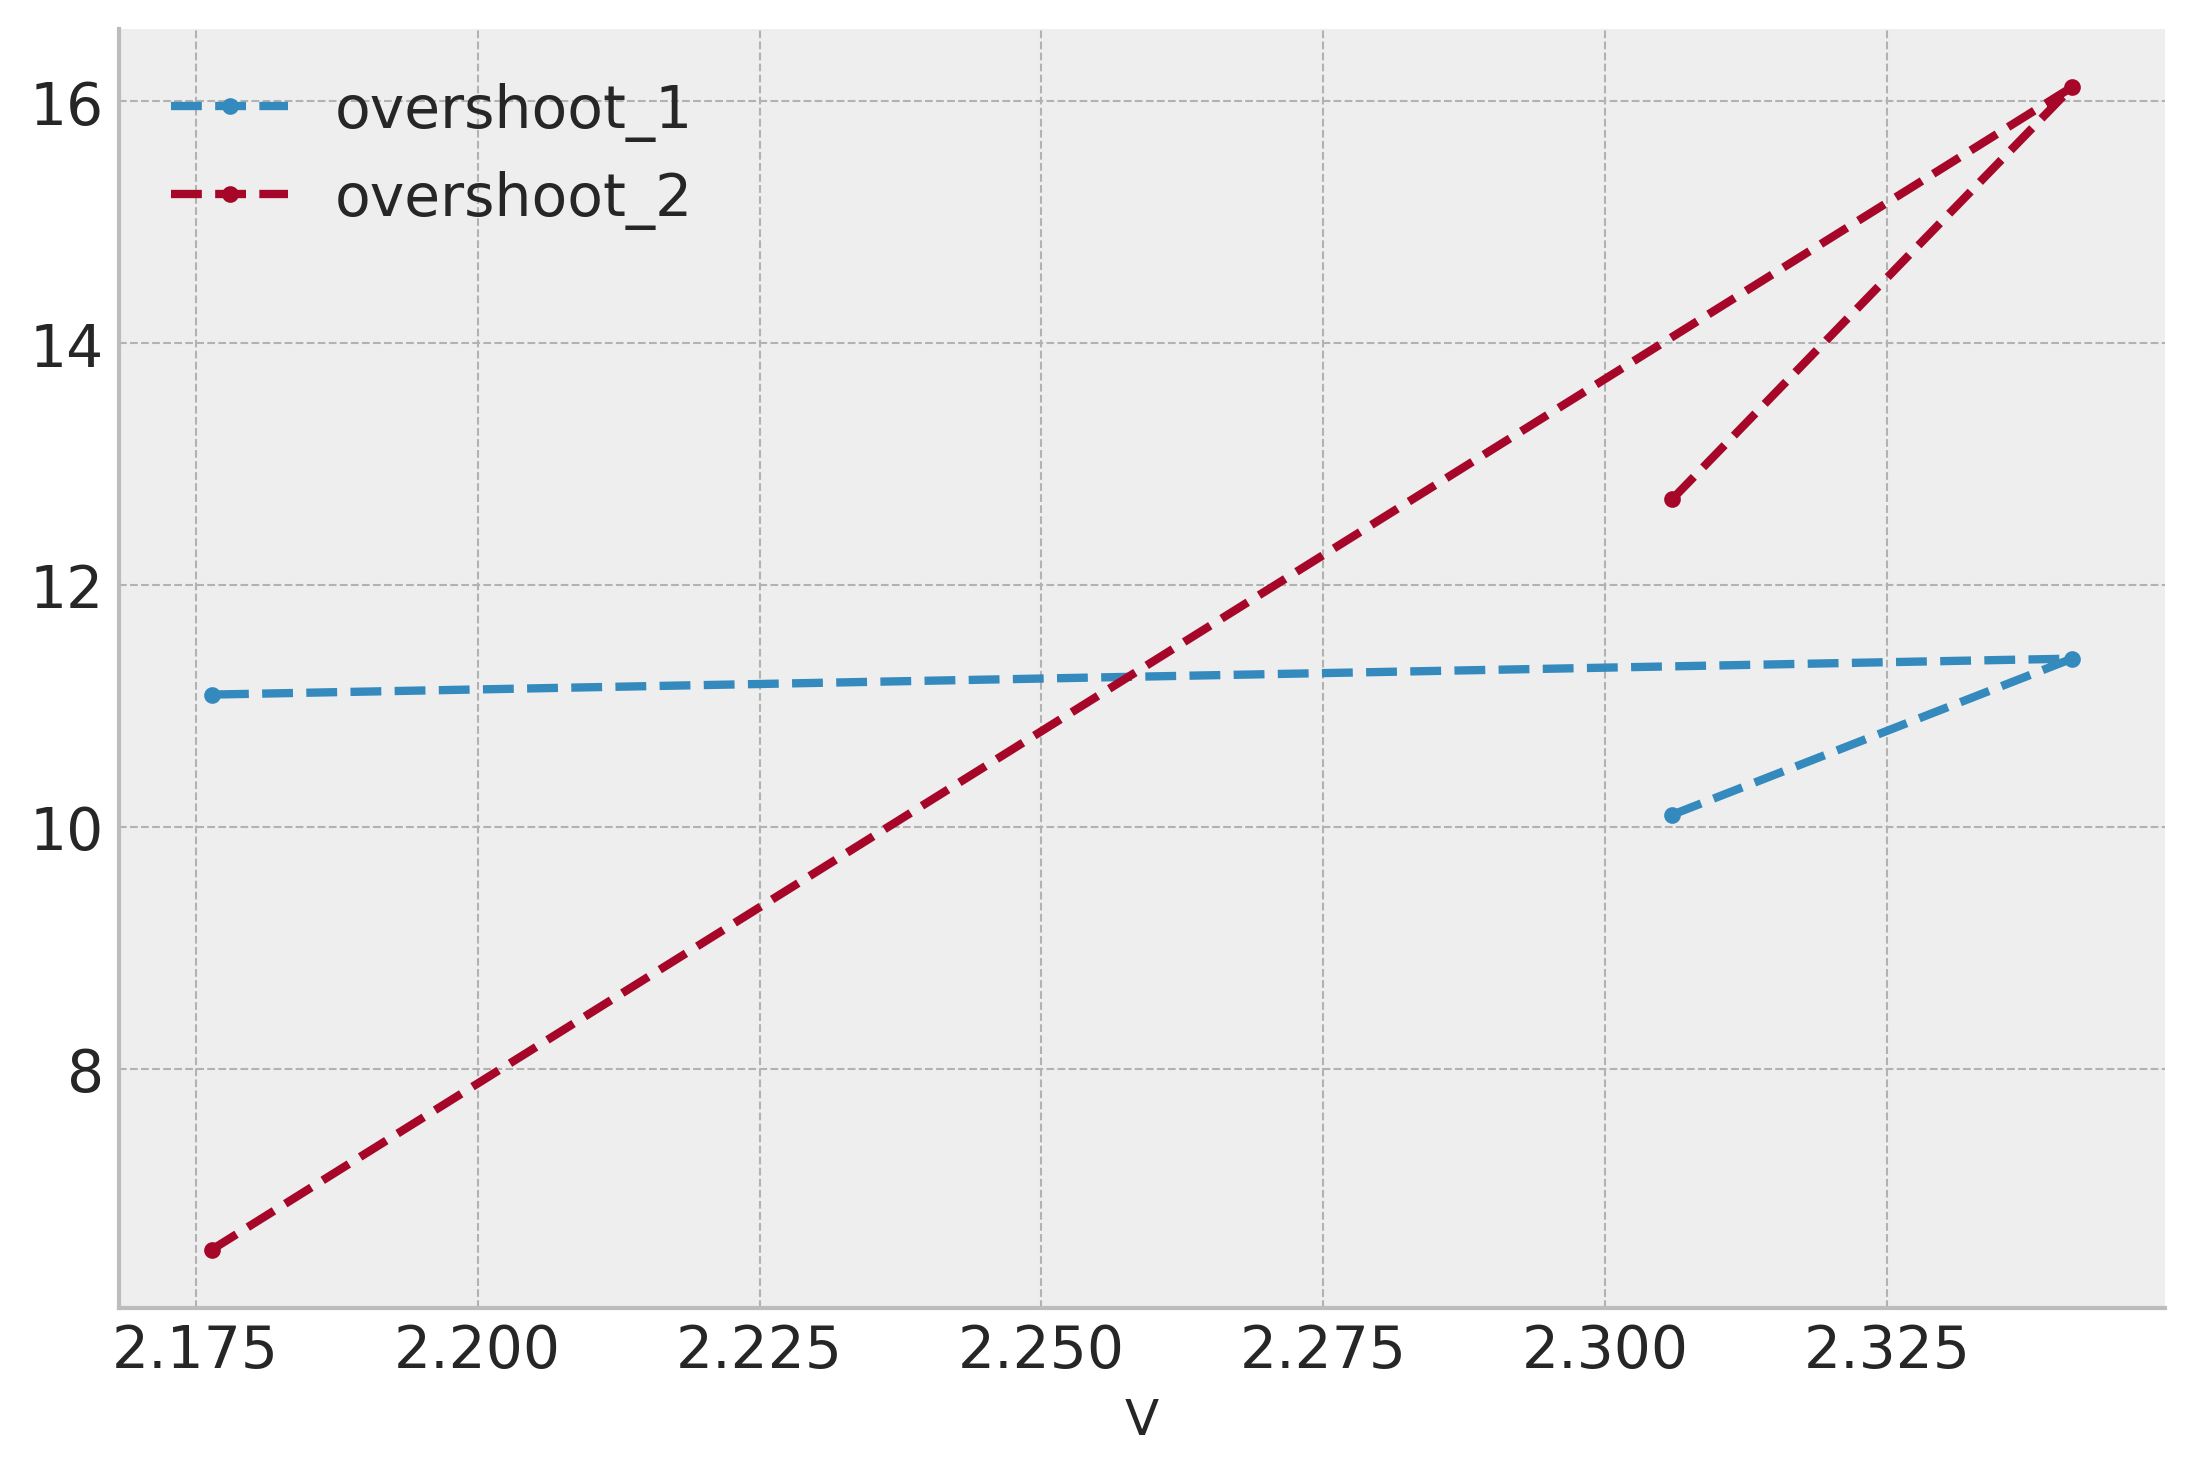

In [42]:
df_selection.plot(x='V', y=['overshoot_1','overshoot_2'],style='--.')

<Axes: xlabel='aws'>

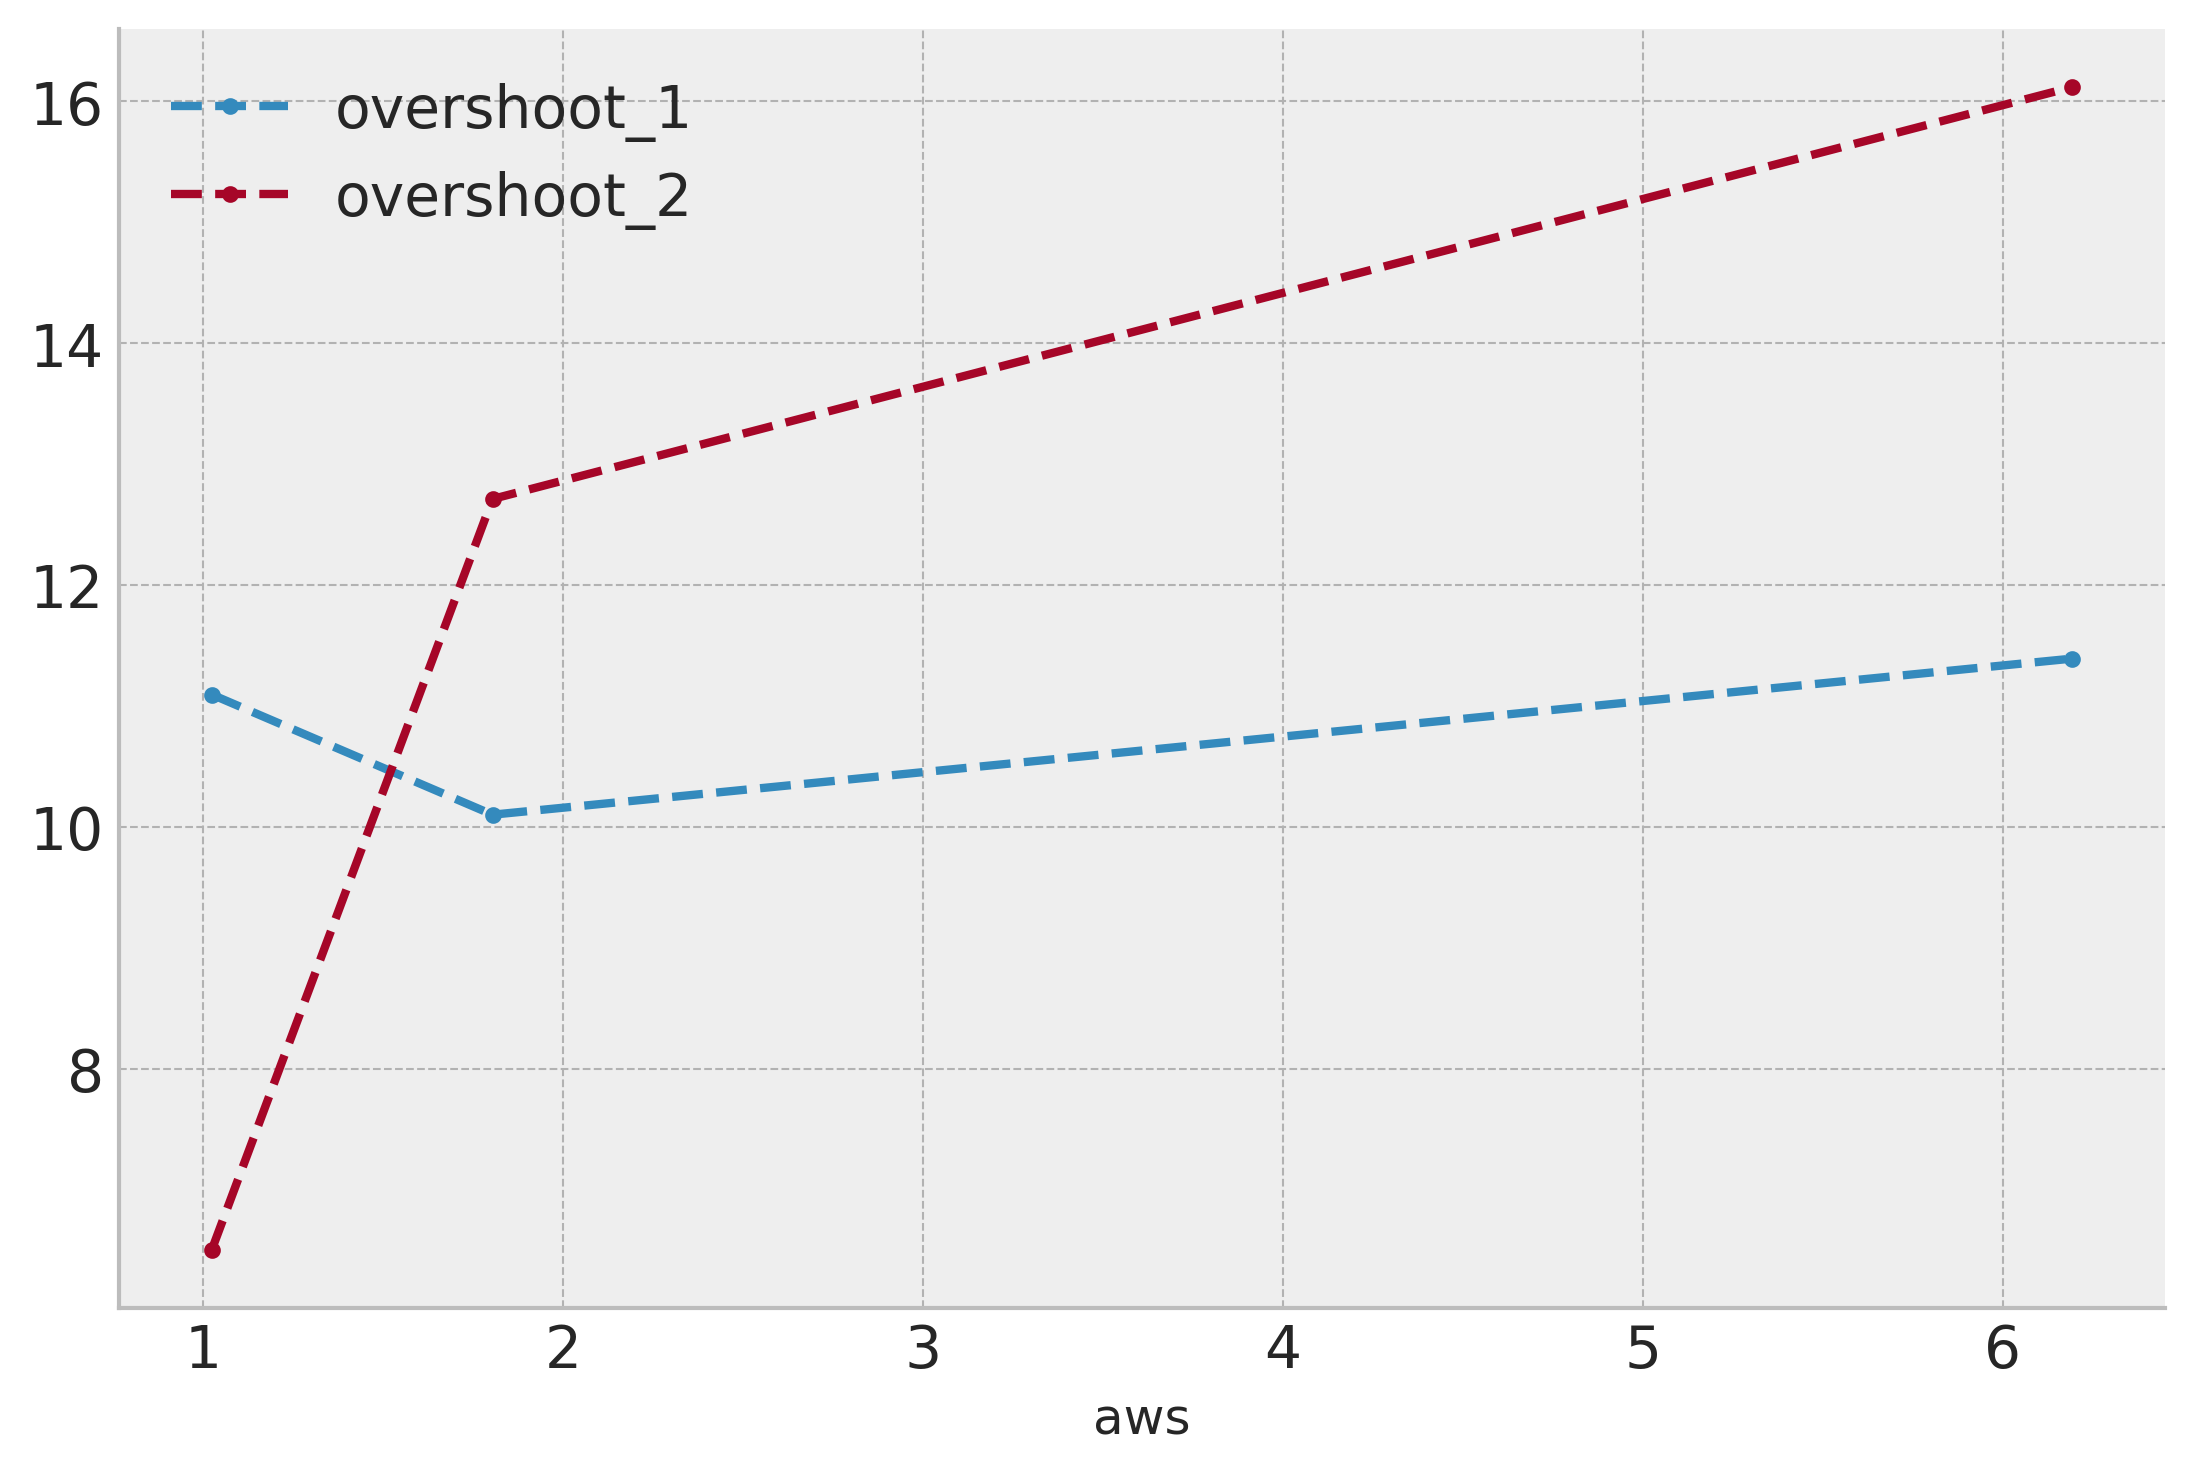

In [43]:
df_selection.sort_values(by='aws').plot(x='aws', y=['overshoot_1','overshoot_2'],style='--.')

<Axes: xlabel='V'>

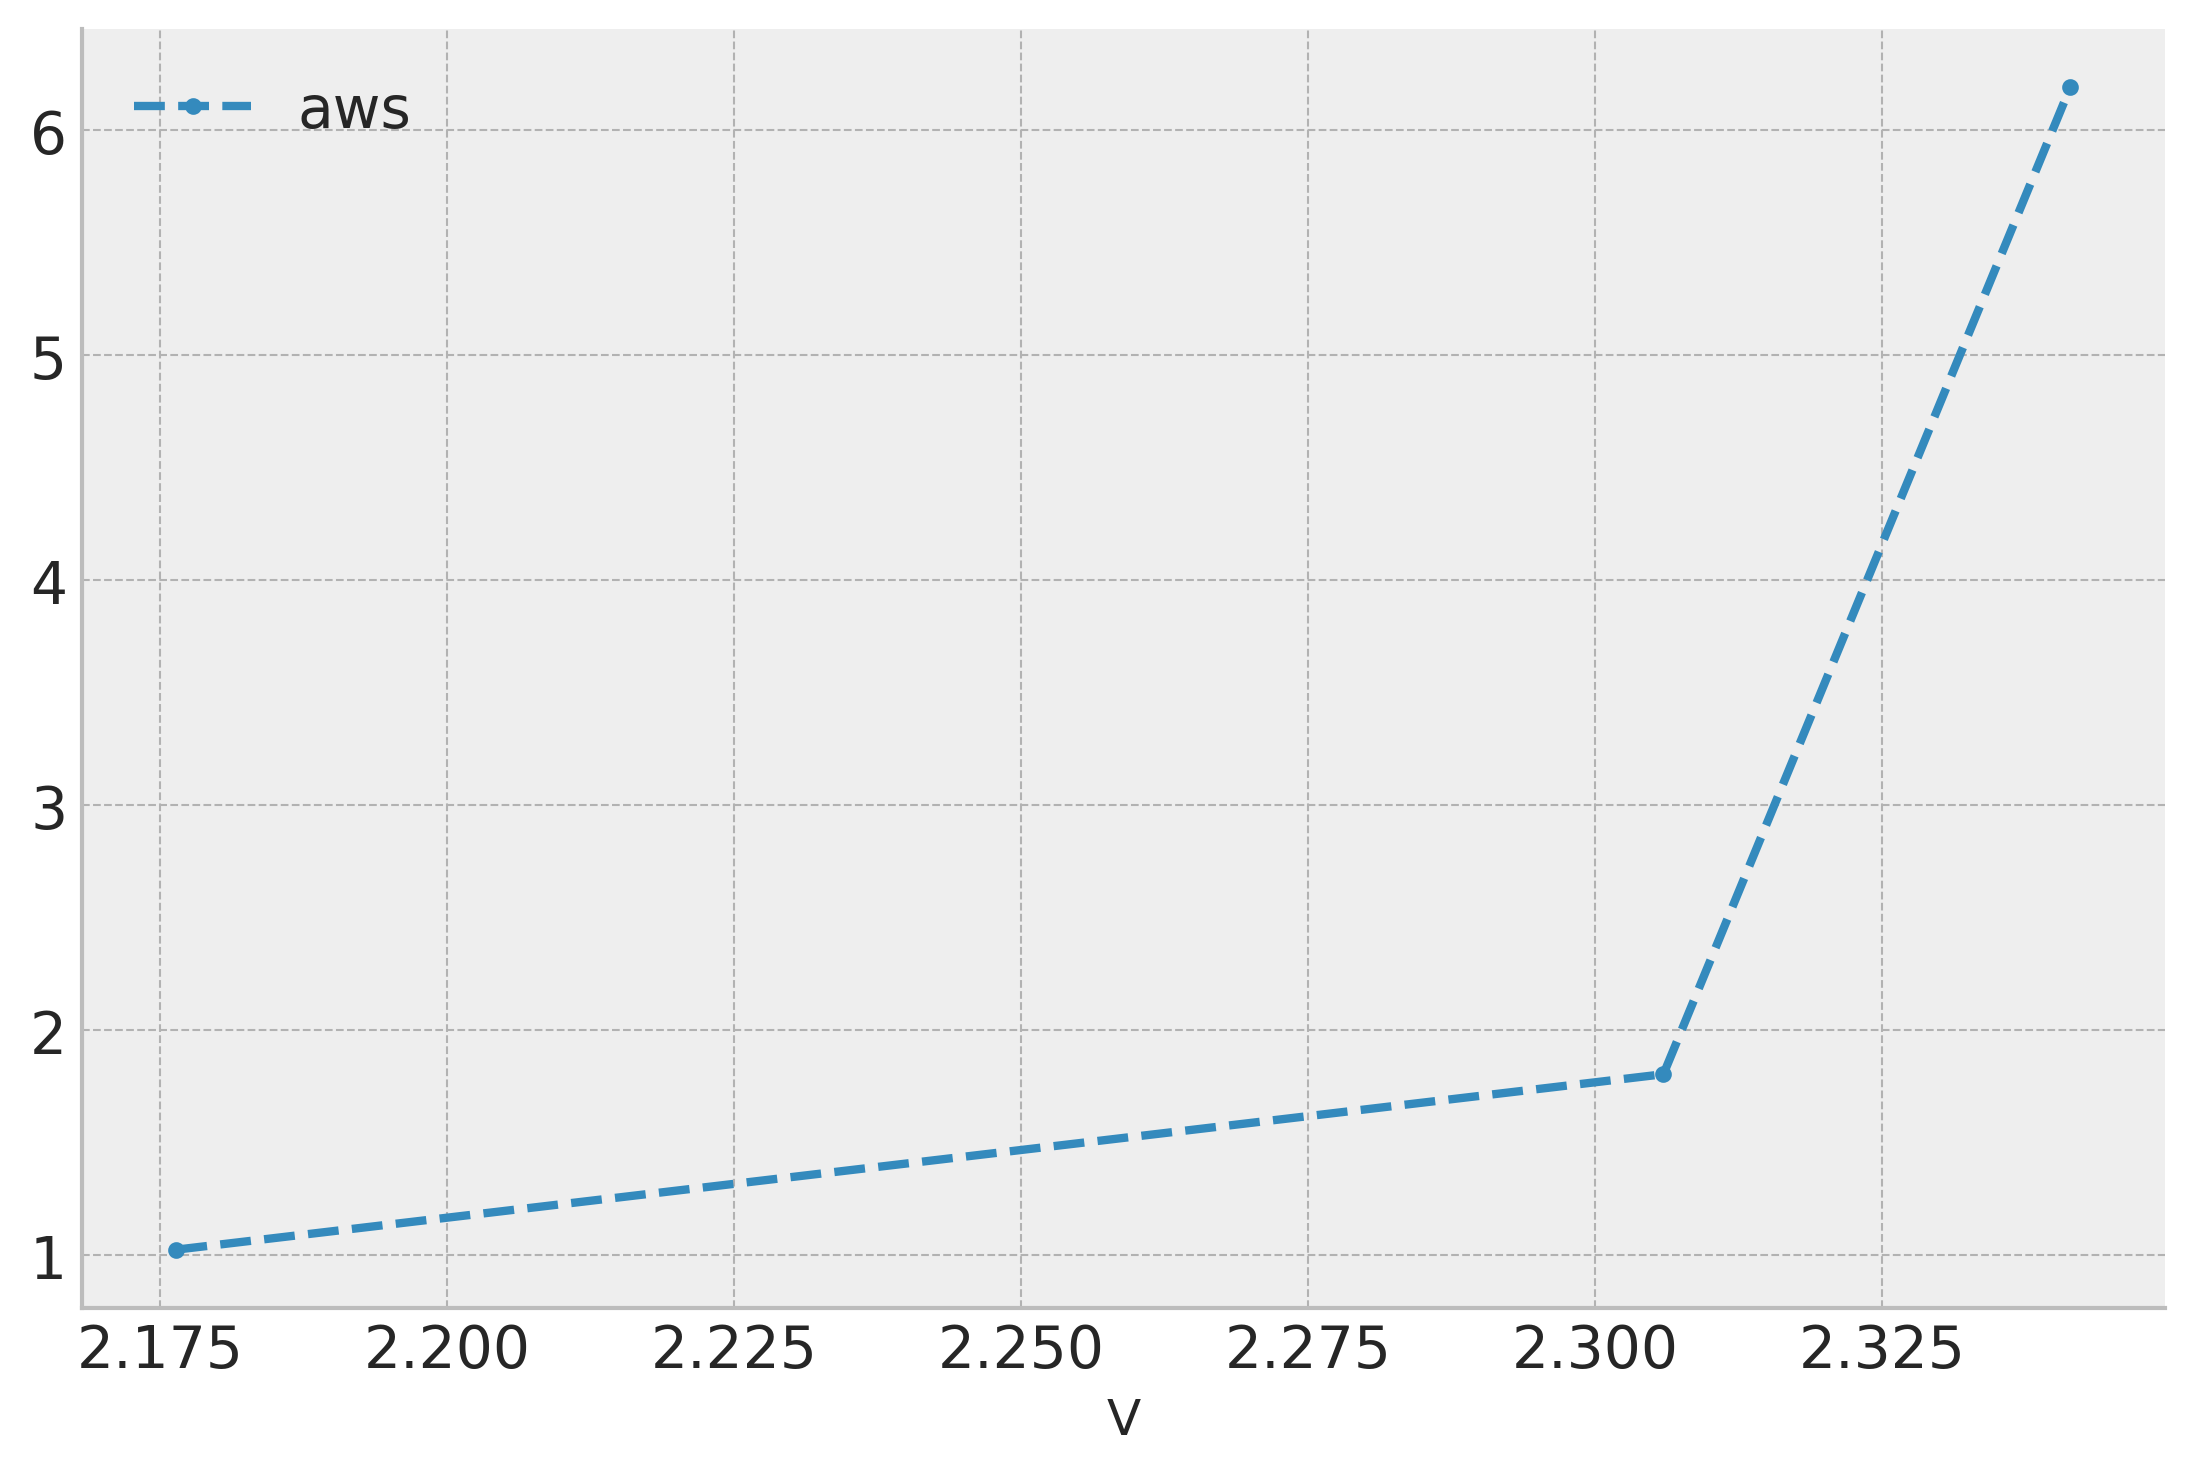

In [44]:
df_selection.sort_values(by='V').plot(x='V', y=['aws'],style='--.')

In [45]:
evaluations_field_data[['V','tws','aws','awa','overshoot_1','overshoot_2','period_1']]

V       tws       aws       awa  overshoot_1  overshoot_2   period_1
0   2.305946  0.729250  1.804531 -0.085510    10.100200    12.711332  10.636362
1   2.341380  4.342320  6.192513 -0.256885    11.390934    16.117823  11.603304
2   2.176433  2.593311  1.024787  3.079834    11.093616     6.502797  11.280990
3   2.123908  2.134847  0.755498 -0.249433     9.813491     6.321509  10.636362
4   1.740928  4.218393  2.700075 -2.639268     7.554986     7.204797  14.504130
5   1.778706  3.779875  2.233805 -2.962476     7.629523     6.679000  13.214874
6   1.178115  1.725254  1.300583  1.665823     4.162510     3.743517  14.826444
7   1.243054  2.015175  1.089375  2.797115     2.517729     5.370840  14.826444
8   1.015322  4.164313  5.020919 -0.349857     3.646677     5.113600  18.533055
9   1.035300  3.372593  4.225642 -0.334797     3.832346     2.721904  17.404956
10  1.633916  4.019844  5.248312 -0.424043     6.419241     7.658495  12.570246
11  1.610711  4.517658  5.911880 -0.143505     7.855647     5.899699  13.537188
12  1.888855  3.919398  5.427832 -0.307693     8.456729     6.743653  12.086775
13  1.952622  3.667493  5.124488 -0.393357     9.138778     8.246798  11.119833

In [46]:
evaluations_field_data.index = evaluations_field_data.index.astype(int)

In [47]:
table = evaluations_field_data.loc[0:13][['V','tws','aws','awa','overshoot_1','overshoot_2','period_1']].copy()
units['awa'] = 'deg'
table['awa'] = np.rad2deg(smallest_signed_angle(table['awa']))
table = table.applymap(np.format_float_positional, 
                                                          precision=3, 
                                                          unique=False, 
                                                          fractional=False)

units['V']='m/s'
table_units = pd.Series({key:units.get(key,'') for key in table.columns})
table.loc[-1] = table_units
table.sort_index(inplace=True)
table['Test'] = table.index.astype(str)
table['Time'] = evaluations_field_data['date'].dt.strftime('%H:%M')

table.loc[-1,'Test']=None
table.rename(columns={'overshoot_1':r'overshoot 1',
                      'overshoot_2':r'overshoot 2',
                      'period_1':r'period 1'}, inplace=True)

In [48]:
file_path = paper.file_path_with_nb_ref("field_study_test_overshoots.csv",directory='tables')
table[['Test','Time','V','tws','aws','awa','overshoot 1',r'overshoot 2',r'period 1']].to_csv(file_path,index=False, na_rep='')